In [1]:
%load_ext autoreload
%autoreload 2

# file ops
from pathlib import Path
import warnings
warnings.filterwarnings(action="ignore", category=RuntimeWarning)

# spatial
import xarray as xa
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# general
from tqdm.auto import tqdm

# custom
from coralshift import functions_creche
from coralshift.utils import file_ops, config, utils
from coralshift.dataloading import get_data
from coralshift.plotting import spatial_plots, visualise_results
from coralshift.machine_learning import static_models, run_model, ml_results
from coralshift.processing import ml_processing
from coralshift.processing import spatial_data

import cmipper


# data fps
gt_data_dir = config.gt_data_dir
config_fp = "/maps/rt582/coralshift/runs/config_files/config_test.yaml"
config_info = file_ops.read_yaml(config_fp)

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Illustrating discrepency between predictions at 1º and actual numbers of coral

In [74]:
model = file_ops.read_pickle("/maps/rt582/coralshift/runs/1d/xgb_reg/ID018_cmip6_unep_gebco_slope/ID018_cmip6_unep_gebco_slope_MODEL.pickle")
X_train = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/-2000_10/1/train_X_1_S30-0_S2-0_E140-0_E166-0.parquet")
y_train = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/-2000_10/1/train_y_1_S30-0_S2-0_E140-0_E166-0.parquet")
X_test = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/-2000_10/1/test_X_1_S30-0_S2-0_E140-0_E166-0.parquet")
y_test = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/-2000_10/1/test_y_1_S30-0_S2-0_E140-0_E166-0.parquet")

train_preds = ml_results.AnalyseResults(config_info=config_info, model=model, model_code="xgb_reg").make_predictions(X_train)
test_preds = ml_results.AnalyseResults(config_info=config_info, model=model, model_code="xgb_reg").make_predictions(X_test)


	Running inference on 182 datapoints...
	Running inference on 46 datapoints...


In [75]:
high_res_y_train = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/custom_checkerboard/-20_10/0-01/train_y_0-01_S30-0_S2-0_E140-0_E166-0.parquet")

In [76]:
high_res_y_train.columns

Index([0], dtype='int64')

In [77]:
df_low_res = y_train

In [78]:
# Create bins for 1º resolution
high_res_y_train['lat_bin'] = high_res_y_train.index.get_level_values('latitude').round()
high_res_y_train['lon_bin'] = high_res_y_train.index.get_level_values('longitude').round()

# Calculate the range in each 1º grid cell
range_df = high_res_y_train.groupby(['lat_bin', 'lon_bin']).agg({0: lambda x: x.max() - x.min()})
range_df.columns = ['range']

# # Merge with df_low_res to get a DataFrame with the range values
df_low_res = df_low_res.reset_index()
merged_df = df_low_res.merge(range_df, left_on=['latitude', 'longitude'], right_on=['lat_bin', 'lon_bin'], how='left')
merged_df.set_index(['latitude', 'longitude'], inplace=True)

In [79]:
merged_df

0     range
latitude longitude                    
-9.0     144.0     -0.347108  0.666918
-21.0    159.0      0.820405  1.000000
-8.0     160.0     -0.275297  0.902647
-20.0    161.0     -0.475179  0.000000
-7.0     157.0     -0.096991  0.753460
...                      ...       ...
-15.0    146.0      1.436249  1.000000
-27.0    162.0     -0.475179       NaN
-17.0    152.0      0.039979  0.230068
-5.0     150.0     -0.237196  0.918254
-16.0    152.0     -0.475179       NaN

[182 rows x 2 columns]

Text(0, 0.5, 'predicted coral presence')

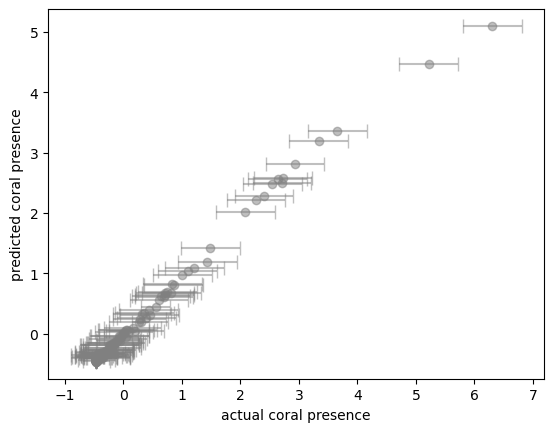

In [80]:
# plot scatter with horizontal range bars on each point
# plt.scatter(merged_df[0], train_preds, alpha=0.5)
# for i, row in merged_df.iterrows():
#     plt.plot([row[0], row[0] + row['range']], [train_preds[i], train_preds[i]], color='black')

plt.errorbar(merged_df[0], train_preds, xerr=merged_df['range']/2, fmt='o', color='gray', alpha=0.5, capsize=5)


plt.xlabel("actual coral presence")
plt.ylabel("predicted coral presence")

# plt.scatter(merged_df[0], train_preds)

In [8]:
y_train

0
latitude longitude          
-9.0     144.0     -0.347108
-21.0    159.0      0.820405
-8.0     160.0     -0.275297
-20.0    161.0     -0.475179
-7.0     157.0     -0.096991
...                      ...
-15.0    146.0      1.436249
-27.0    162.0     -0.475179
-17.0    152.0      0.039979
-5.0     150.0     -0.237196
-16.0    152.0     -0.475179

[182 rows x 1 columns]

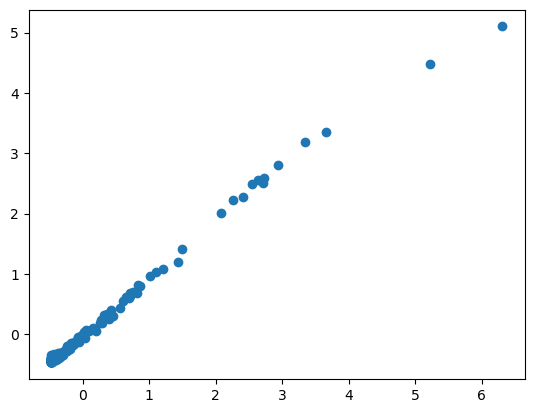

In [7]:
plt.scatter(y_train, train_preds)


# Talk feedback

Too much transition animations. Only animate the important things which are activately fading: they need to emphasis/support the point being made.
If need time, reduce motivation aspect – can chop 20s in first two slides
Practise transitions
Scale bar on (most) figures

"Looks super interesting" – Anthea

(<Figure size 3000x1200 with 1 Axes>, <Axes: xlabel='Spatial scale (m)'>)

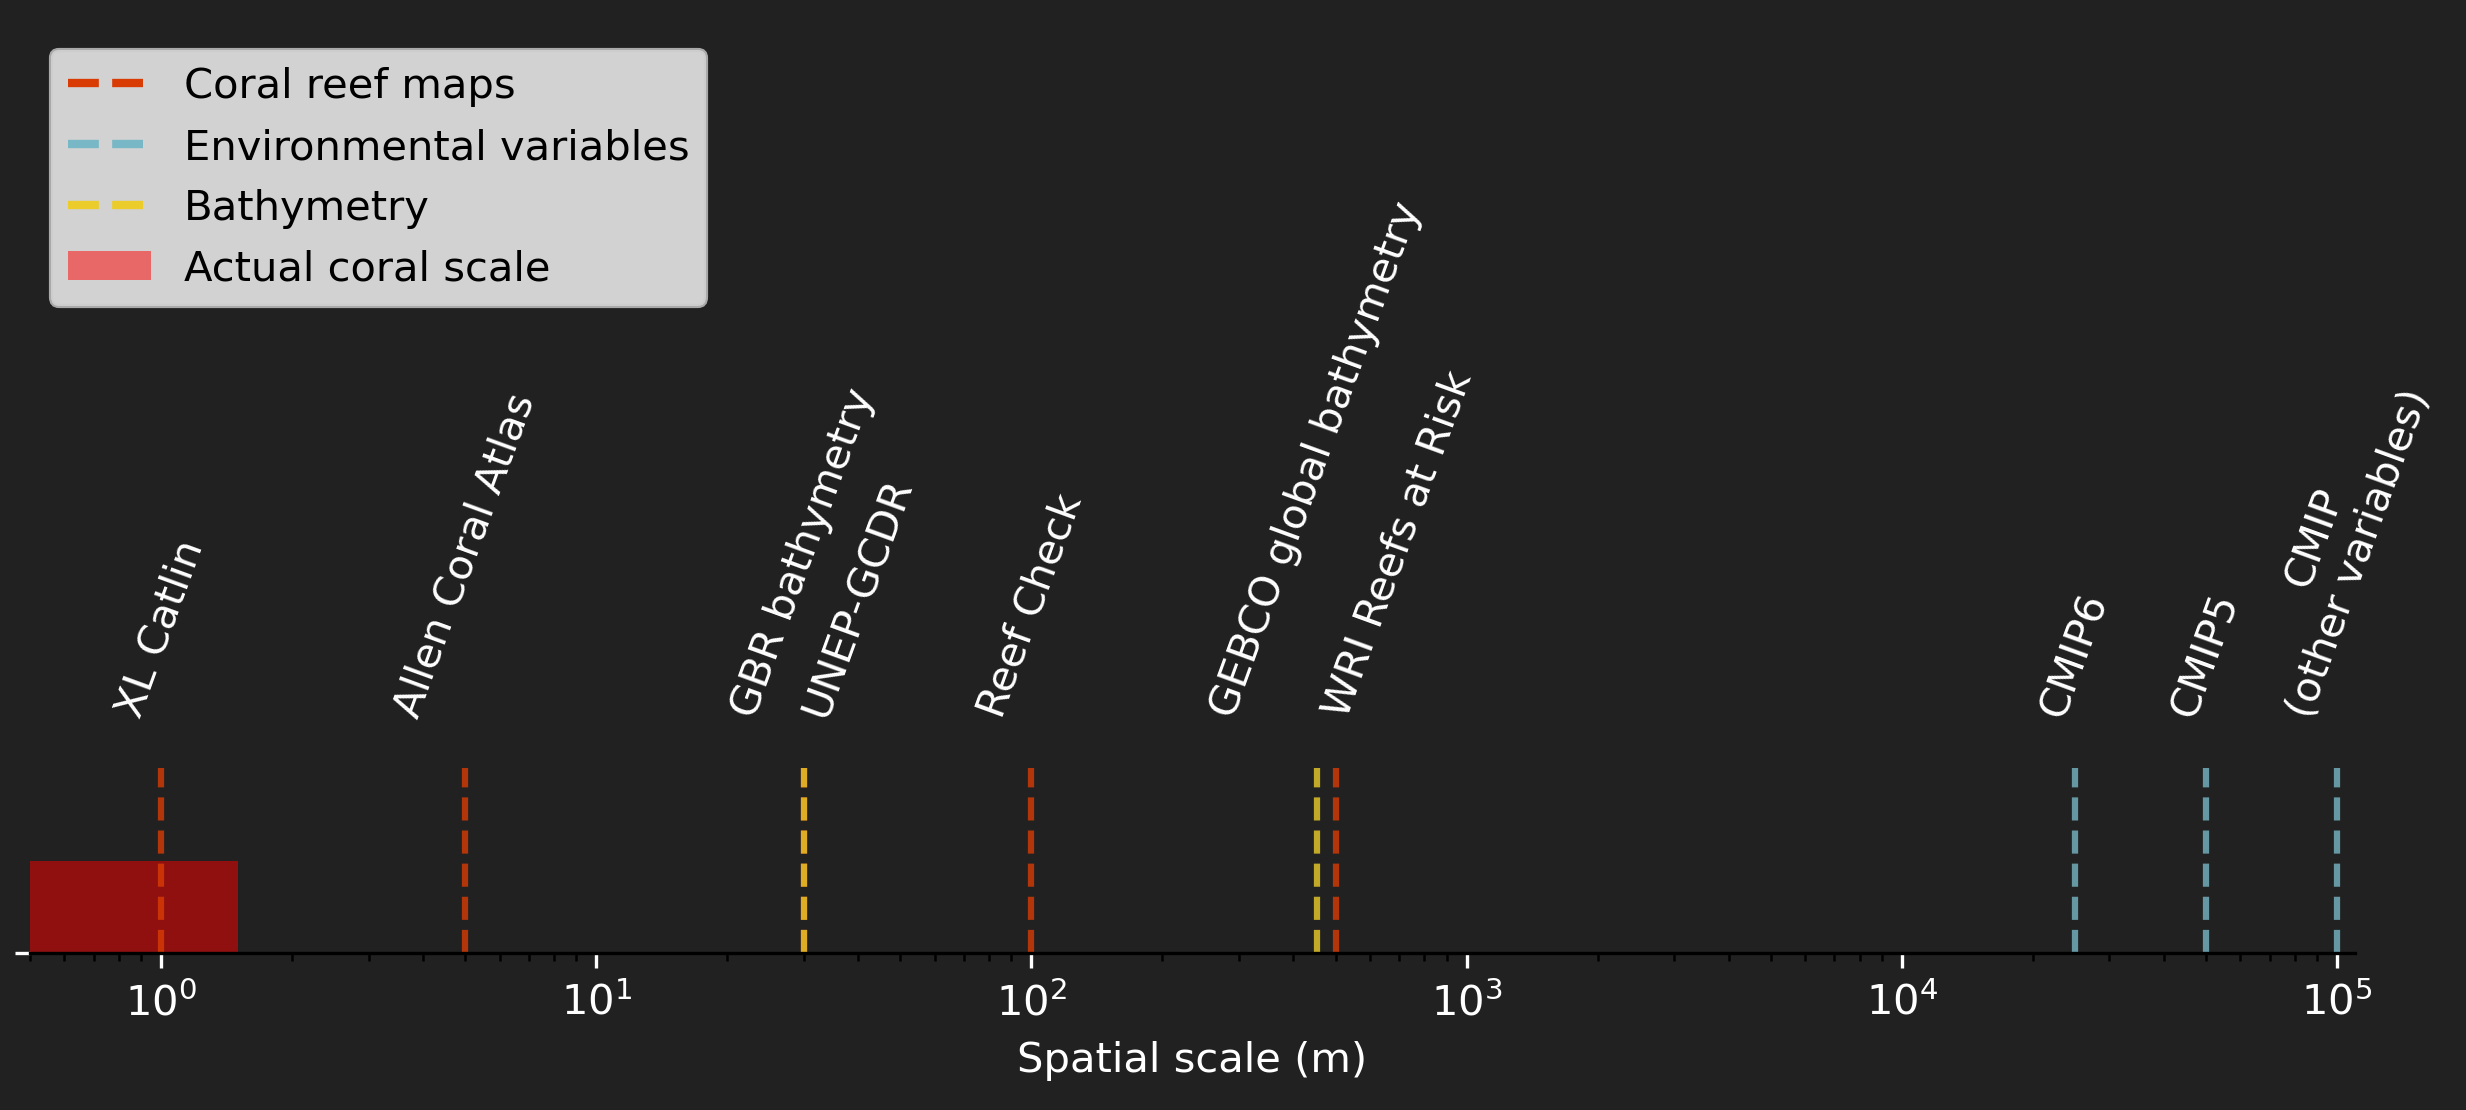

In [10]:
coral_scales = [1, 5, 30, 100, 500]
coral_scales_labels = ["XL Catlin", "Allen Coral Atlas", "UNEP-GCDR", "Reef Check", "WRI Reefs at Risk"]

variable_scales = [25e3, 50e3, 100e3]
variable_scales_labels = ["CMIP6", "CMIP5", "CMIP\n(other variables)"]

bathymetry_scales = [30, 452]
bathymetry_scales_labels = ["GBR bathymetry", "GEBCO global bathymetry"]

# plot horizontal line with values and labels on log scale
fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
ax.set_xscale("log")
ax.set_xlim(0.5, 1.1e5)
ax.set_ylim(0.5, 1.5)
ax.set_yticks([0.5])    
ax.set_yticklabels([""])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.set_xlabel("Spatial scale (m)")
# ax.set_title("Spatial scales of coral reef datasets")

for i, scale in enumerate(coral_scales):
    ax.axvline(scale, ymax=0.2, color="#d83c04", linestyle="--", alpha=0.8)
    if coral_scales_labels[i] == "WRI Reefs at Risk":
        ax.text(scale+200, 0.75, coral_scales_labels[i], rotation=70, ha="center", va="bottom", color="black")
    elif coral_scales_labels[i] == "UNEP-GCDR":
        ax.text(scale+10, 0.75, coral_scales_labels[i], rotation=70, ha="center", va="bottom")
    else:
        ax.text(scale, 0.75, coral_scales_labels[i], rotation=70, ha="center", va="bottom")

for i, scale in enumerate(variable_scales):
    ax.axvline(scale, ymax=0.2, color="#78B7C5", linestyle="--", alpha=0.8)

    ax.text(scale, 0.75, variable_scales_labels[i], rotation=70, ha="center", va="bottom")

# plot bathymetries
for i, scale in enumerate(bathymetry_scales):
    ax.axvline(scale, ymax=0.2, color="#EBCC2A", linestyle="--", alpha=0.8)
    ax.text(scale, 0.75, bathymetry_scales_labels[i], rotation=70, ha="center", va="bottom")

# plot a rectangle from 1m to left of axis. Patch should have a gradient fill from transparent to red
ax.add_patch(plt.Rectangle((0.5, 0.5), 1, 0.1, color="red", lw=0, alpha=0.5))
# add legend entry for rectangle
from matplotlib.patches import Patch


custom_lines = [Line2D([0], [0], color="#d83c04", linestyle="--", lw=2),
                Line2D([0], [0], color="#78B7C5", linestyle="--", lw=2),
                Line2D([0], [0], color="#EBCC2A", linestyle="--", lw=2),
                Patch(color="red", alpha=0.5, lw=0)
                ]
ax.legend(custom_lines, ["Coral reef maps", "Environmental variables", "Bathymetry", "Actual coral scale"], loc="upper left")

spatial_plots.customize_plot_colors(fig, ax)


# Scale comparison

### Logarithmic scale comparison

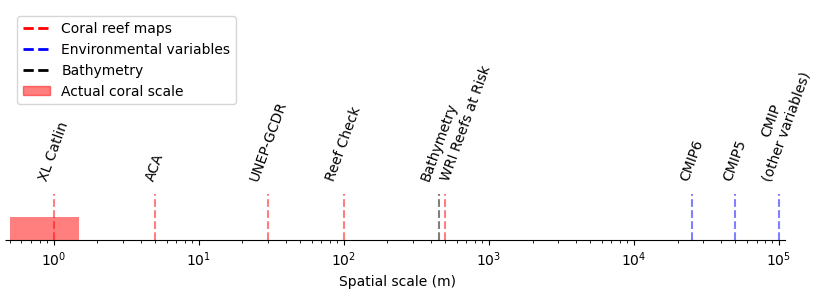
### Visual scale comparison
Also without square
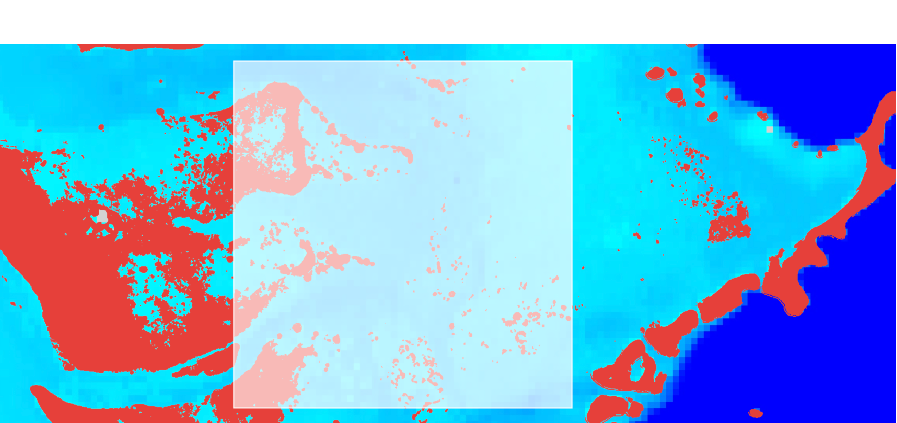

# Load data

In [2]:
config_info["resolution"] = 0.01
cmip_raster = ml_processing.ProcessMLData(config_info=config_info).get_merged_datasets()

Searching for correct CMIP files in: /maps-priv/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1/regridded
	calculating statistics for static ML model(s)...


calculating statistics for variables: 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]


	applying spatial buffering...
360 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 360/360 [00:25<00:00, 14.12it/s]


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading UNEP_GDCR xarray at 0.004 degrees resolution.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading gebco elevation xarray across [-31, -1] latitudes & [139, 167] longitudes from /maps-priv/maps/rt582/coralshift/data/bathymetry/gebco/GEBCO_2023_n90-0_s90-0_w180-0_e180-0.nc.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]

Transposing filled array to match the original shape.


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading gebco elevation xarray across [-31, -1] latitudes & [139, 167] longitudes from /maps-priv/maps/rt582/coralshift/data/bathymetry/gebco/GEBCO_2023_n90-0_s90-0_w180-0_e180-0.nc.
calculating slopes from bathymetry...
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:09<00:00,  9.48s/it]

Transposing filled array to match the original shape.


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


In [3]:
(trains, tests, vals), ds_info = ml_processing.ProcessMLData(
    config_info=config_info
).generate_ml_ready_data()

Searching for correct CMIP files in: /maps-priv/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1/regridded
	calculating statistics for static ML model(s)...


calculating statistics for variables: 100%|██████████| 9/9 [00:02<00:00,  4.34it/s]


	applying spatial buffering...
360 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 360/360 [00:24<00:00, 14.40it/s]


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading UNEP_GDCR xarray at 0.004 degrees resolution.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading gebco elevation xarray across [-31, -1] latitudes & [139, 167] longitudes from /maps-priv/maps/rt582/coralshift/data/bathymetry/gebco/GEBCO_2023_n90-0_s90-0_w180-0_e180-0.nc.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

Transposing filled array to match the original shape.


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading gebco elevation xarray across [-31, -1] latitudes & [139, 167] longitudes from /maps-priv/maps/rt582/coralshift/data/bathymetry/gebco/GEBCO_2023_n90-0_s90-0_w180-0_e180-0.nc.
calculating slopes from bathymetry...
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:08<00:00,  8.30s/it]

Transposing filled array to match the original shape.


	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
	fitting scaler to X data...
	fitting scaler to y data...

	transforming data...


# Bathymetry/slope

In [ ]:
import cartopy.crs as ccrs
f, (ax_bath, ax_slopes) = plt.subplots(ncols=2, figsize=[12,7], subplot_kw={"projection": ccrs.PlateCarree()})

spatial_plots.plot_spatial(cmip_raster["elevation"], fax=(f,ax_bath), title=None, val_lims=[0,-500], cbar_dict={"orientation": "horizontal", "name": "depth", "cmap_type": "lim_blue"}, cartopy_dict={"alpha": 1, "facecolor": "lightgrey"})
spatial_plots.plot_spatial(cmip_raster["slope"], fax=(f,ax_slopes), title=None, cbar_dict={"orientation": "horizontal", "name": "gradient"}, cartopy_dict={"alpha": 1, "facecolor": "lightgrey"})

In [ ]:
sns.pairplot(cmip_raster[["slope", "elevation"]].to_dataframe(), kind="reg", diag_kind="kde", plot_kws={"color":"#3B9AB2", "scatter_kws": {"alpha": 0.01}}, diag_kws={"color":"#d83c04"})

In [ ]:
sns.pairplot(trains[0][["slope", "elevation"]], kind="reg", diag_kind="kde", plot_kws={"color":"#3B9AB2", "scatter_kws": {"alpha": 0.01}}, diag_kws={"color":"#d83c04"})

## Environmental

In [4]:
timeseries = get_data.ReturnRaster(config_info=config_info, ds_type="continuous").get_raw_raster(dataset="cmip")

Searching for correct CMIP files in: /maps-priv/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1/regridded


#### Visualise interpolation

In [5]:
config_info["spatial_buffer"] = 5
buffered = get_data.ReturnRaster(config_info=config_info, ds_type="continuous").get_spatially_buffered_raster(timeseries.isel(time=slice(0,12)))


	applying spatial buffering...
9 raster(s) to spatially buffer...


Buffering variables:   0%|          | 0/9 [00:00<?, ?it/s]

Buffering variables: 100%|██████████| 9/9 [00:04<00:00,  2.14it/s]


(<Figure size 3000x3000 with 2 Axes>,
 <GeoAxes: title={'center': 'thetao at 0.2500° (~27118 m) resolution'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
 <cartopy.mpl.geocollection.GeoQuadMesh at 0x7fce096563c0>)

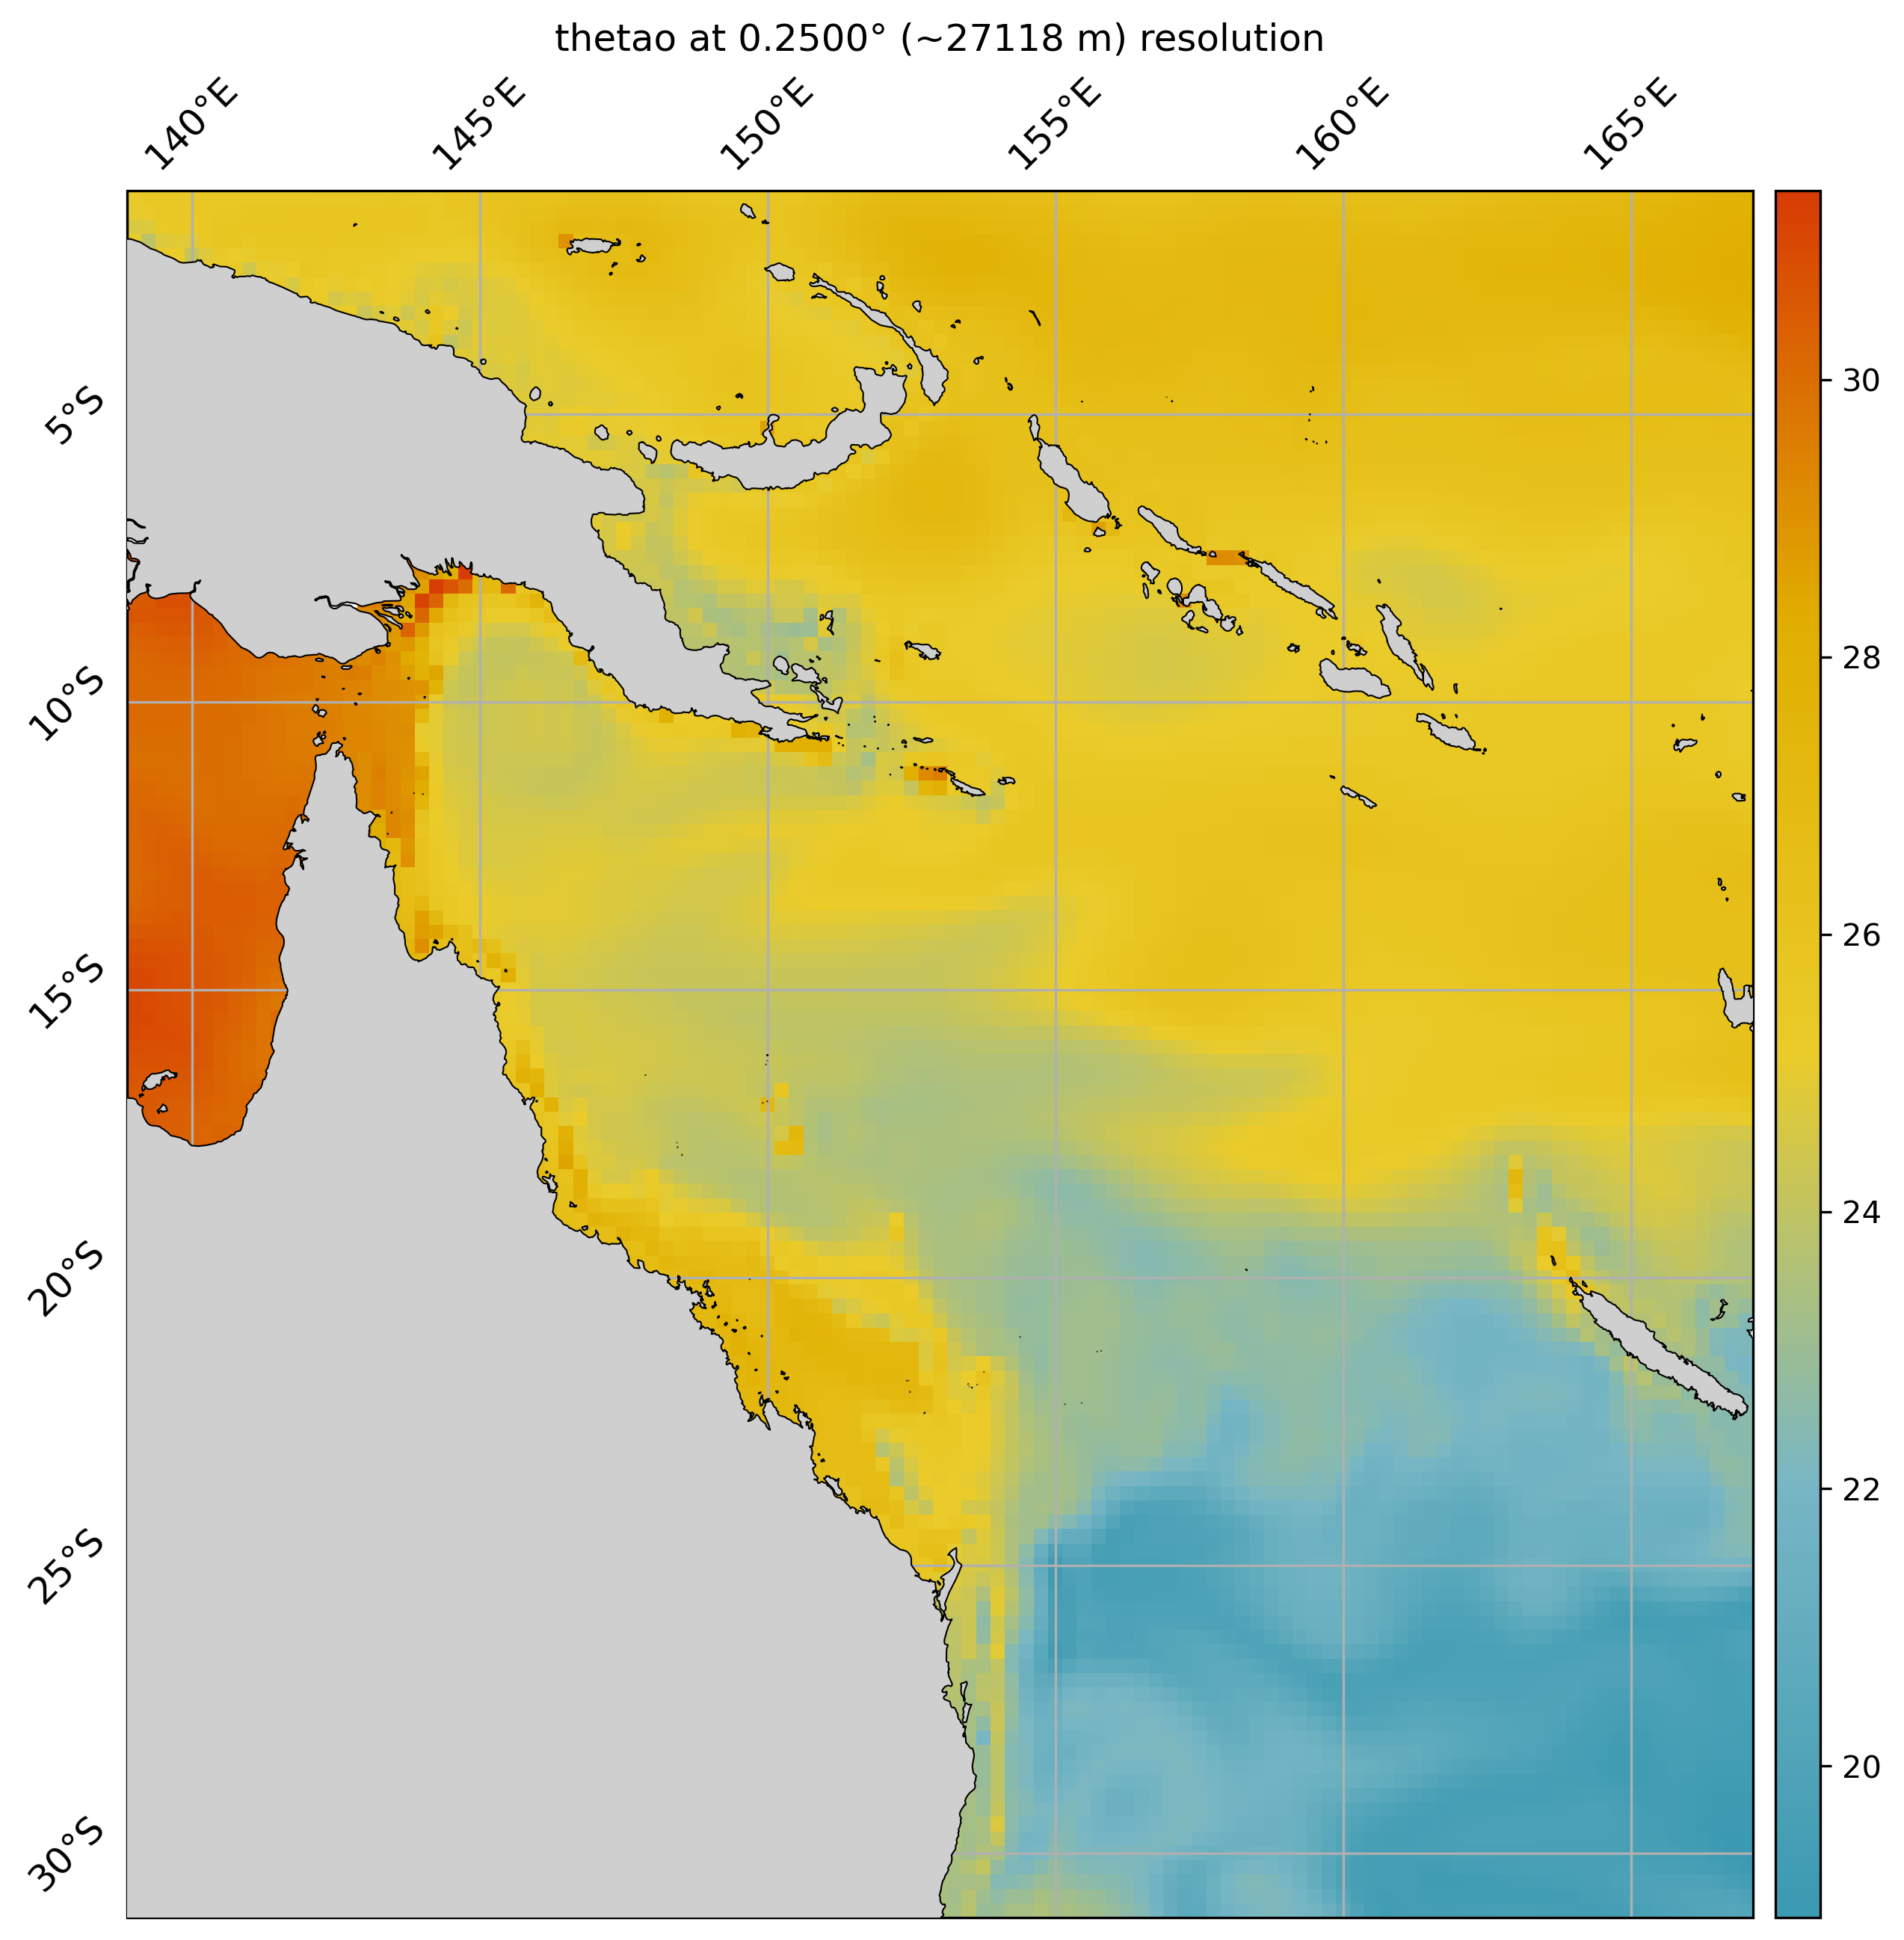

In [32]:
spatial_plots.plot_spatial(buffered["thetao"].isel(time=0))

In [12]:
plt.show()

In [43]:
resampled_sample

<xarray.DataArray 'thetao' (latitude: 7, longitude: 16)> Size: 448B
array([[24.951145, 24.826927, 24.803413, 24.692072, 24.622677, 24.789345,
        25.200878, 25.312294, 25.317026, 25.39332 , 25.347725, 25.581566,
        25.926115, 26.052237, 26.015436, 25.96306 ],
       [24.677439, 24.516083, 24.545525, 24.566378, 24.648815, 24.705067,
        24.79377 , 25.06572 , 25.287786, 25.205997, 25.718037, 25.758894,
        25.829617, 25.917585, 25.97565 , 25.984747],
       [24.456818, 24.331505, 24.350035, 24.78385 , 24.788473, 24.941586,
        25.015348, 24.5943  , 25.72325 , 25.307236, 25.496187, 25.381672,
        25.401031, 25.498837, 25.562117, 25.582817],
       [24.399815, 24.381163, 24.646315, 25.083124, 24.928242, 24.717798,
        24.529255, 24.725313, 25.334167, 25.328348, 25.100157, 24.879154,
        24.830868, 24.998213, 25.193352, 25.29738 ],
       [24.828583, 24.717611, 24.909082, 24.610418, 24.237974, 23.87145 ,
        24.130007, 25.123968, 25.351484, 25.116762, 24.9335  , 24.775806,
        24.743269, 24.907919, 25.070696, 25.186752],
       [27.108328, 25.935928, 24.936102, 24.404116, 24.3274  , 24.72029 ,
        25.02695 , 25.672215, 25.80906 , 25.490108, 25.17024 , 25.119762,
        25.365961, 25.611258, 25.308771, 25.06155 ],
       [28.146467, 26.618635, 24.967146, 24.540014, 25.119553, 25.565884,
        25.959982, 26.573626, 26.869307, 26.303553, 25.906858, 26.003408,
        25.855927, 25.993723, 25.673758, 25.45586 ]], dtype=float32)
Coordinates:
  * longitude    (longitude) float64 128B 145.0 146.0 147.0 ... 159.0 160.0
  * latitude     (latitude) float64 56B -13.0 -12.0 -11.0 -10.0 -9.0 -8.0 -7.0
    time         datetime64[ns] 8B 1950-01-16T12:00:00
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  3.402823466e+38

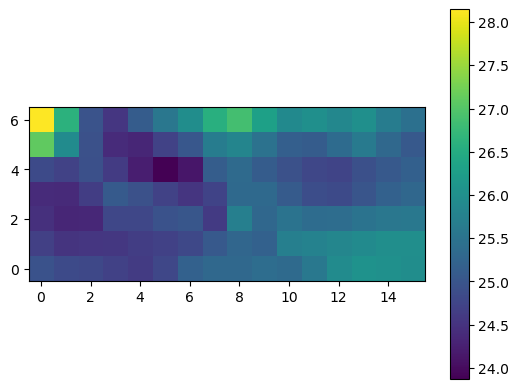

In [47]:
plt.imshow(resampled_sample.values)
# invert y axis
plt.gca().invert_yaxis()
plt.colorbar()

	resampling dataset to 0.25 degree(s) resolution...

[-14, -6.5] [144, 161]
Resampling pipeline: written raster CRS to EPSG:4326


TypeError: _AxesBase.add_patch() got an unexpected keyword argument 'zorder'

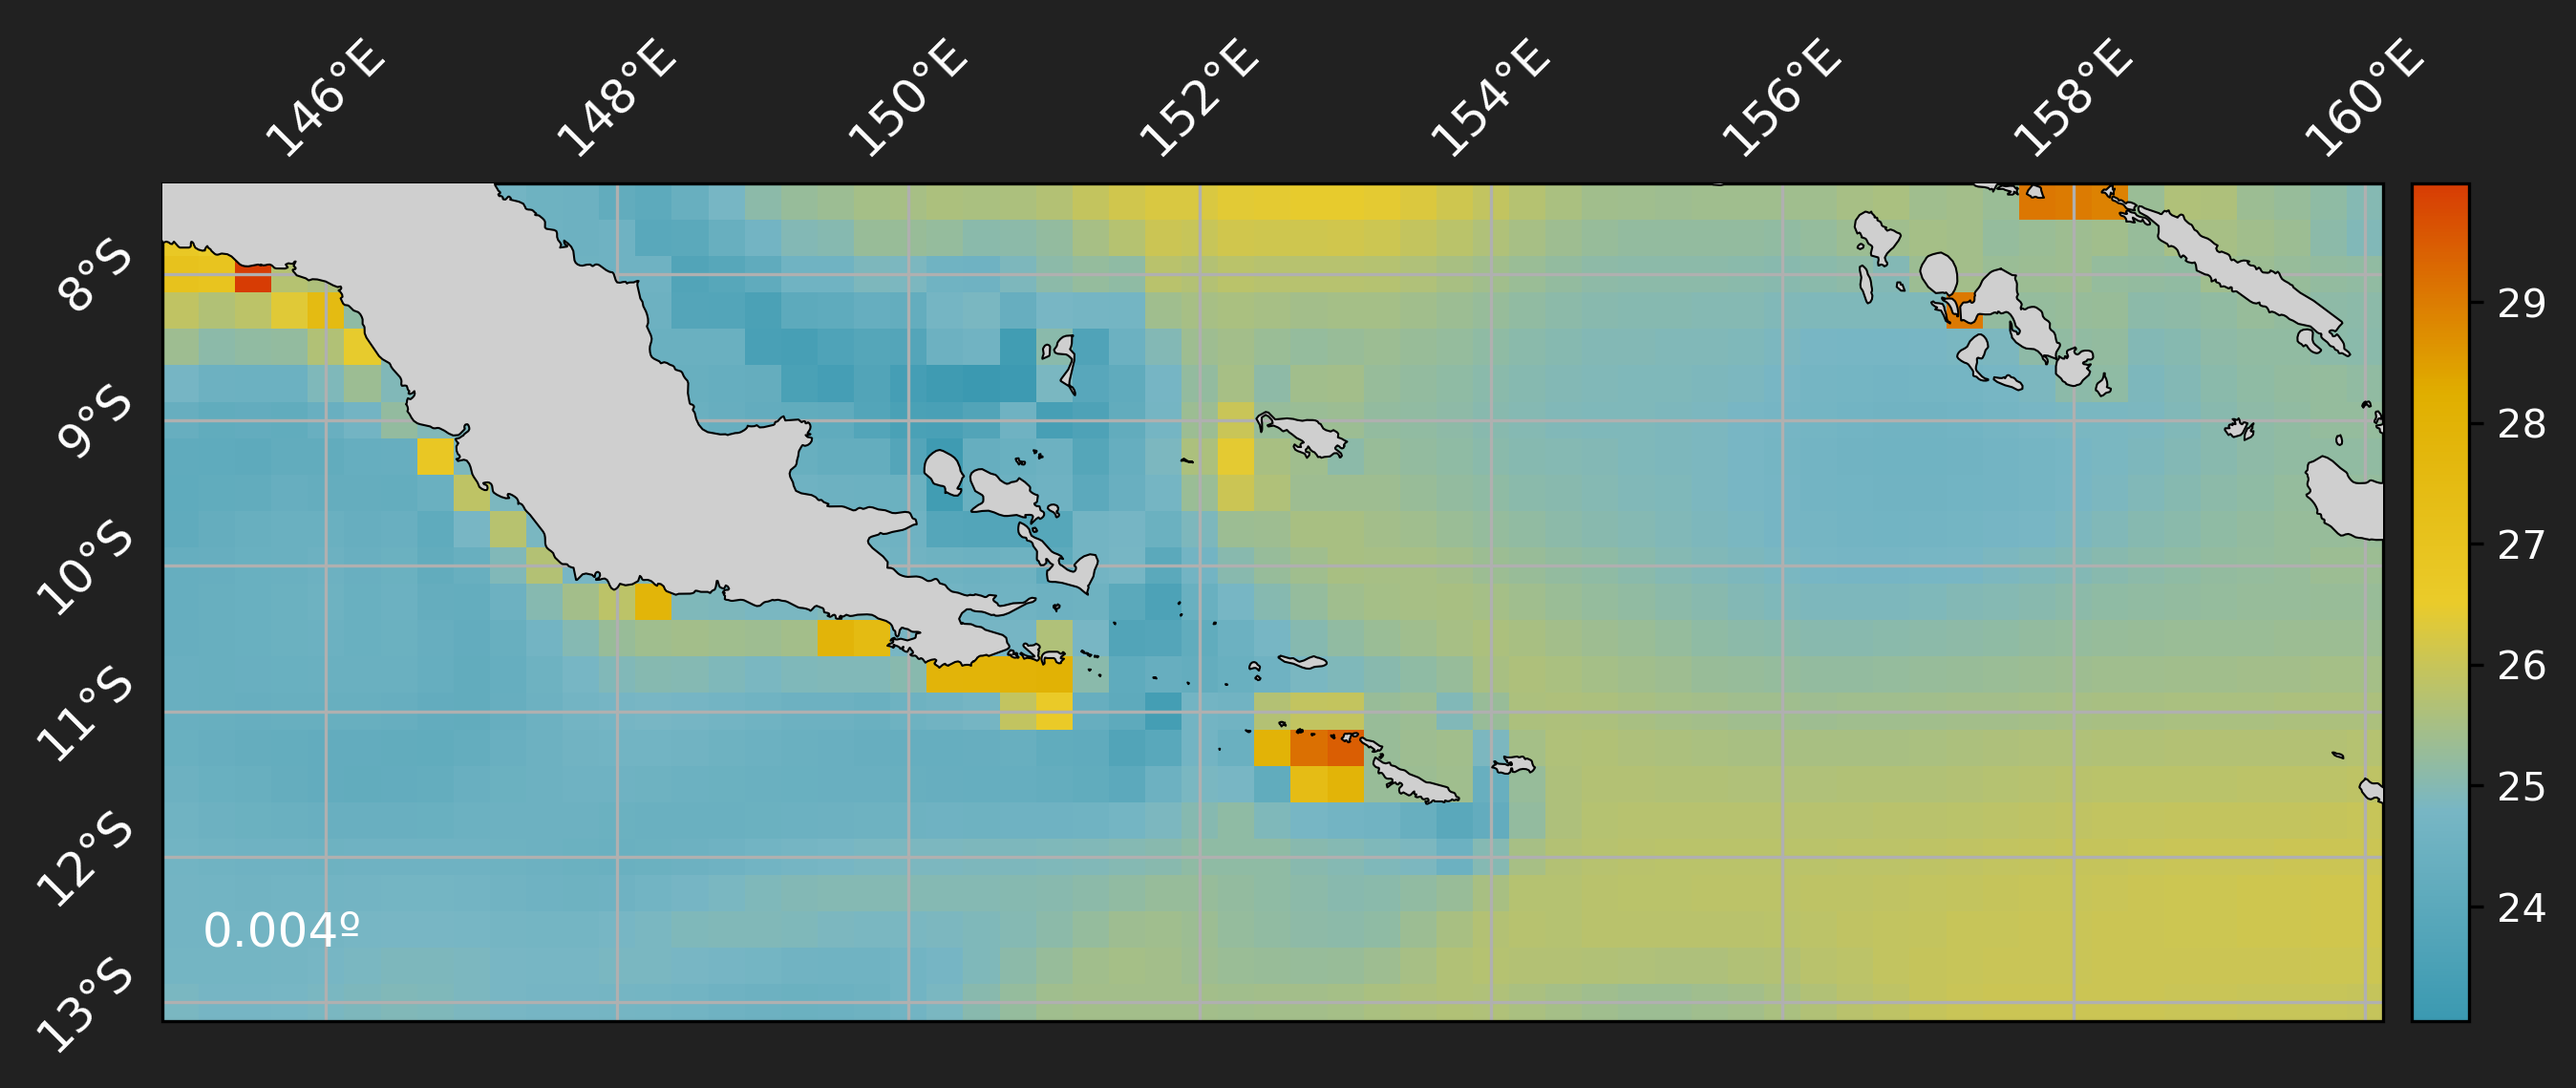

In [128]:
config_info["resolution"] = 0.25
config_info["lats"] = [-13, -7.5]
config_info["lons"] = [145, 160] 

import matplotlib.patches as mpatches

resampled_sample = get_data.ReturnRaster(config_info=config_info).get_resampled_raster(og["thetao"])
f, ax, im = spatial_plots.plot_spatial(resampled_sample, presentation_format=True, cbar_dict={"cbar": True}, title="", 
    # labels=[]
    )
ax.text(0.018, 0.09, f"{res}º", transform=ax.transAxes, color="white", fontsize=12)
# plot rectangle patch
ax.add_patch(mpatches.Rectangle(xy=[145, -13], width=2, height=1,
                                facecolor='black', edgecolor='#232323', alpha=0.5,
                                transform=ccrs.PlateCarree()))
# plt.show()

	resampling dataset to 1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


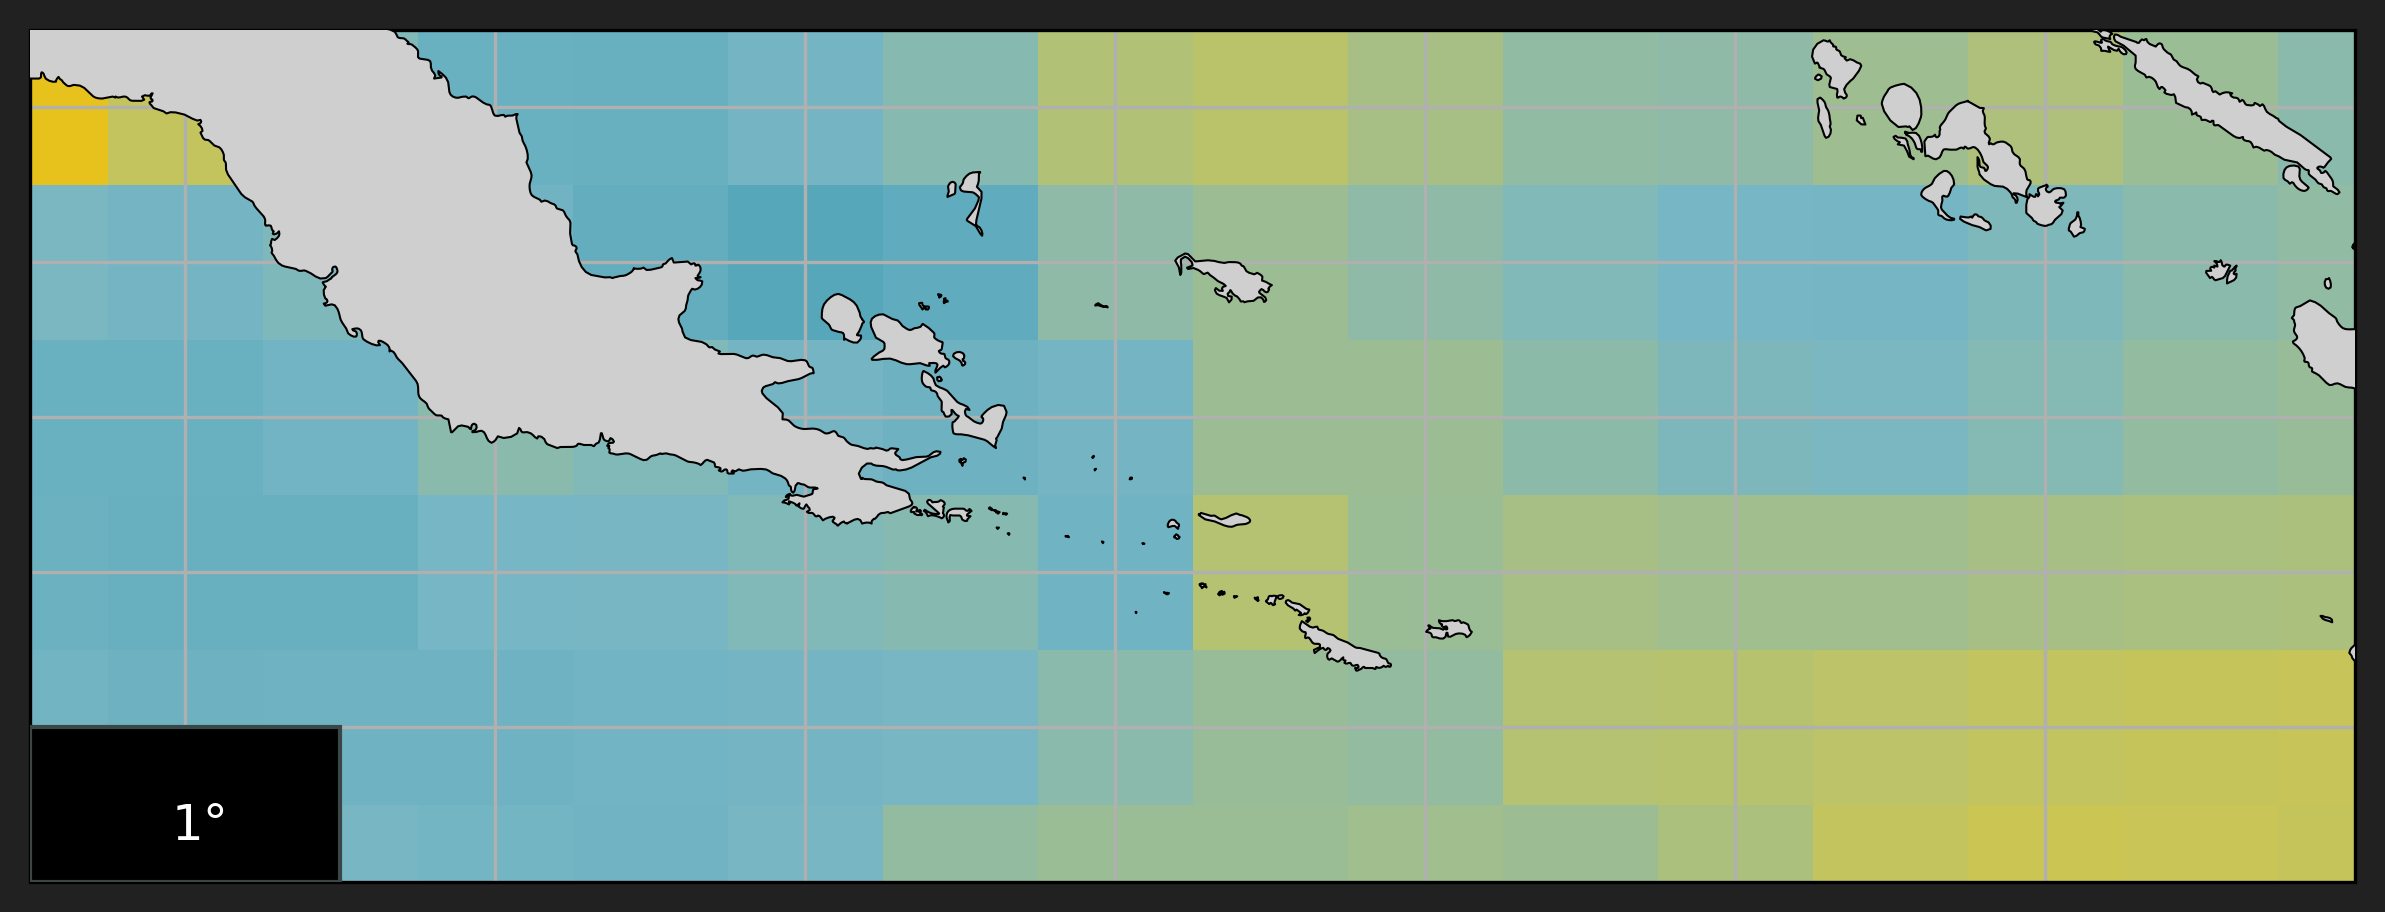

	resampling dataset to 0.5 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


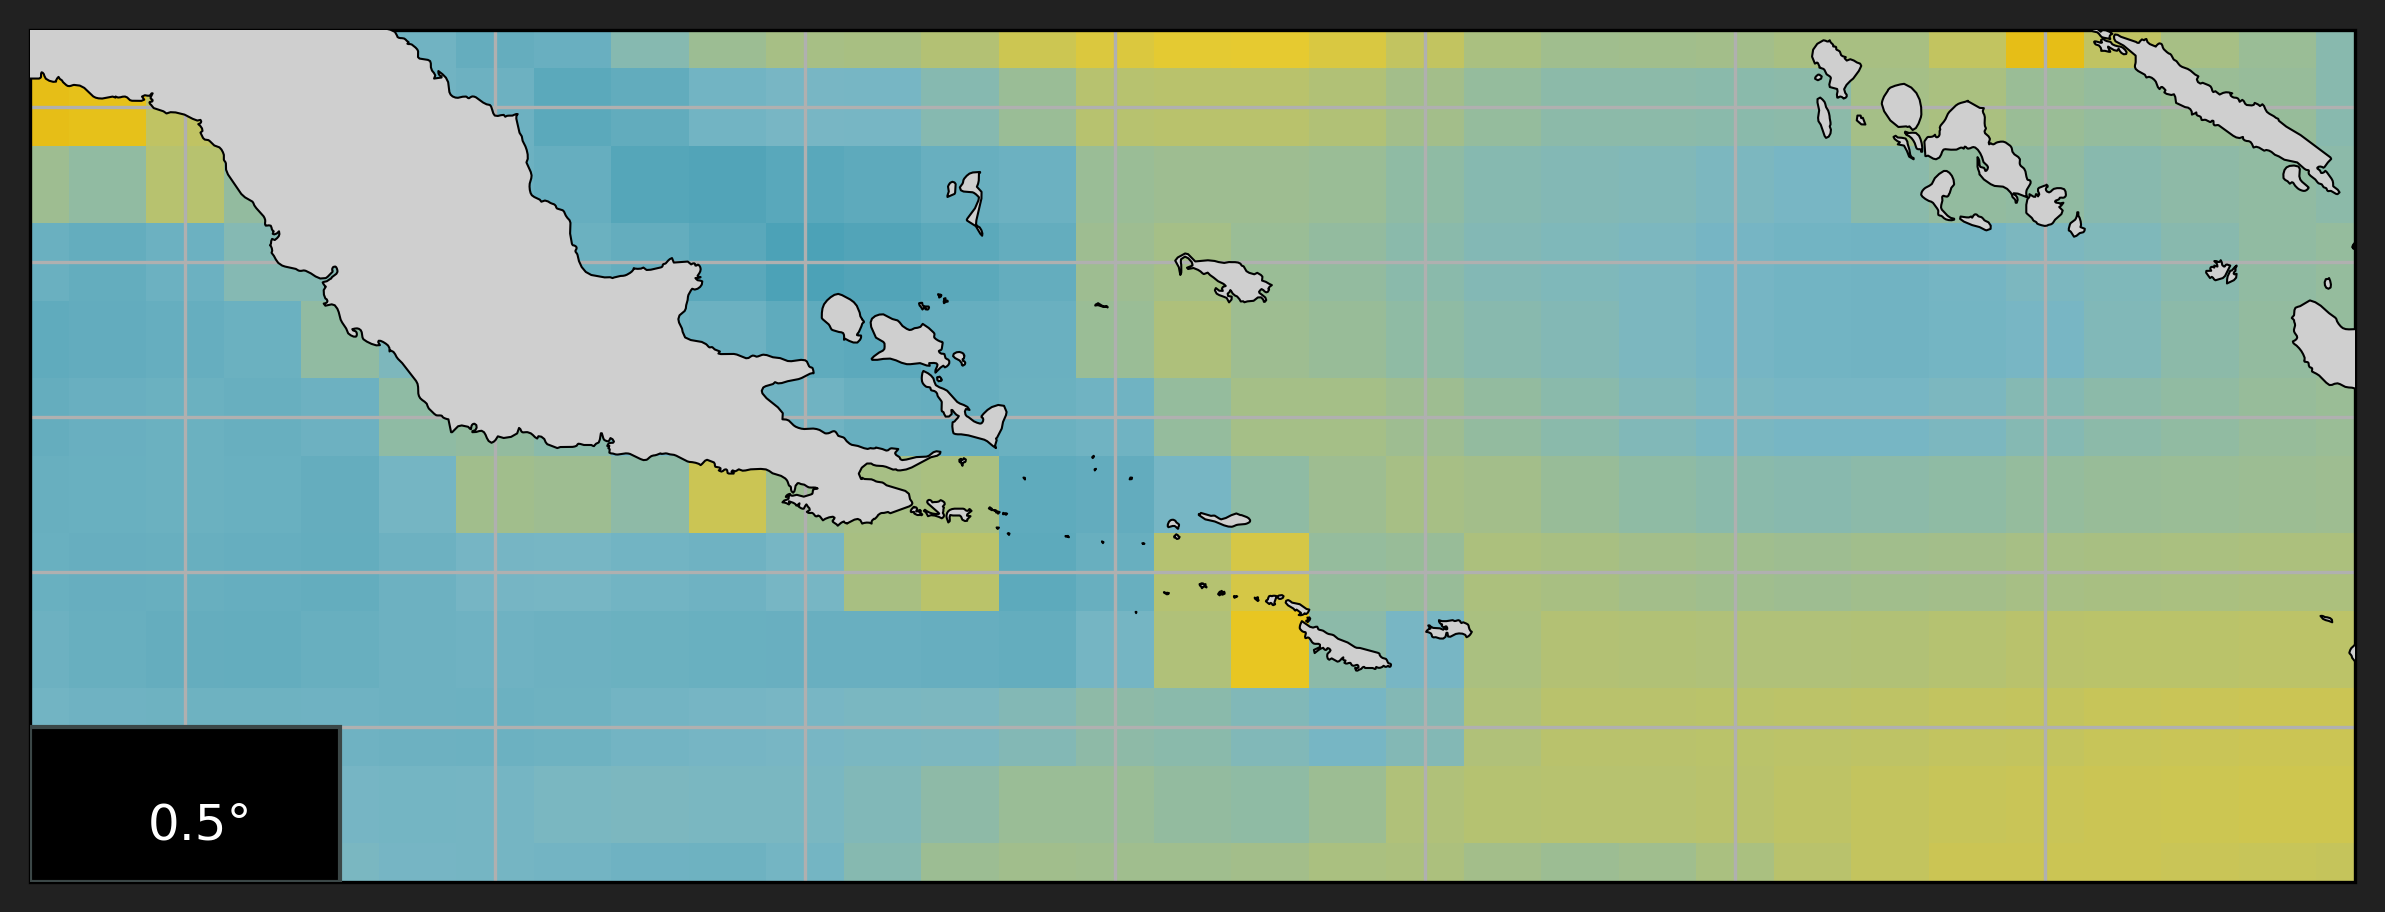

	resampling dataset to 0.25 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


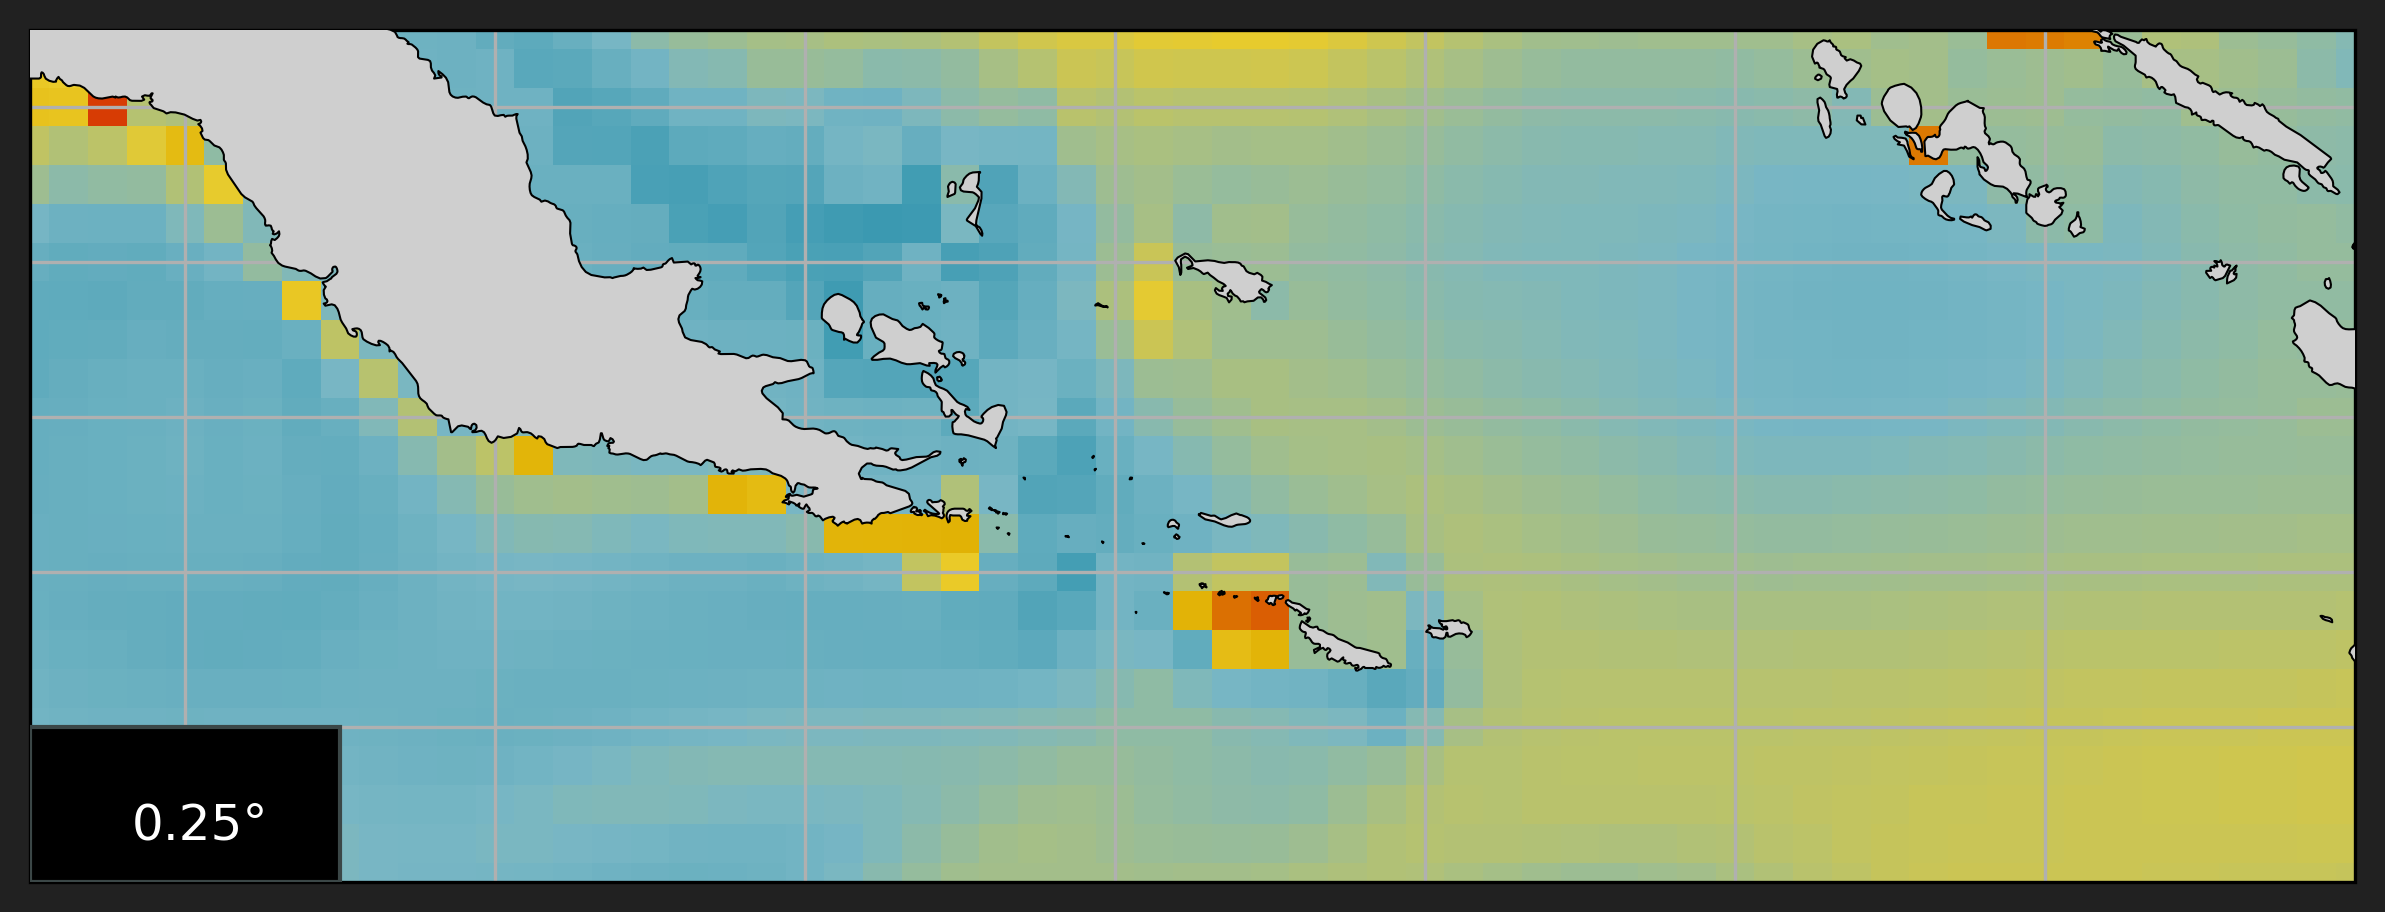

	resampling dataset to 0.1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


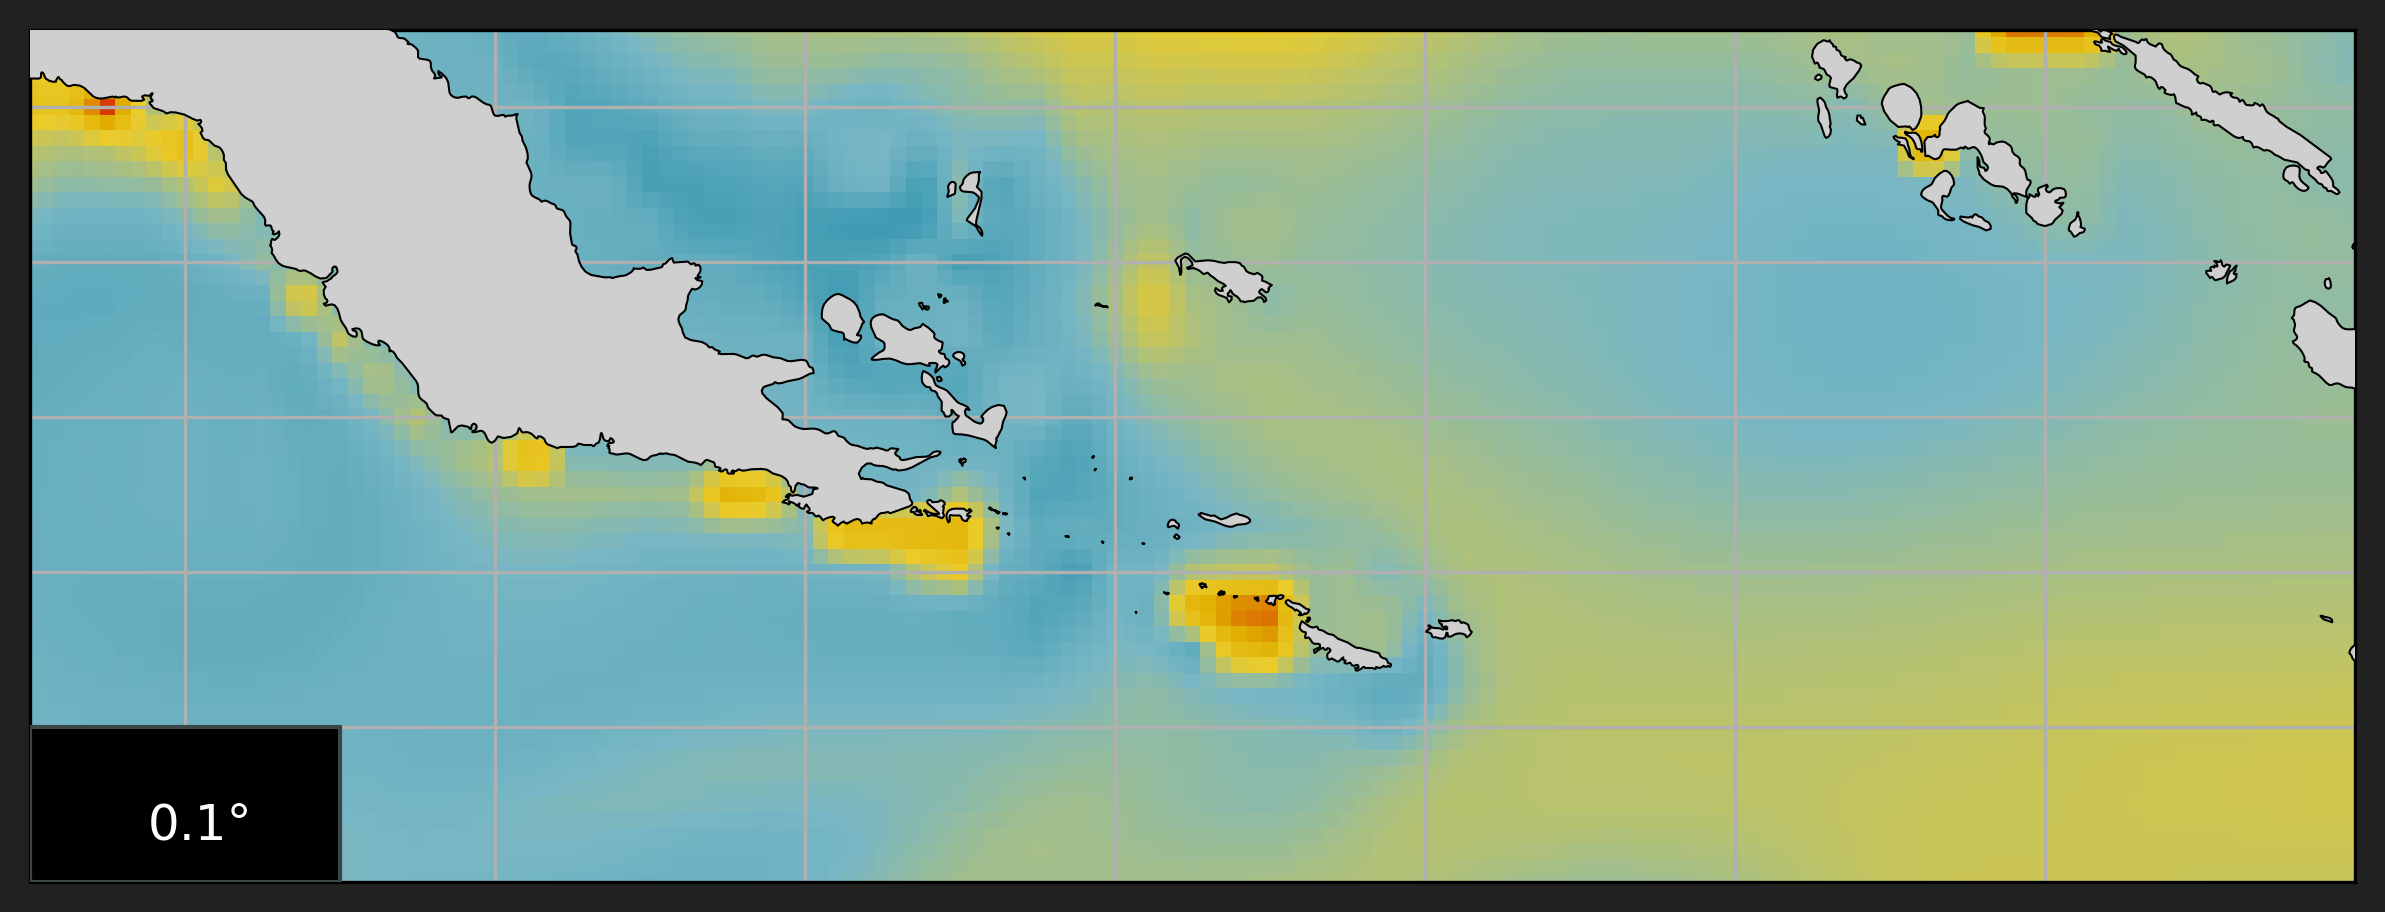

	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


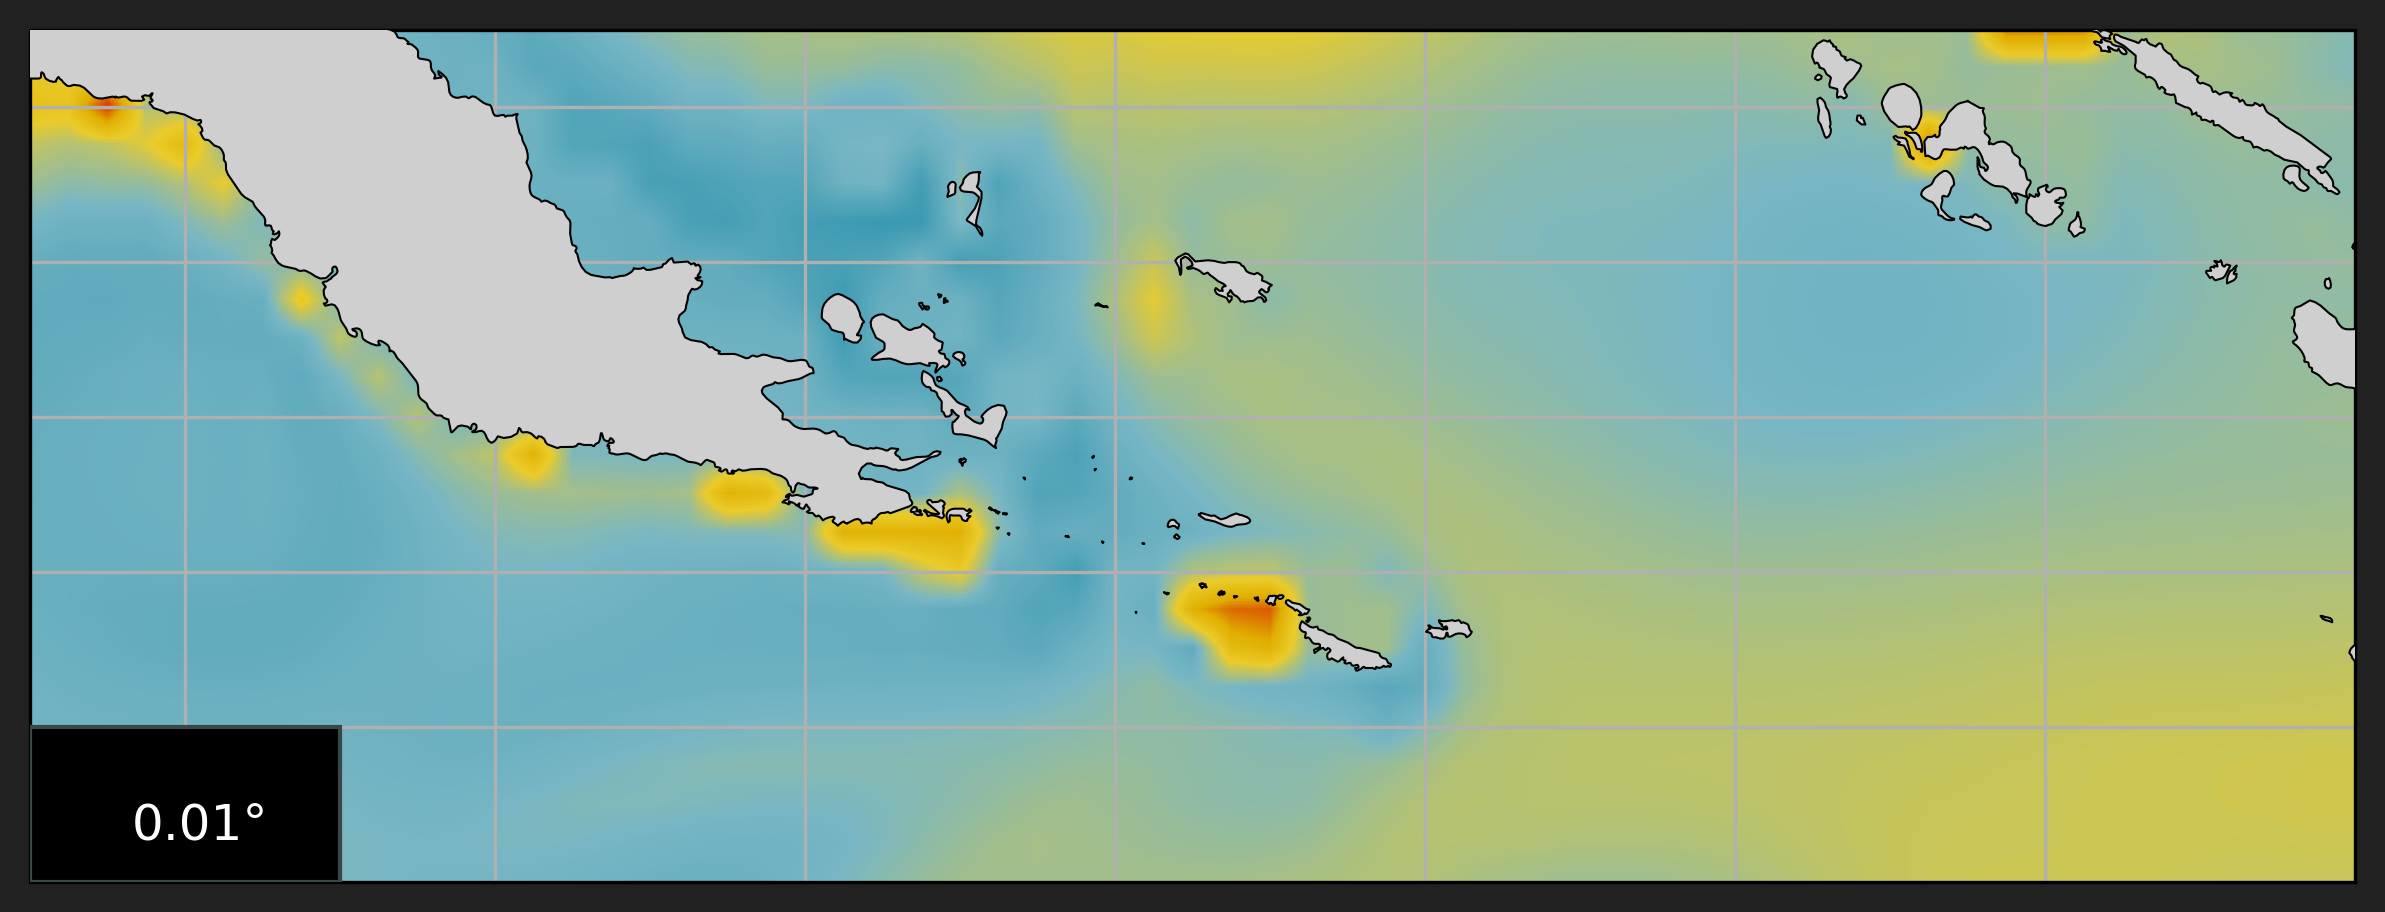

	resampling dataset to 0.004 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


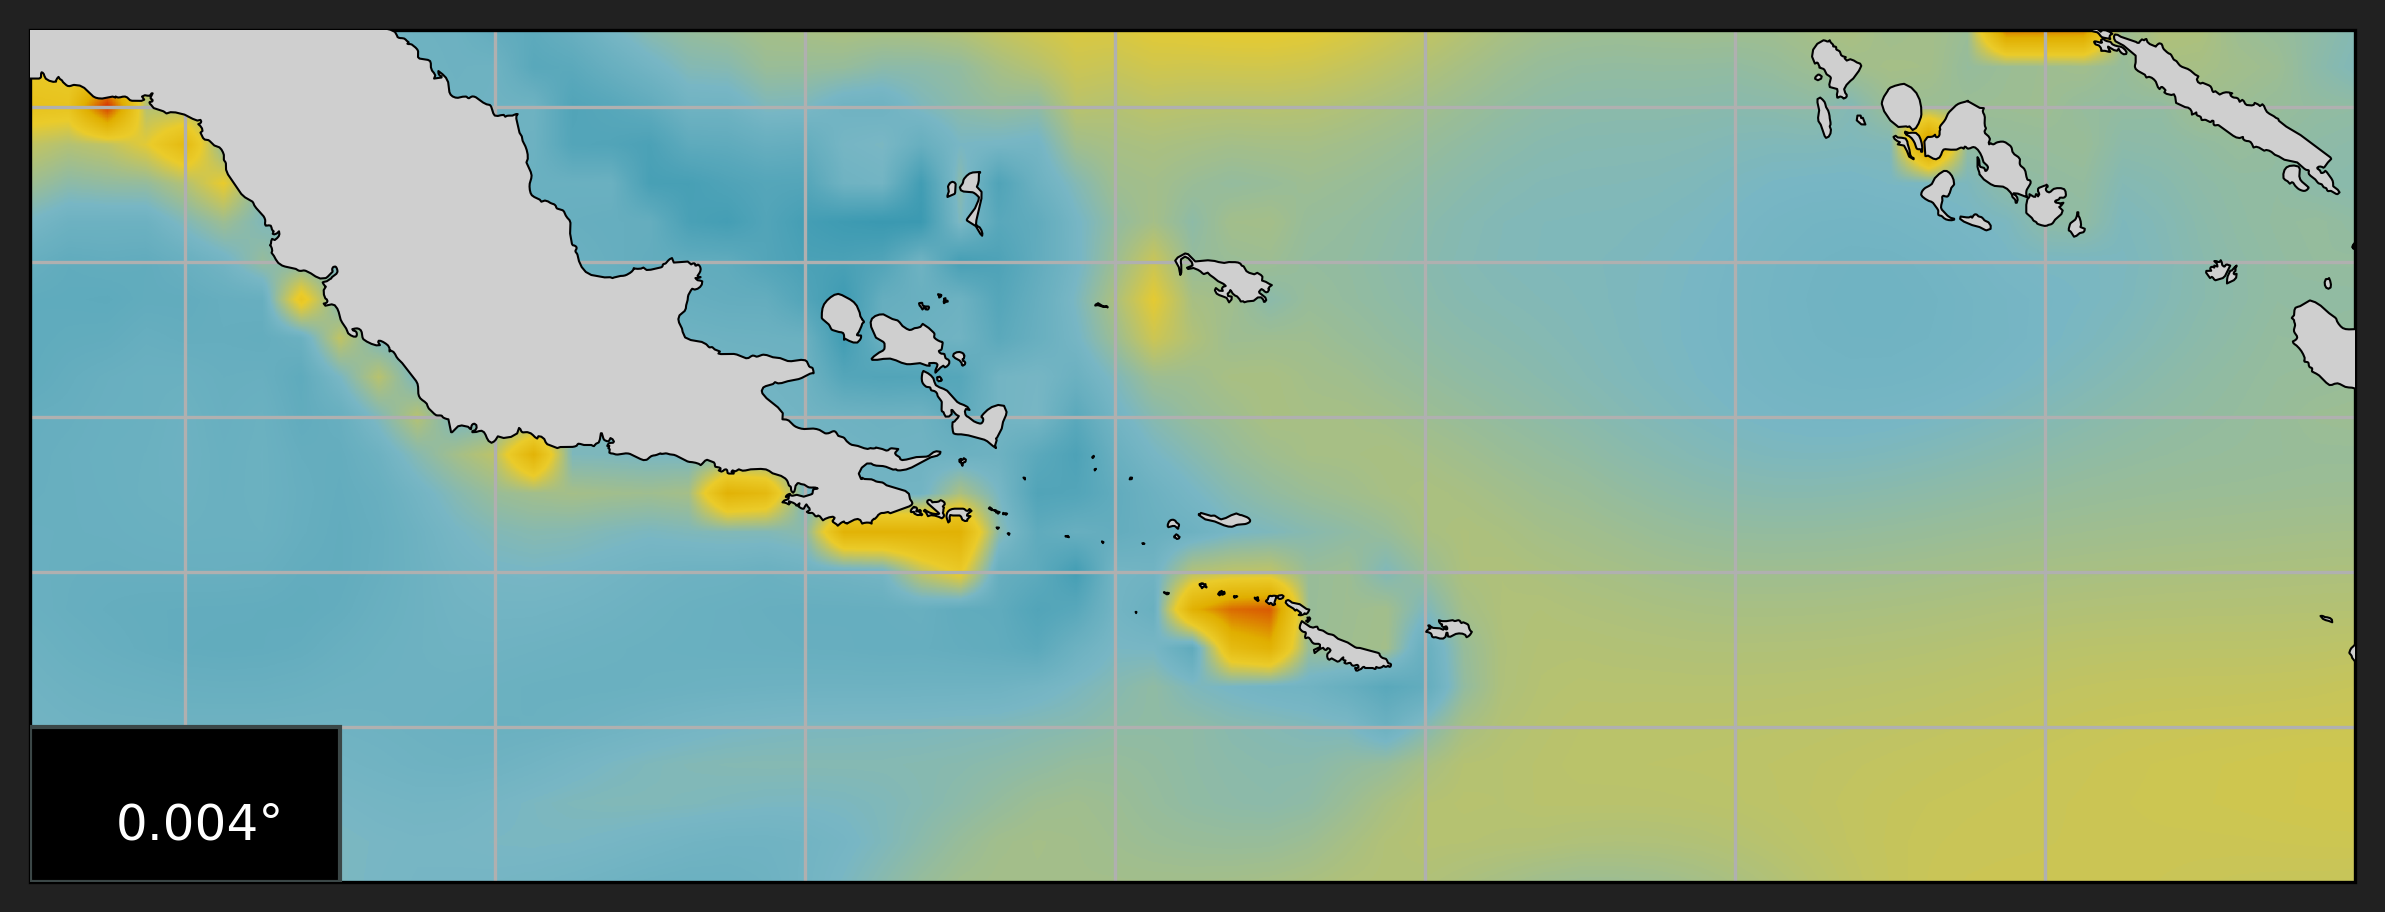

In [8]:
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import cartopy.crs as ccrs


og = buffered.isel(time=0)

config_info["lats"] = [-13,-7.5]
config_info["lons"] = [145, 160] 

# fig, axis = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ims = []
patches = []
texts = []
resolutions = [1, 0.5, 0.25, 0.1, 0.01, 0.004]
for res_i, res in enumerate(resolutions):
    # Clear previous patches and texts
    try:
        [p.remove() for p in ax.patches]
        [t.remove() for t in ax.texts]
    except NameError:
        pass
    
    config_info["resolution"] = res
    resampled_sample = get_data.ReturnRaster(config_info=config_info).get_resampled_raster(og["thetao"])
    f, ax, im = spatial_plots.plot_spatial(
        resampled_sample, presentation_format=True, cbar_dict={"cbar": False}, title="", labels=[], val_lims = [23.054327, 29.981606])
    ax.set_extent([145, 160, -13, -7.5])
    # plot a black rectangle with white text
    rect = mpatches.Rectangle(xy=[145, -13], width=2, height=1,
                                    facecolor='black', edgecolor='#3b4747',
                                    transform=ccrs.PlateCarree(), zorder=10)

    ax.add_patch(rect)
    text = ax.text(0.073, 0.05, f"{res}°", ha="center", transform=ax.transAxes, color="white", fontsize=12, zorder=11)
    
    # save figure

    plt.savefig(f"/maps/rt582/coralshift/runs/figures/resolution_{res_i}.png")
    

    ims.append([im, rect, text])
    plt.show()


	resampling dataset to 0.004 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


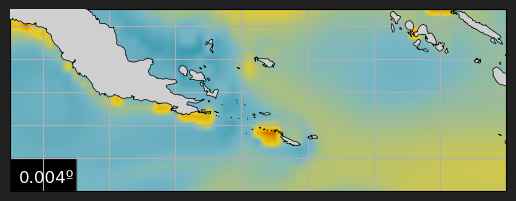

	resampling dataset to 0.01 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
	resampling dataset to 0.05 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
	resampling dataset to 0.1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
	resampling dataset to 0.25 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
	resampling dataset to 0.5 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
	resampling dataset to 0.75 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
	resampling dataset to 1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


In [39]:
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import cartopy.crs as ccrs


og = buffered.isel(time=0)

config_info["lats"] = [-13,-7.5]
config_info["lons"] = [145, 160] 

fig, axis = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ims = []
patches = []
texts = []
resolutions = [1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01, 0.004]
for res_i, res in enumerate(resolutions[::-1]):
    # Clear previous patches and texts
    [p.remove() for p in ax.patches]
    [t.remove() for t in ax.texts]

    config_info["resolution"] = res
    resampled_sample = get_data.ReturnRaster(config_info=config_info).get_resampled_raster(og["thetao"])
    f, ax, im = spatial_plots.plot_spatial(
        resampled_sample, fax=(fig, axis), presentation_format=True, cbar_dict={"cbar": False}, title="", labels=[], val_lims = [23.054327, 29.981606])
    ax.set_extent([145, 160, -13, -7.5])
    # plot a black rectangle with white text
    rect = mpatches.Rectangle(xy=[145, -13], width=2, height=1,
                                    facecolor='black', edgecolor='#3b4747',
                                    transform=ccrs.PlateCarree(), zorder=1)

    ax.add_patch(rect)
    text = ax.text(0.018, 0.05, f"{res}º", transform=ax.transAxes, color="white", fontsize=12, zorder=2)

    ims.append([im, rect, text])
    plt.show()


In [38]:
ims[7]

 Text(0.018, 0.05, '1º')]

In [56]:
ani = animation.ArtistAnimation(fig, ims, interval=1e3, blit=True,
                                repeat_delay=5e3)

AttributeError: 'NoneType' object has no attribute 'canvas'

In [ ]:
ani.save("movie.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


# Results

	Running inference on 428480 datapoints...
Saving trains_metrics to /maps-priv/maps/rt582/coralshift/runs/0-01d/xgb_reg/ID021_cmip6_unep_gebco_slope/ID021_cmip6_unep_gebco_slope_CONFIG.yaml...
	Running inference on 437152 datapoints...
Saving tests_metrics to /maps-priv/maps/rt582/coralshift/runs/0-01d/xgb_reg/ID021_cmip6_unep_gebco_slope/ID021_cmip6_unep_gebco_slope_CONFIG.yaml...
	Running inference on 437152 datapoints...
Saving vals_metrics to /maps-priv/maps/rt582/coralshift/runs/0-01d/xgb_reg/ID021_cmip6_unep_gebco_slope/ID021_cmip6_unep_gebco_slope_CONFIG.yaml...


/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


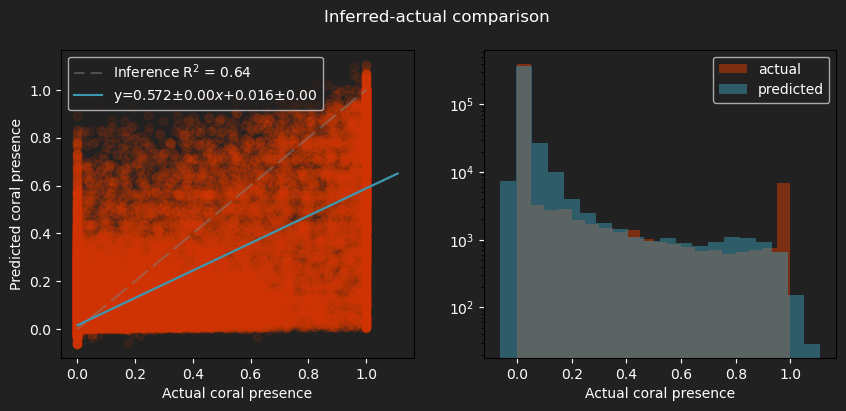

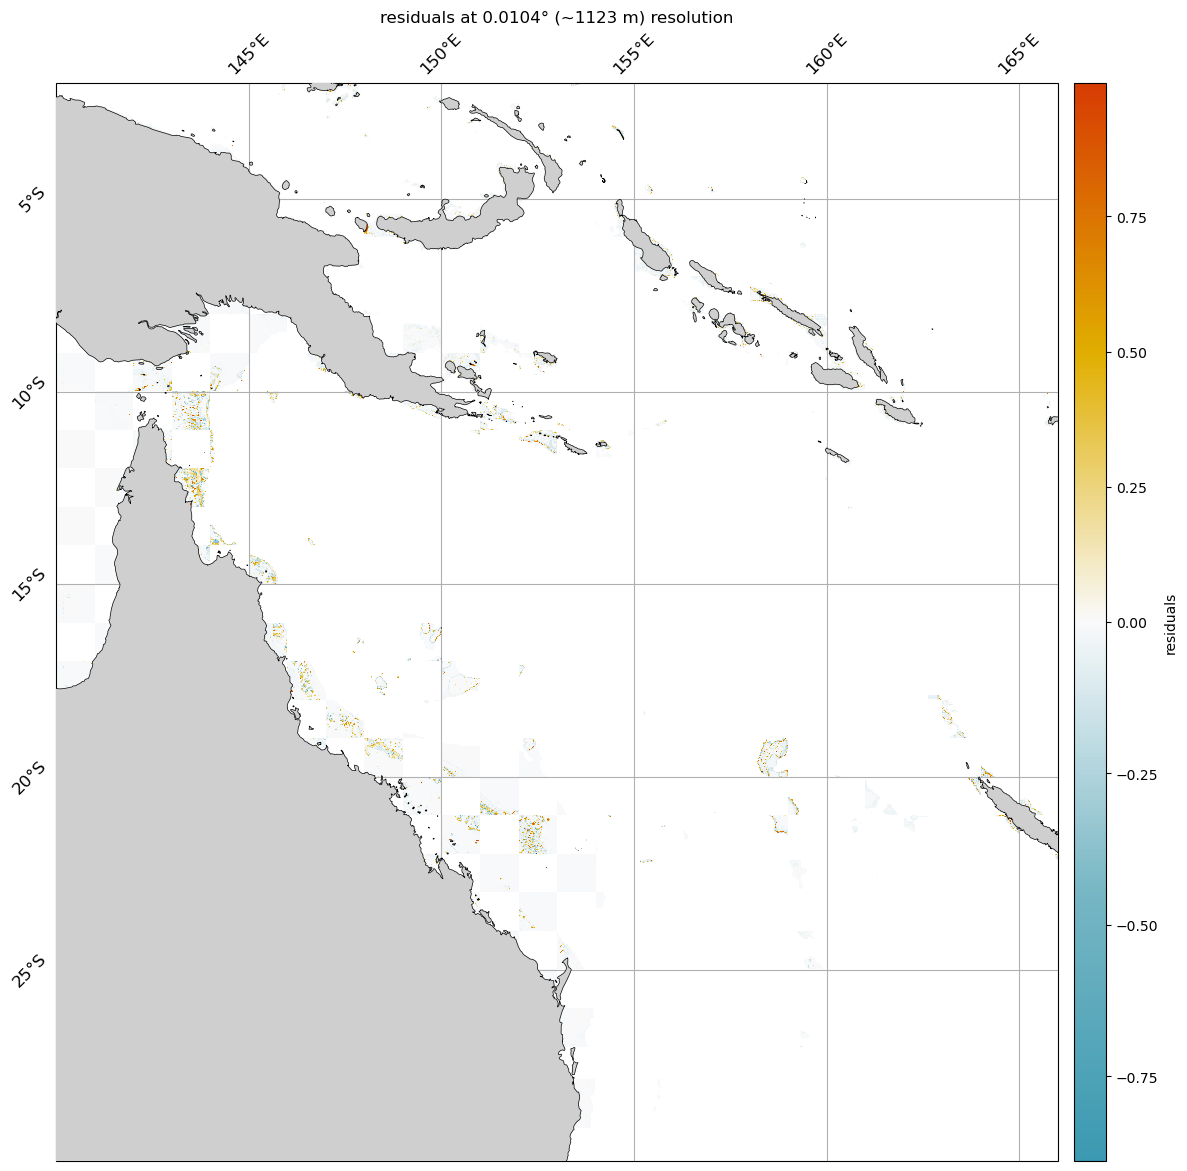

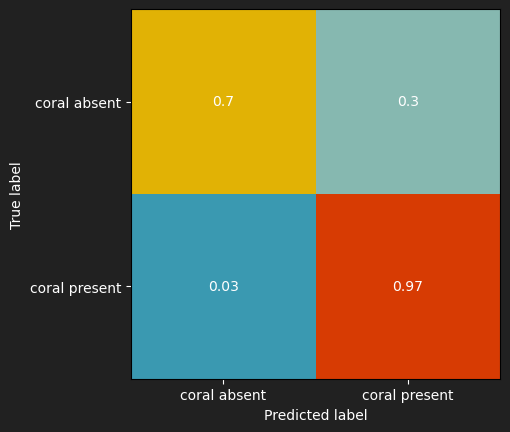

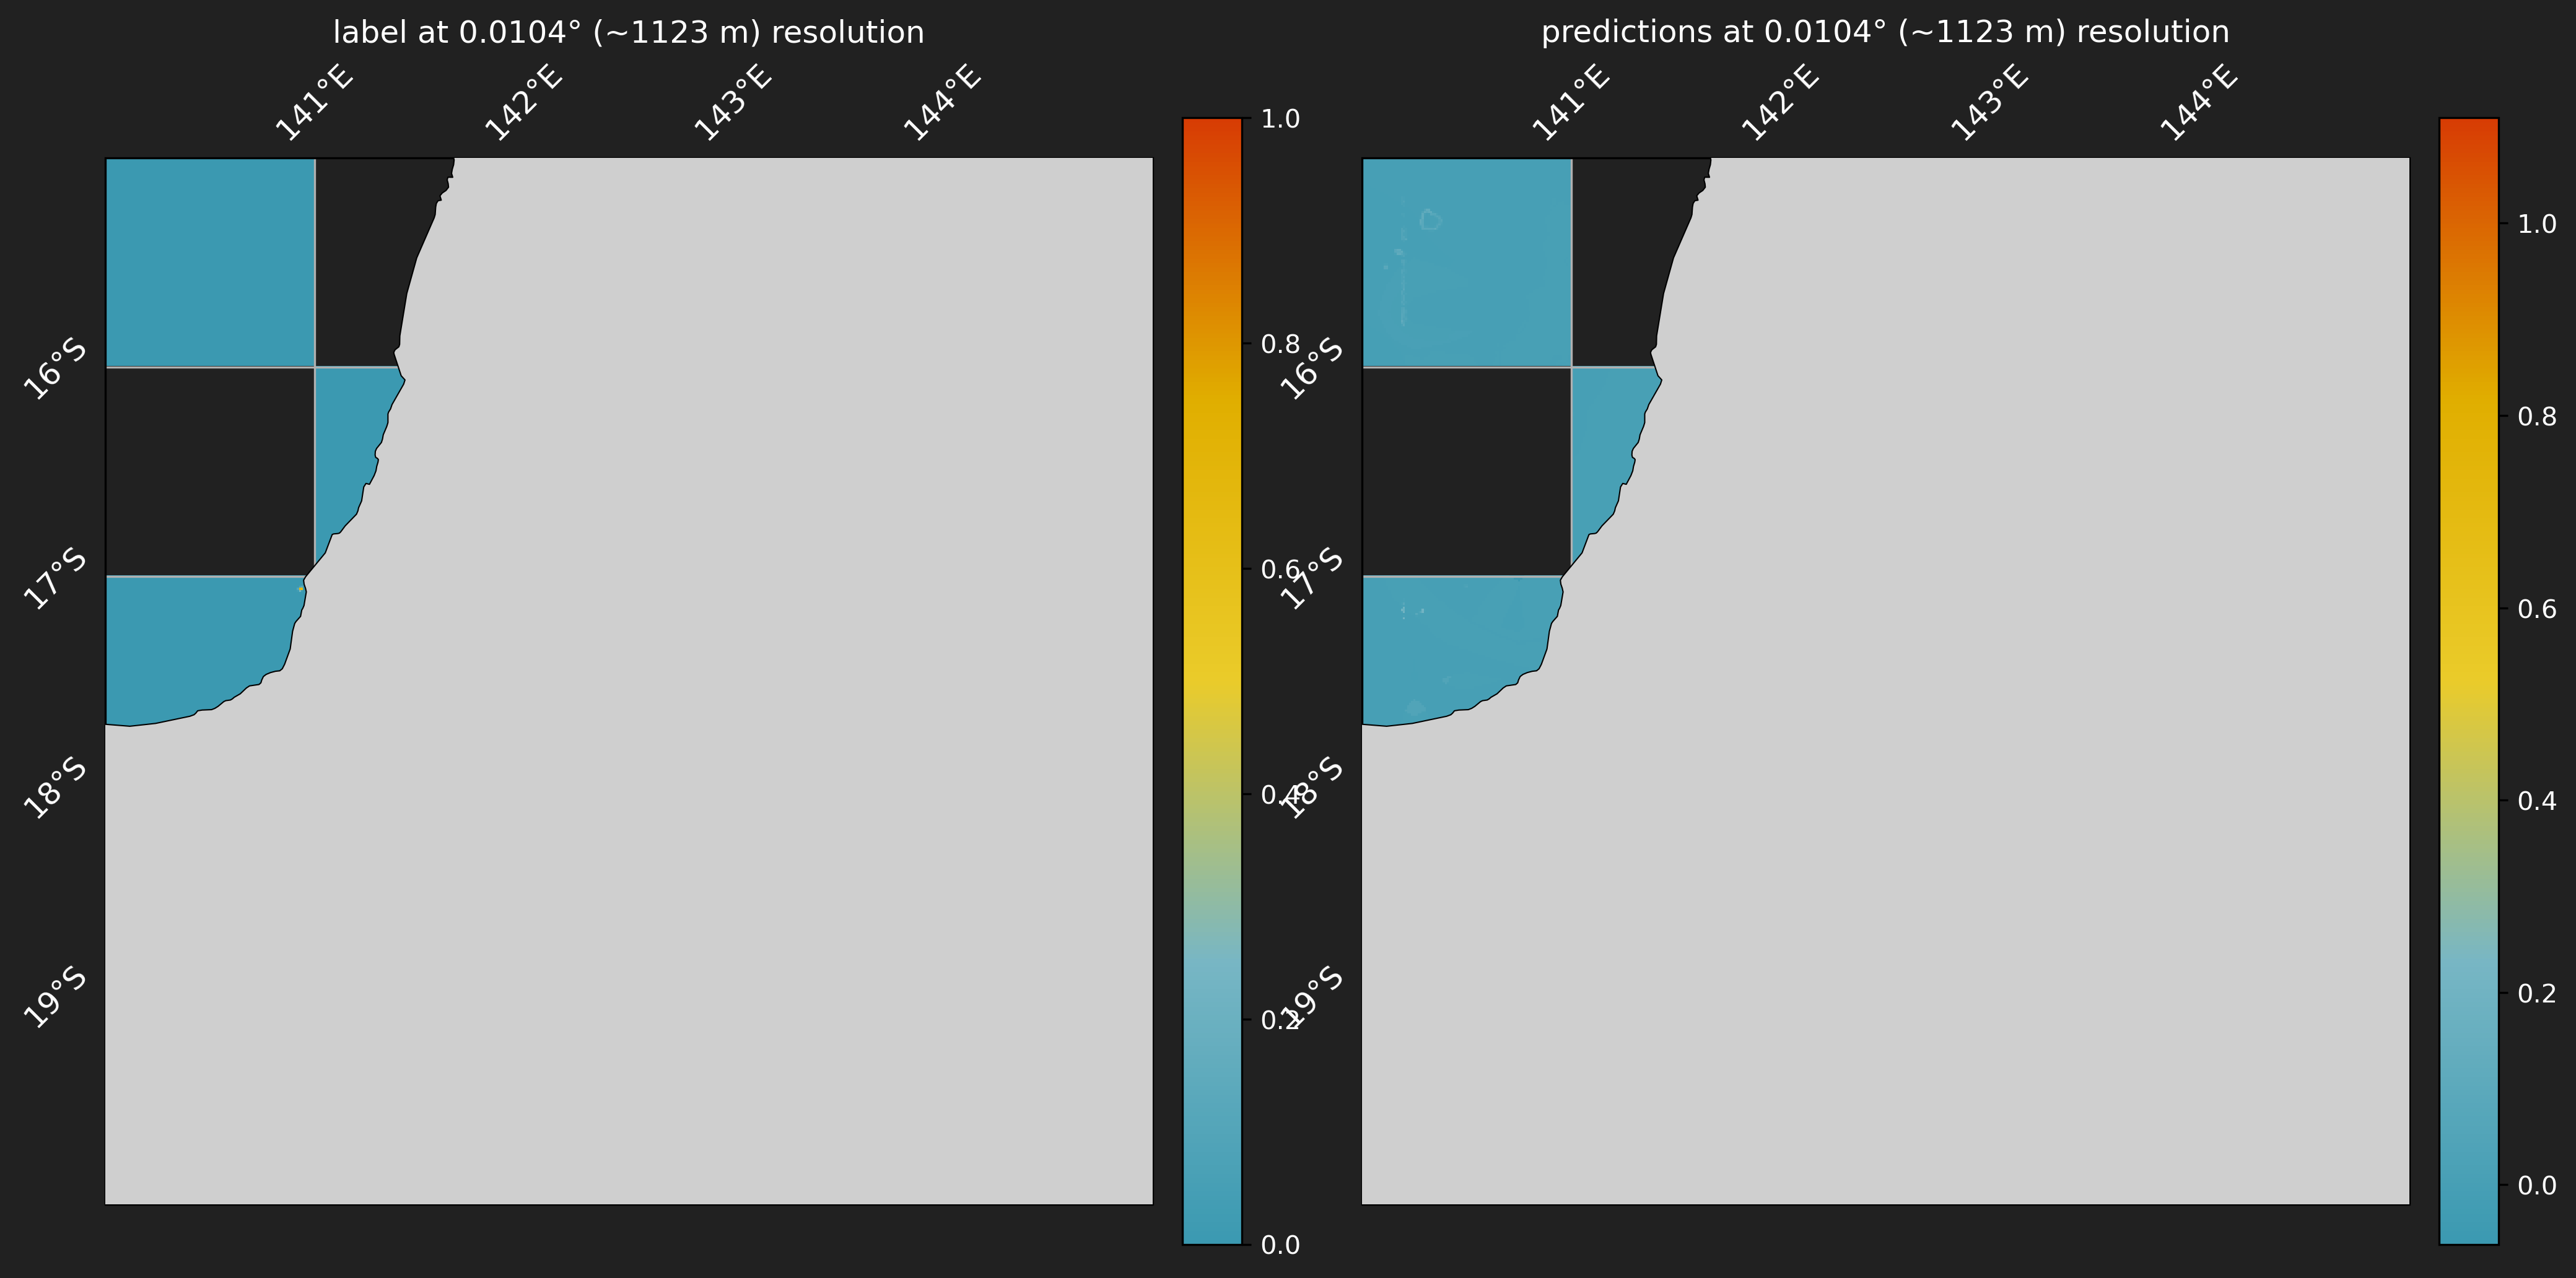

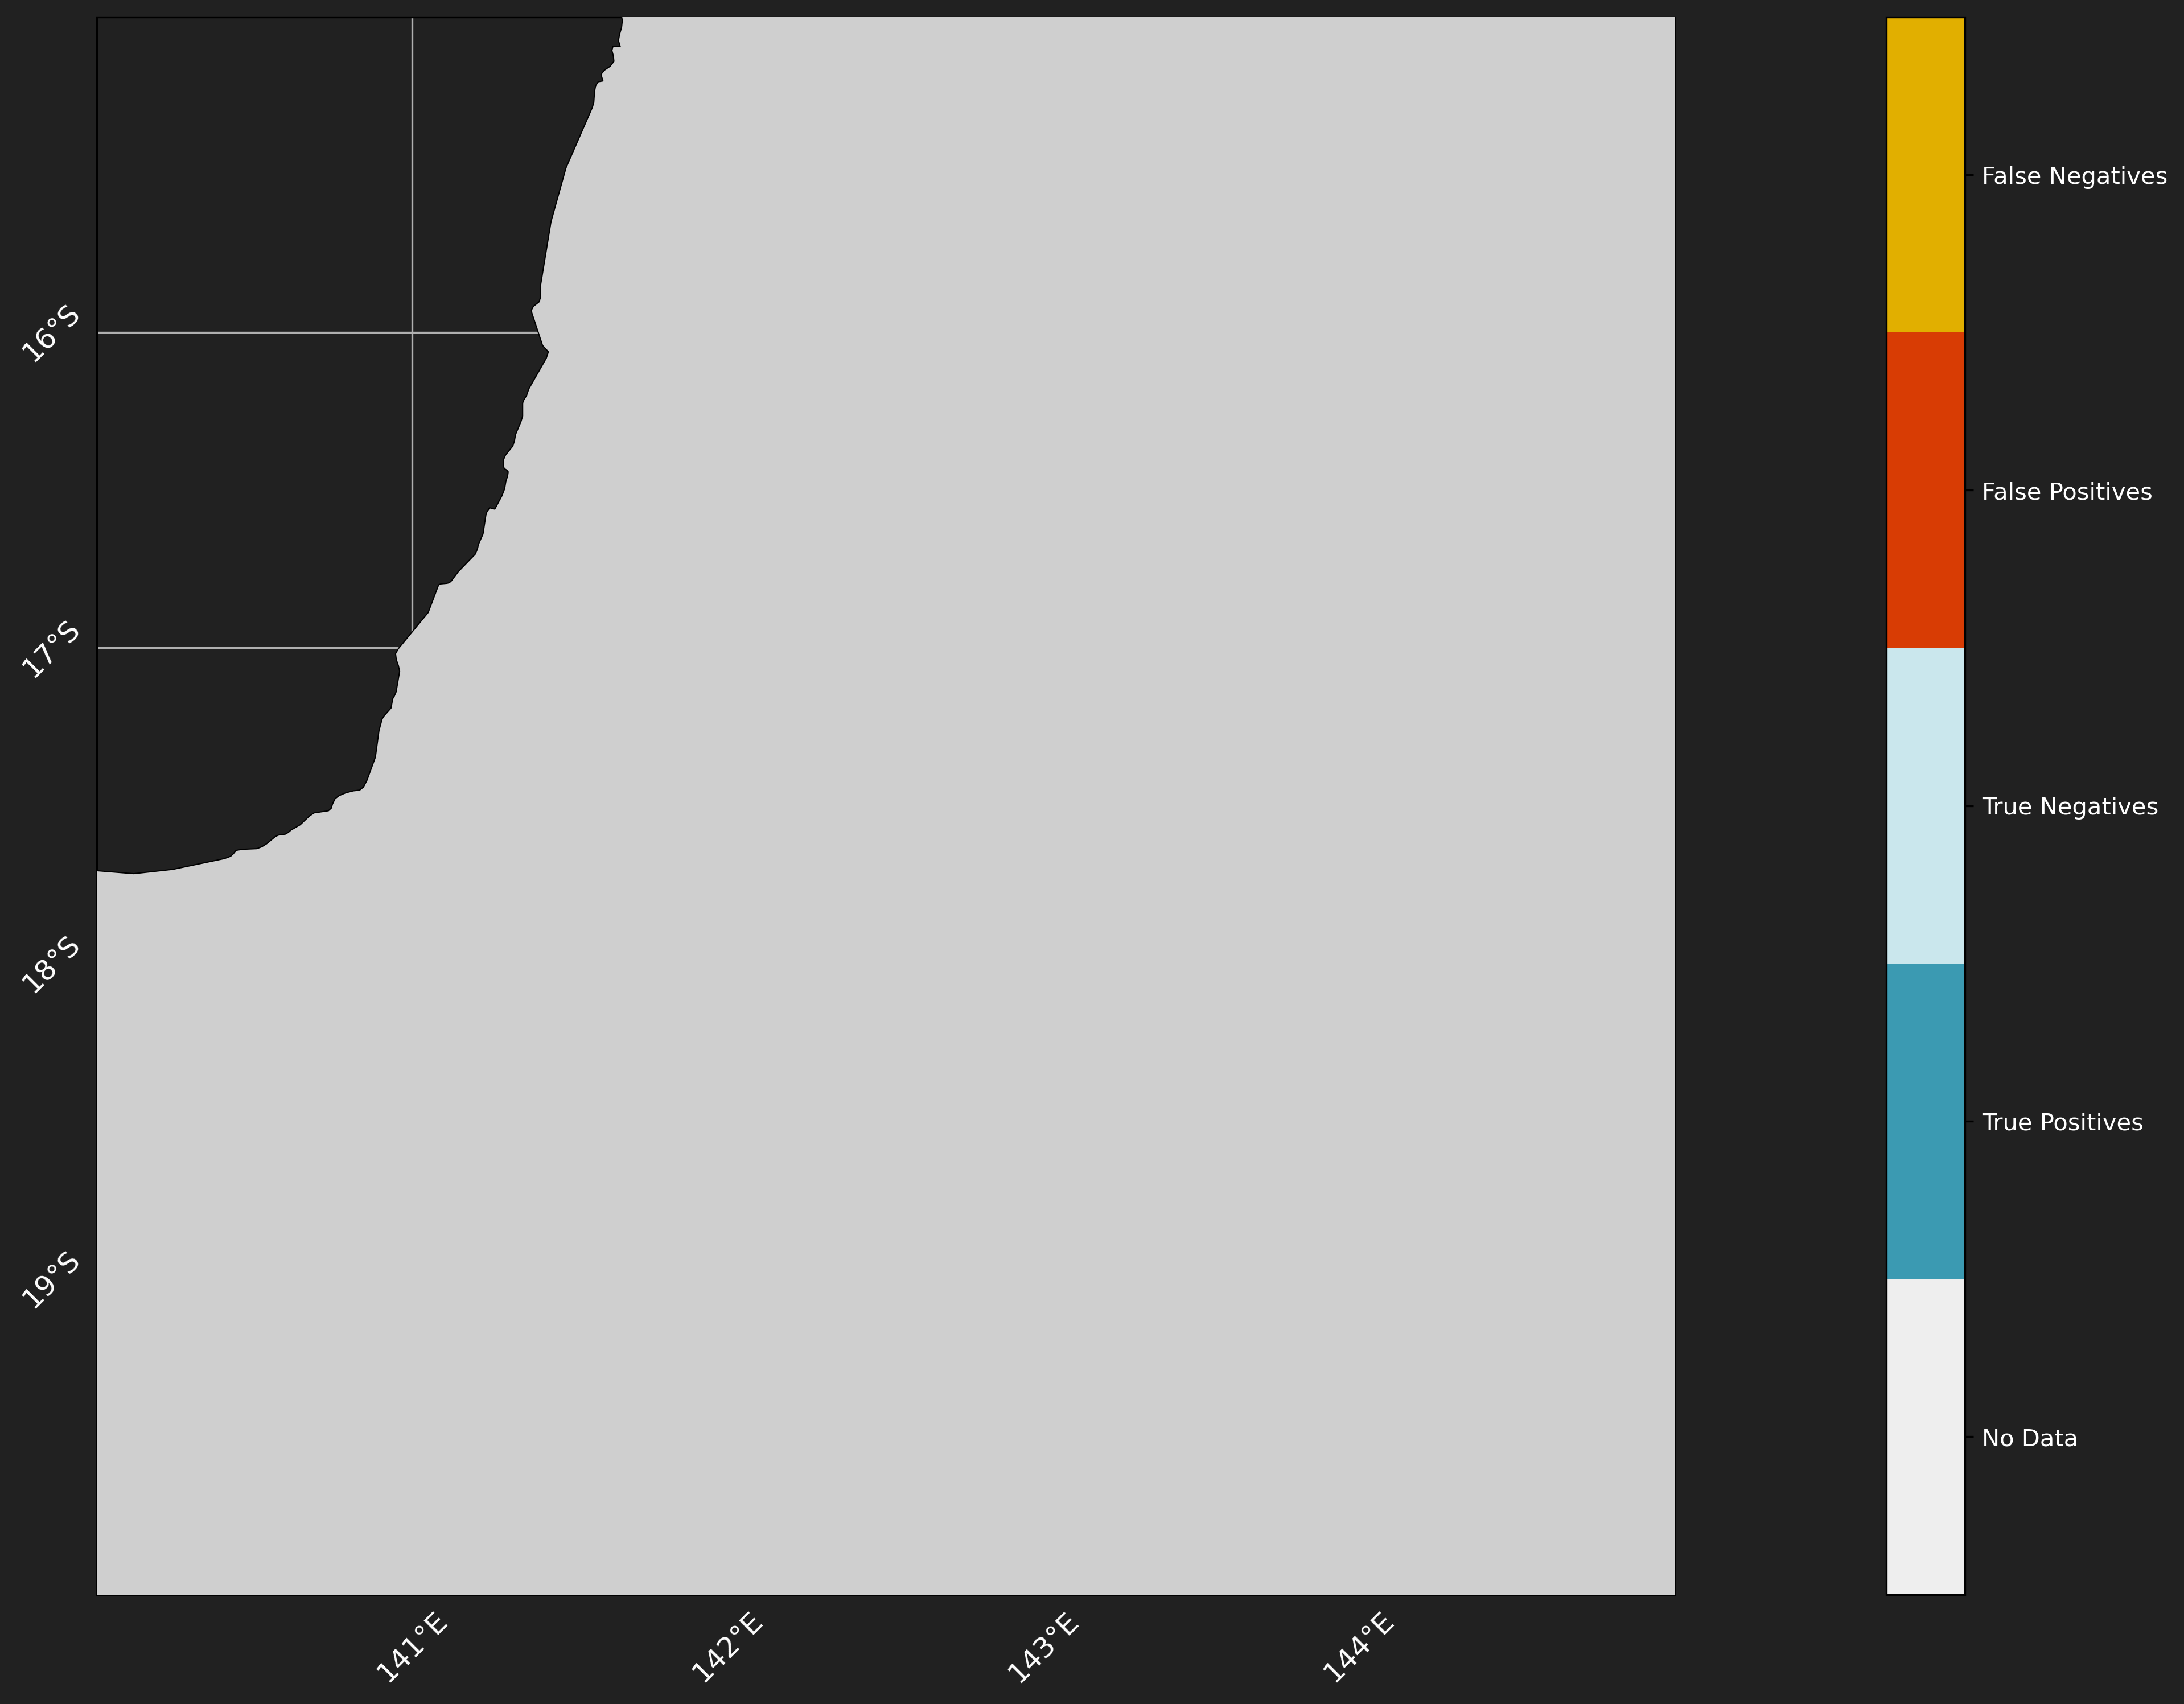

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


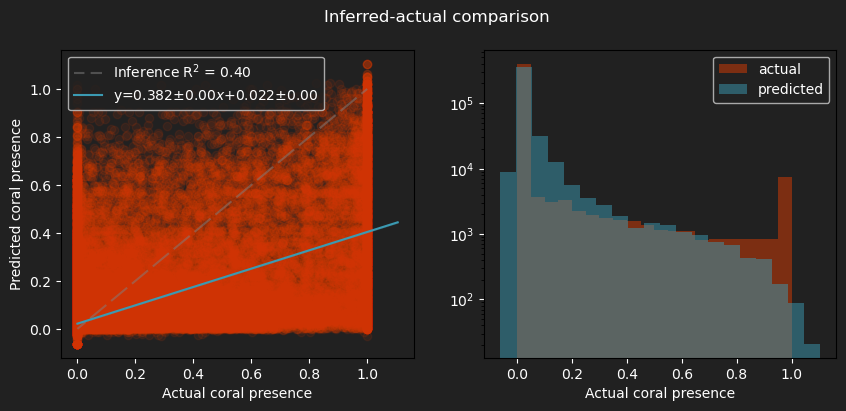

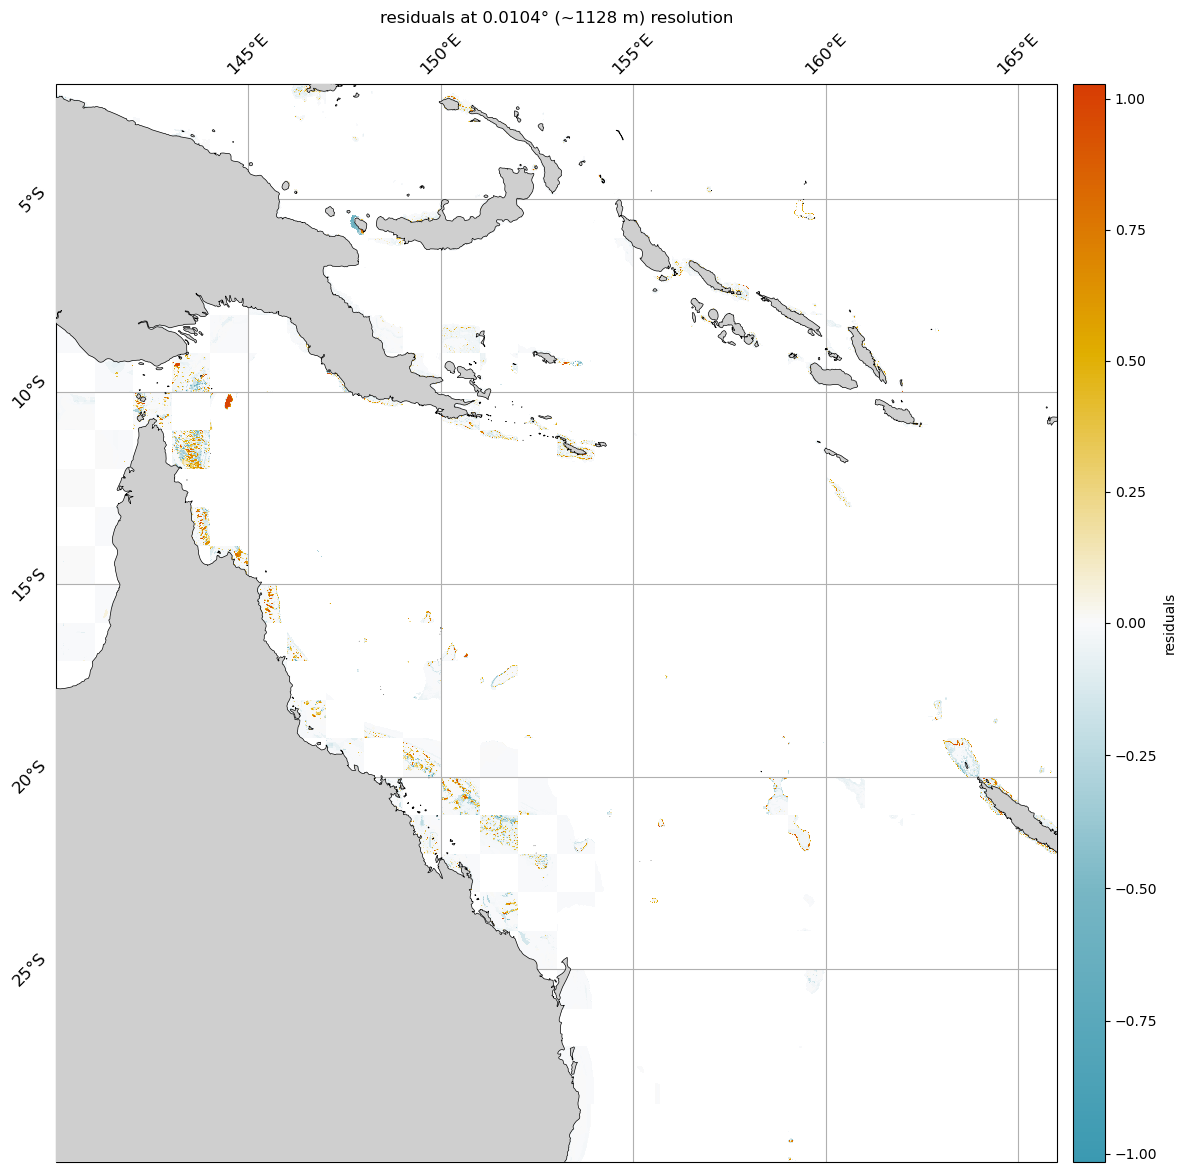

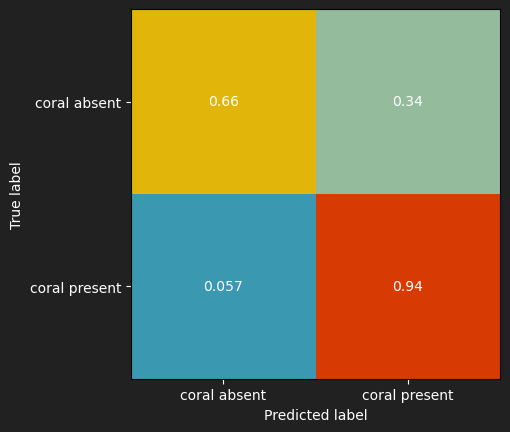

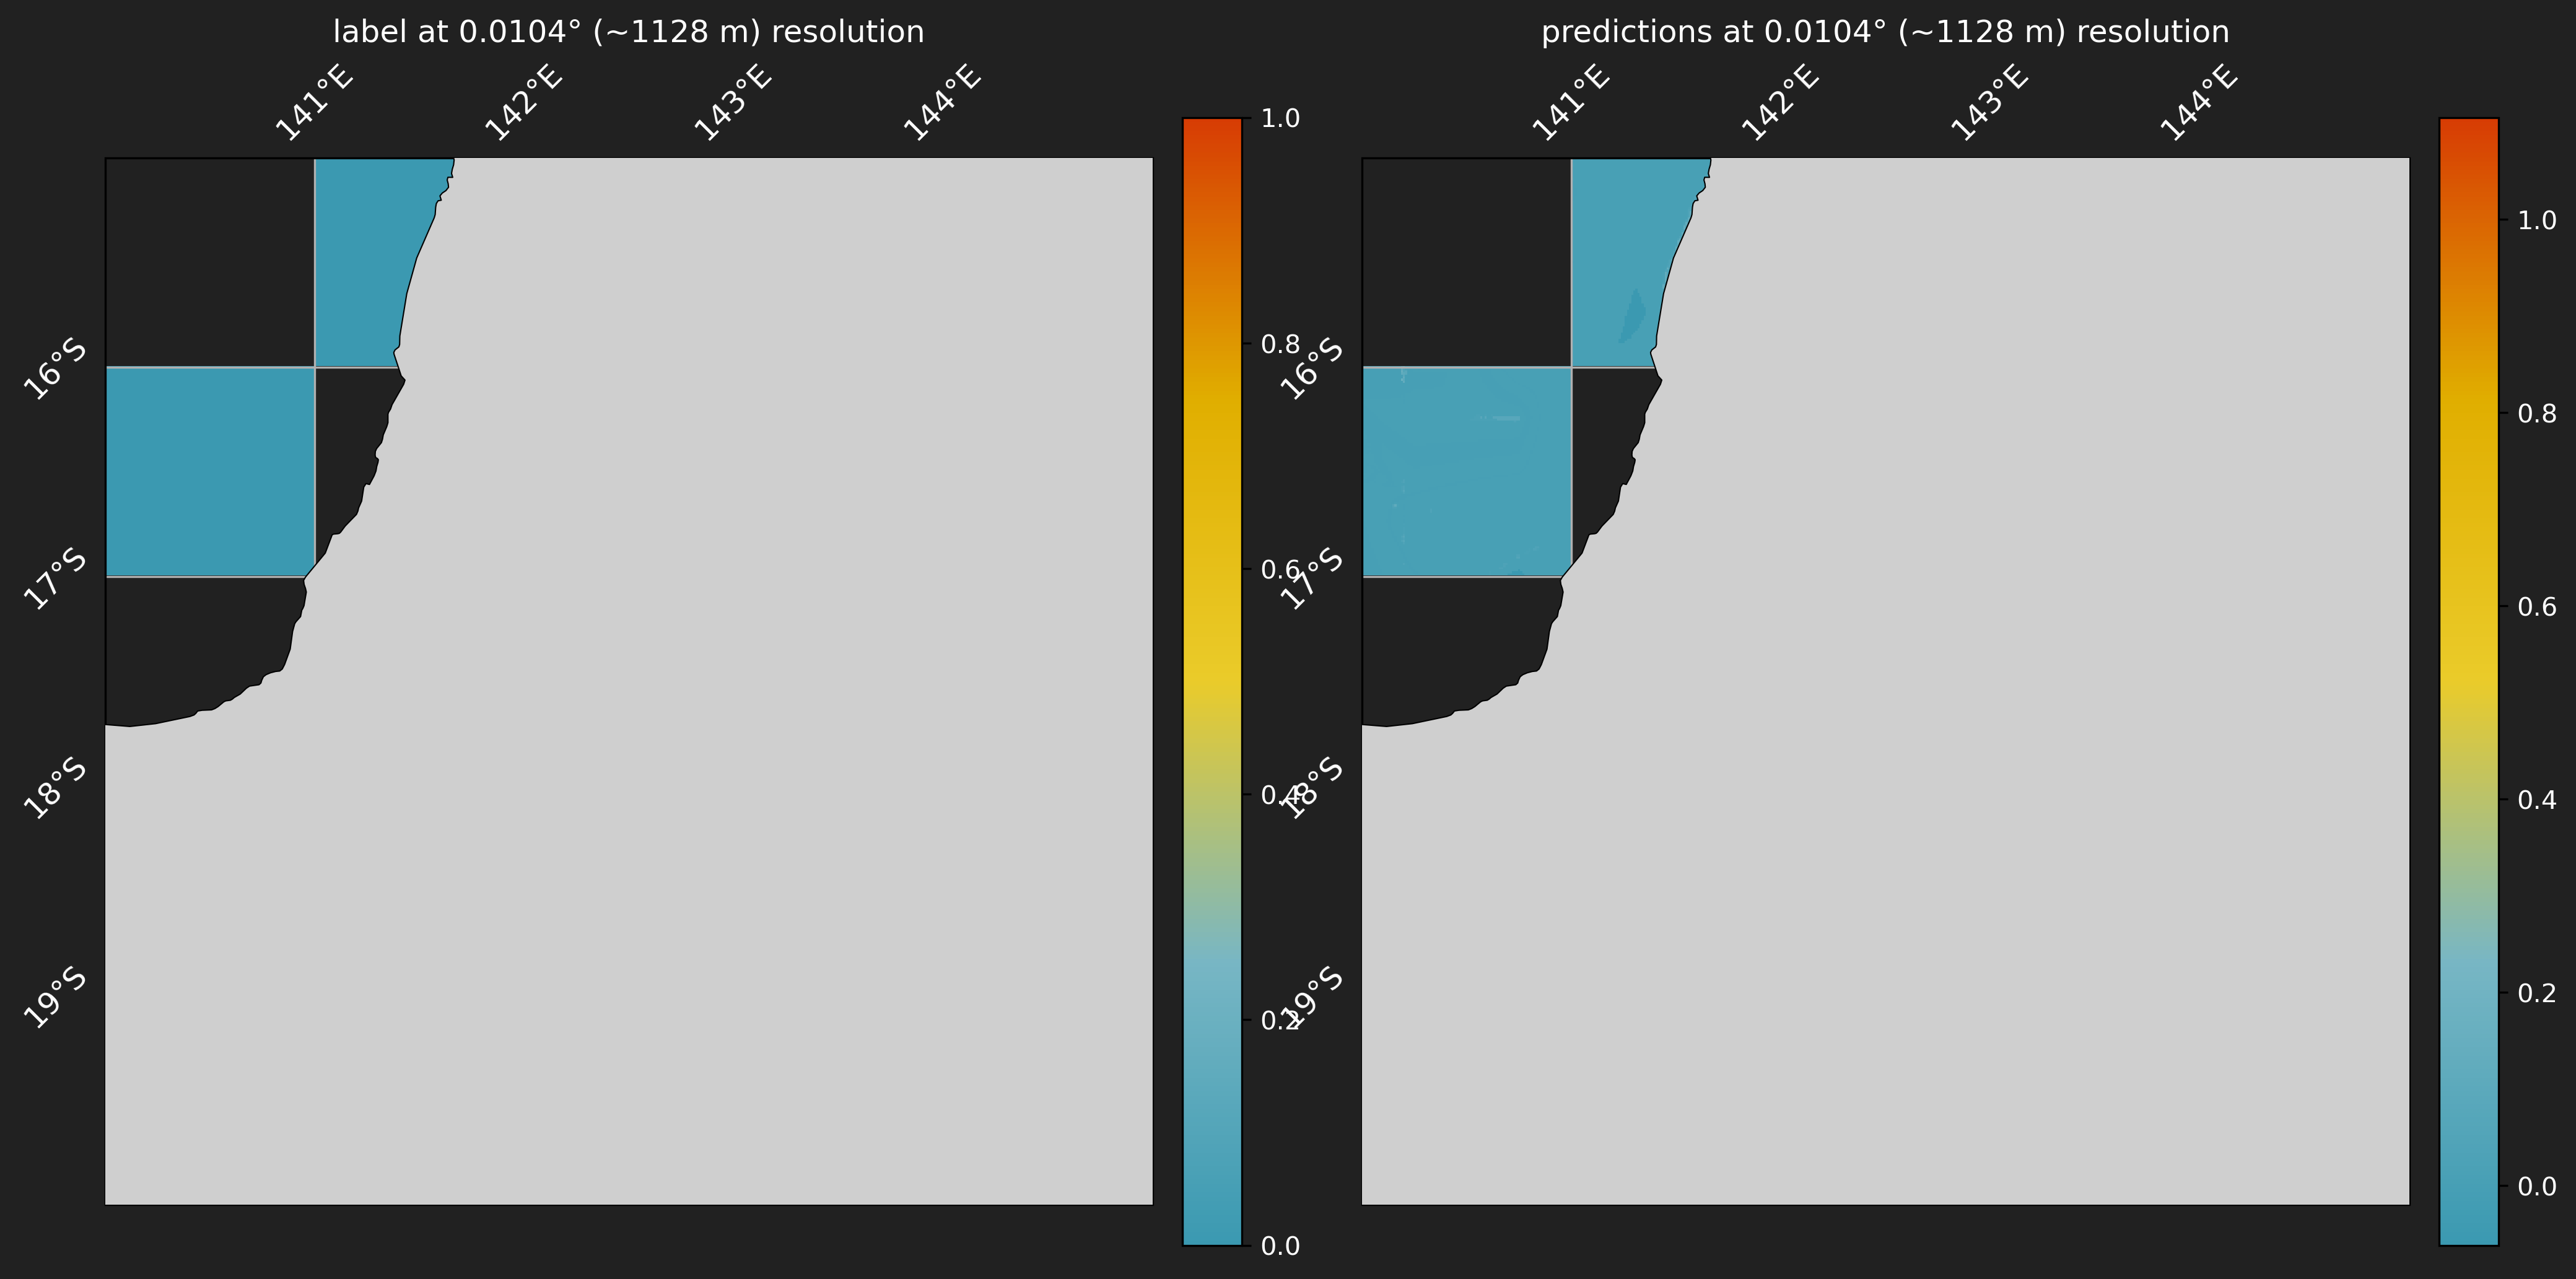

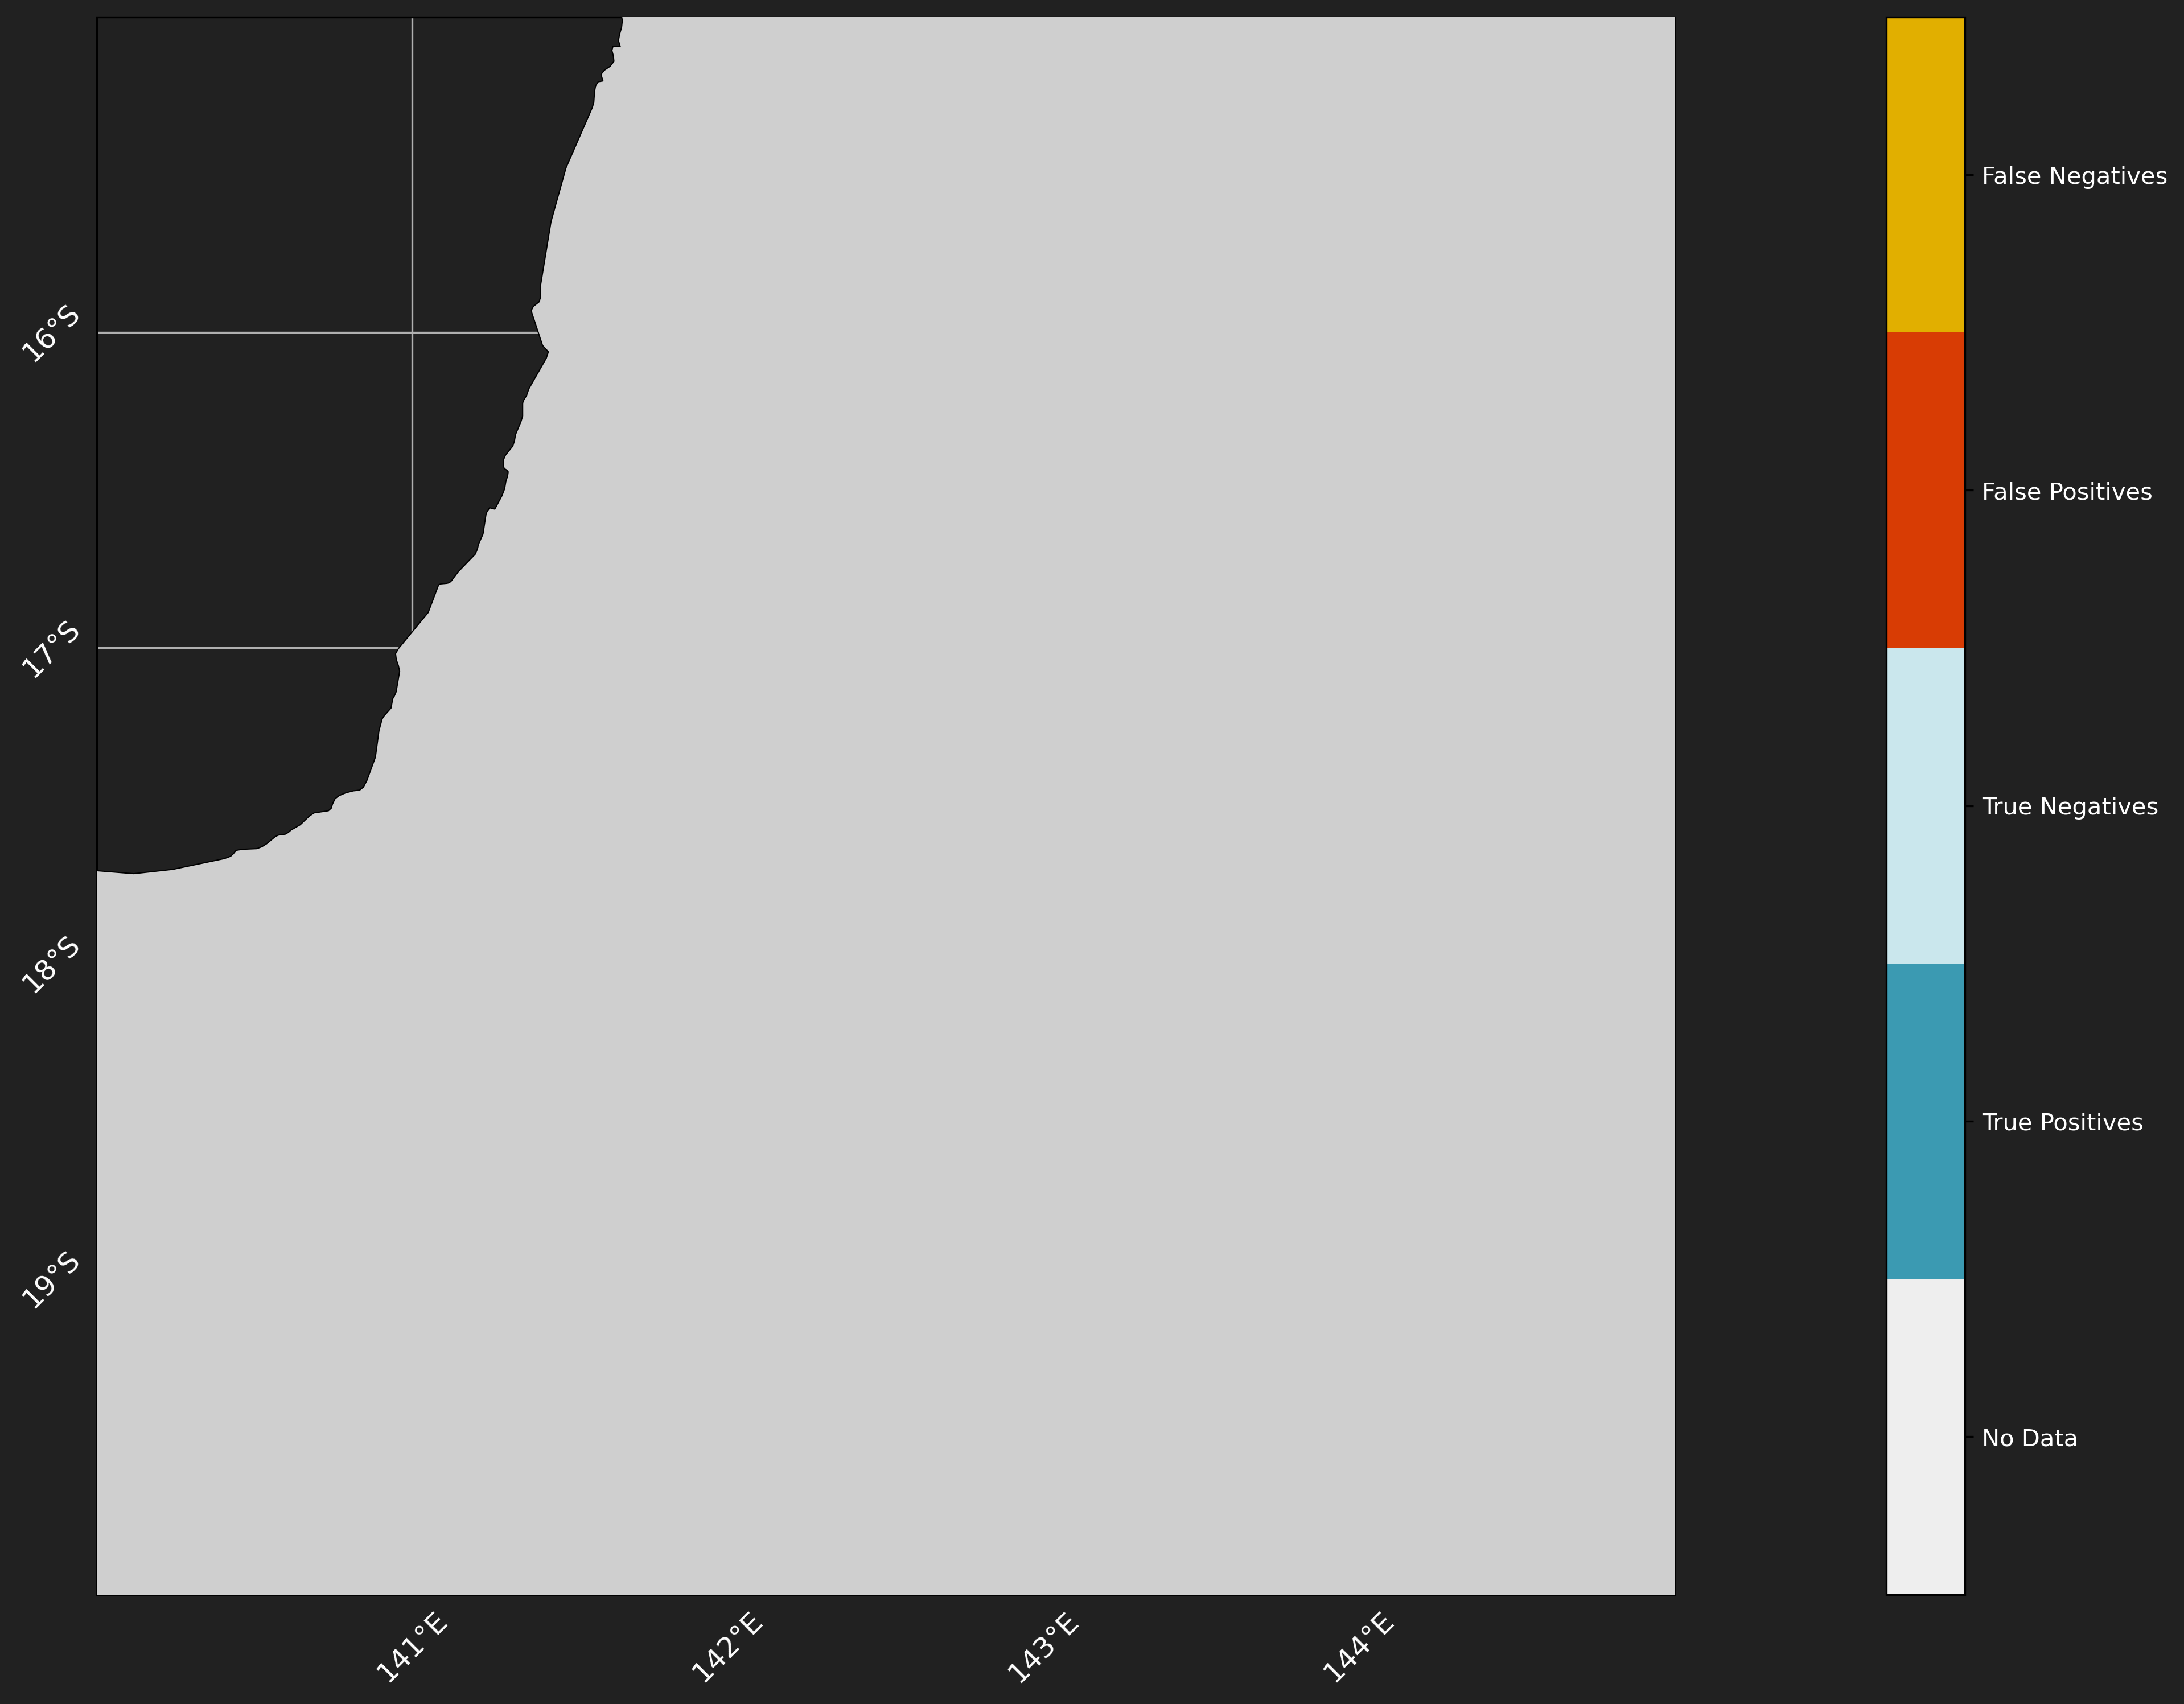

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


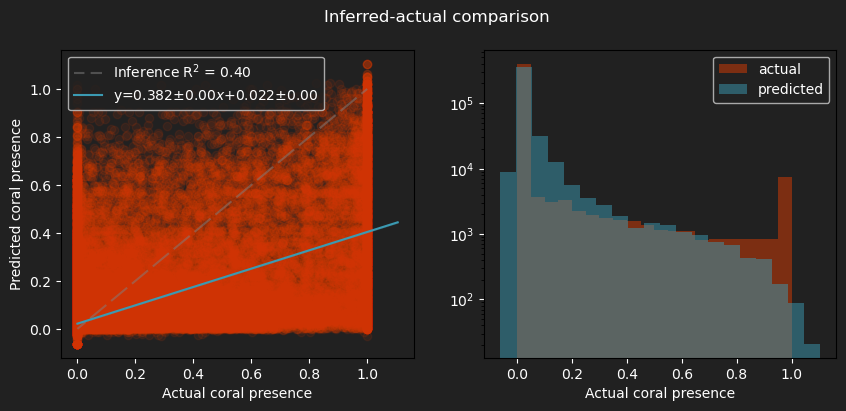

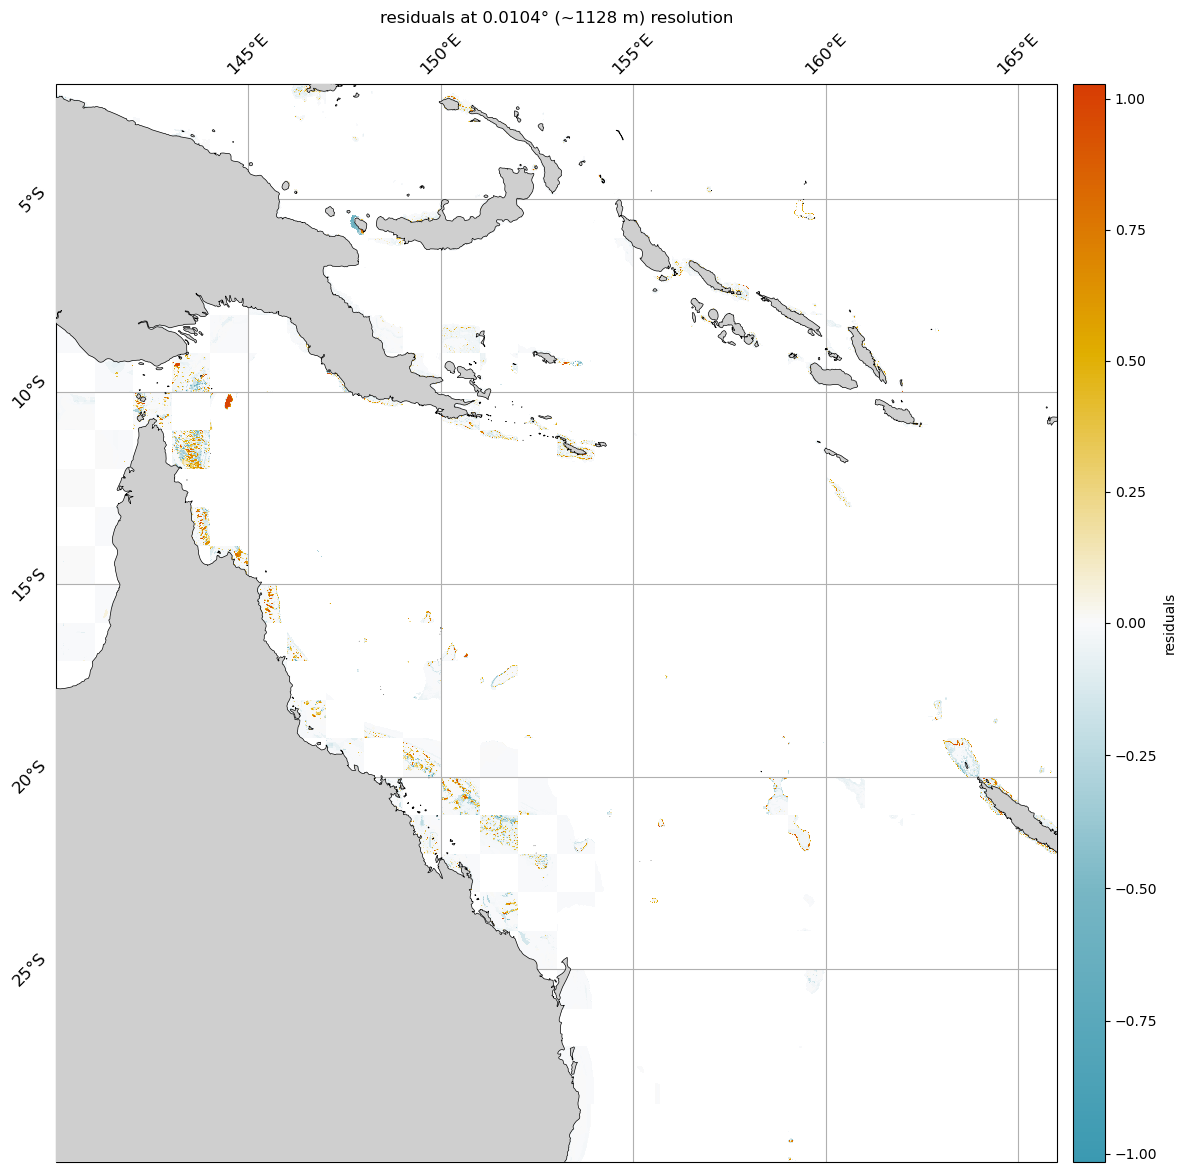

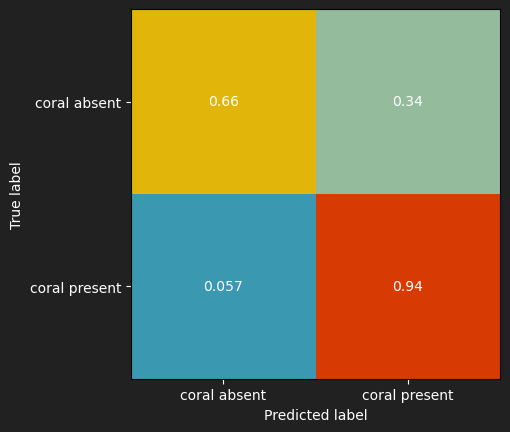

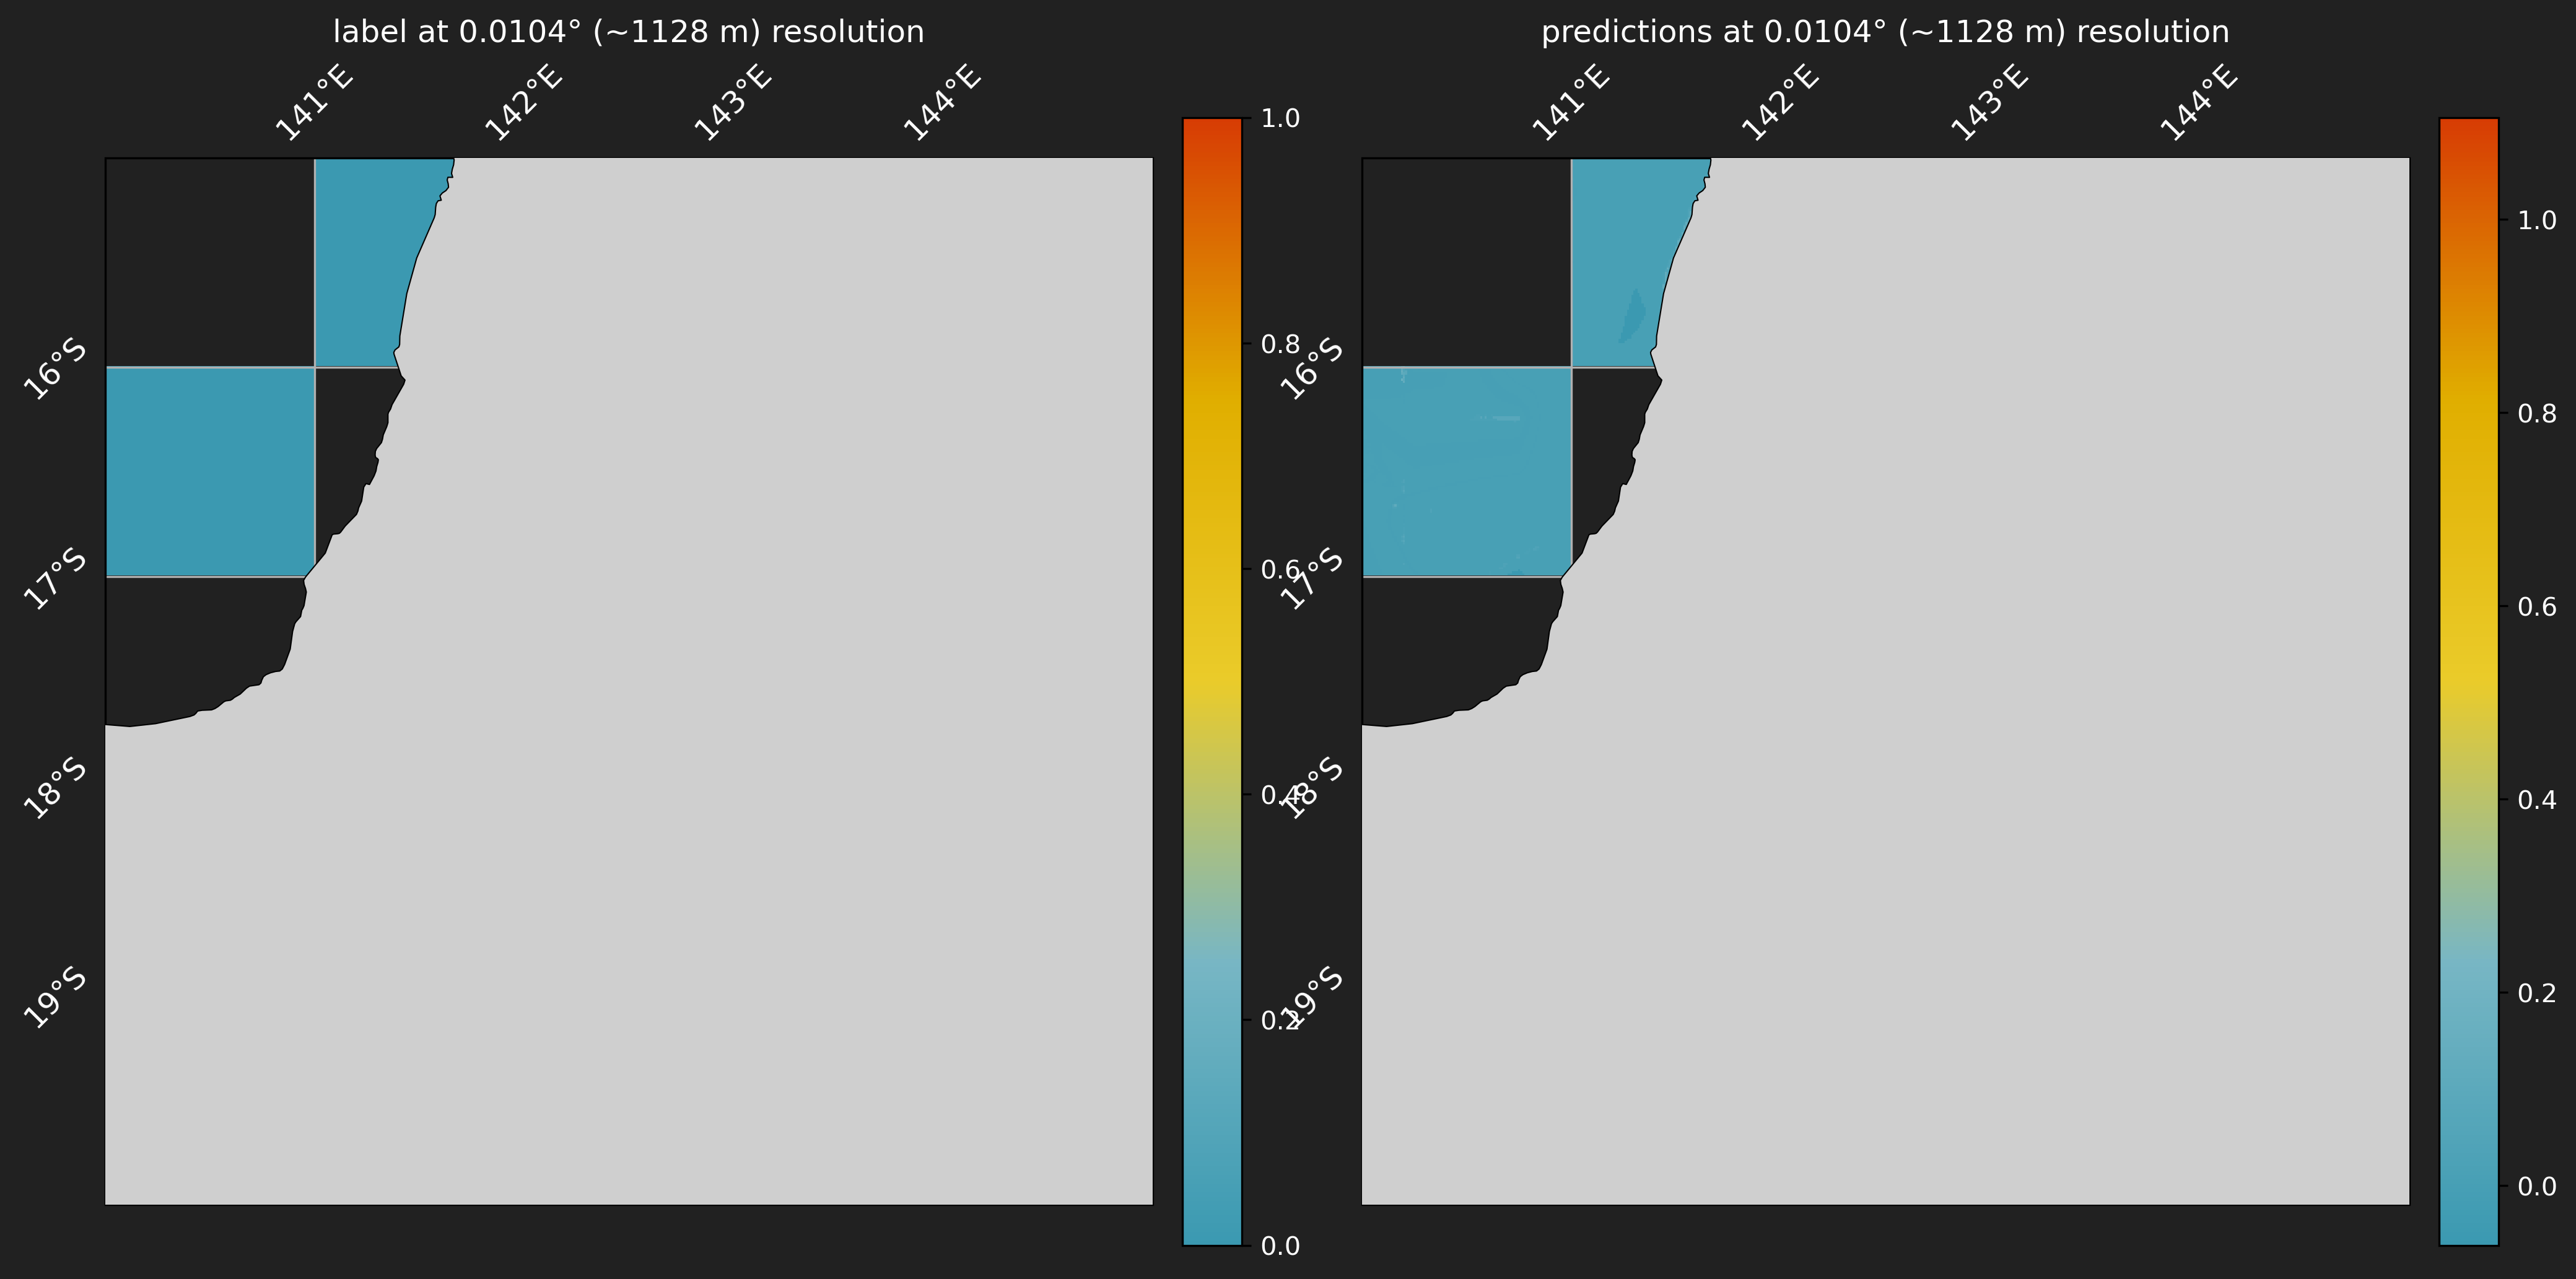

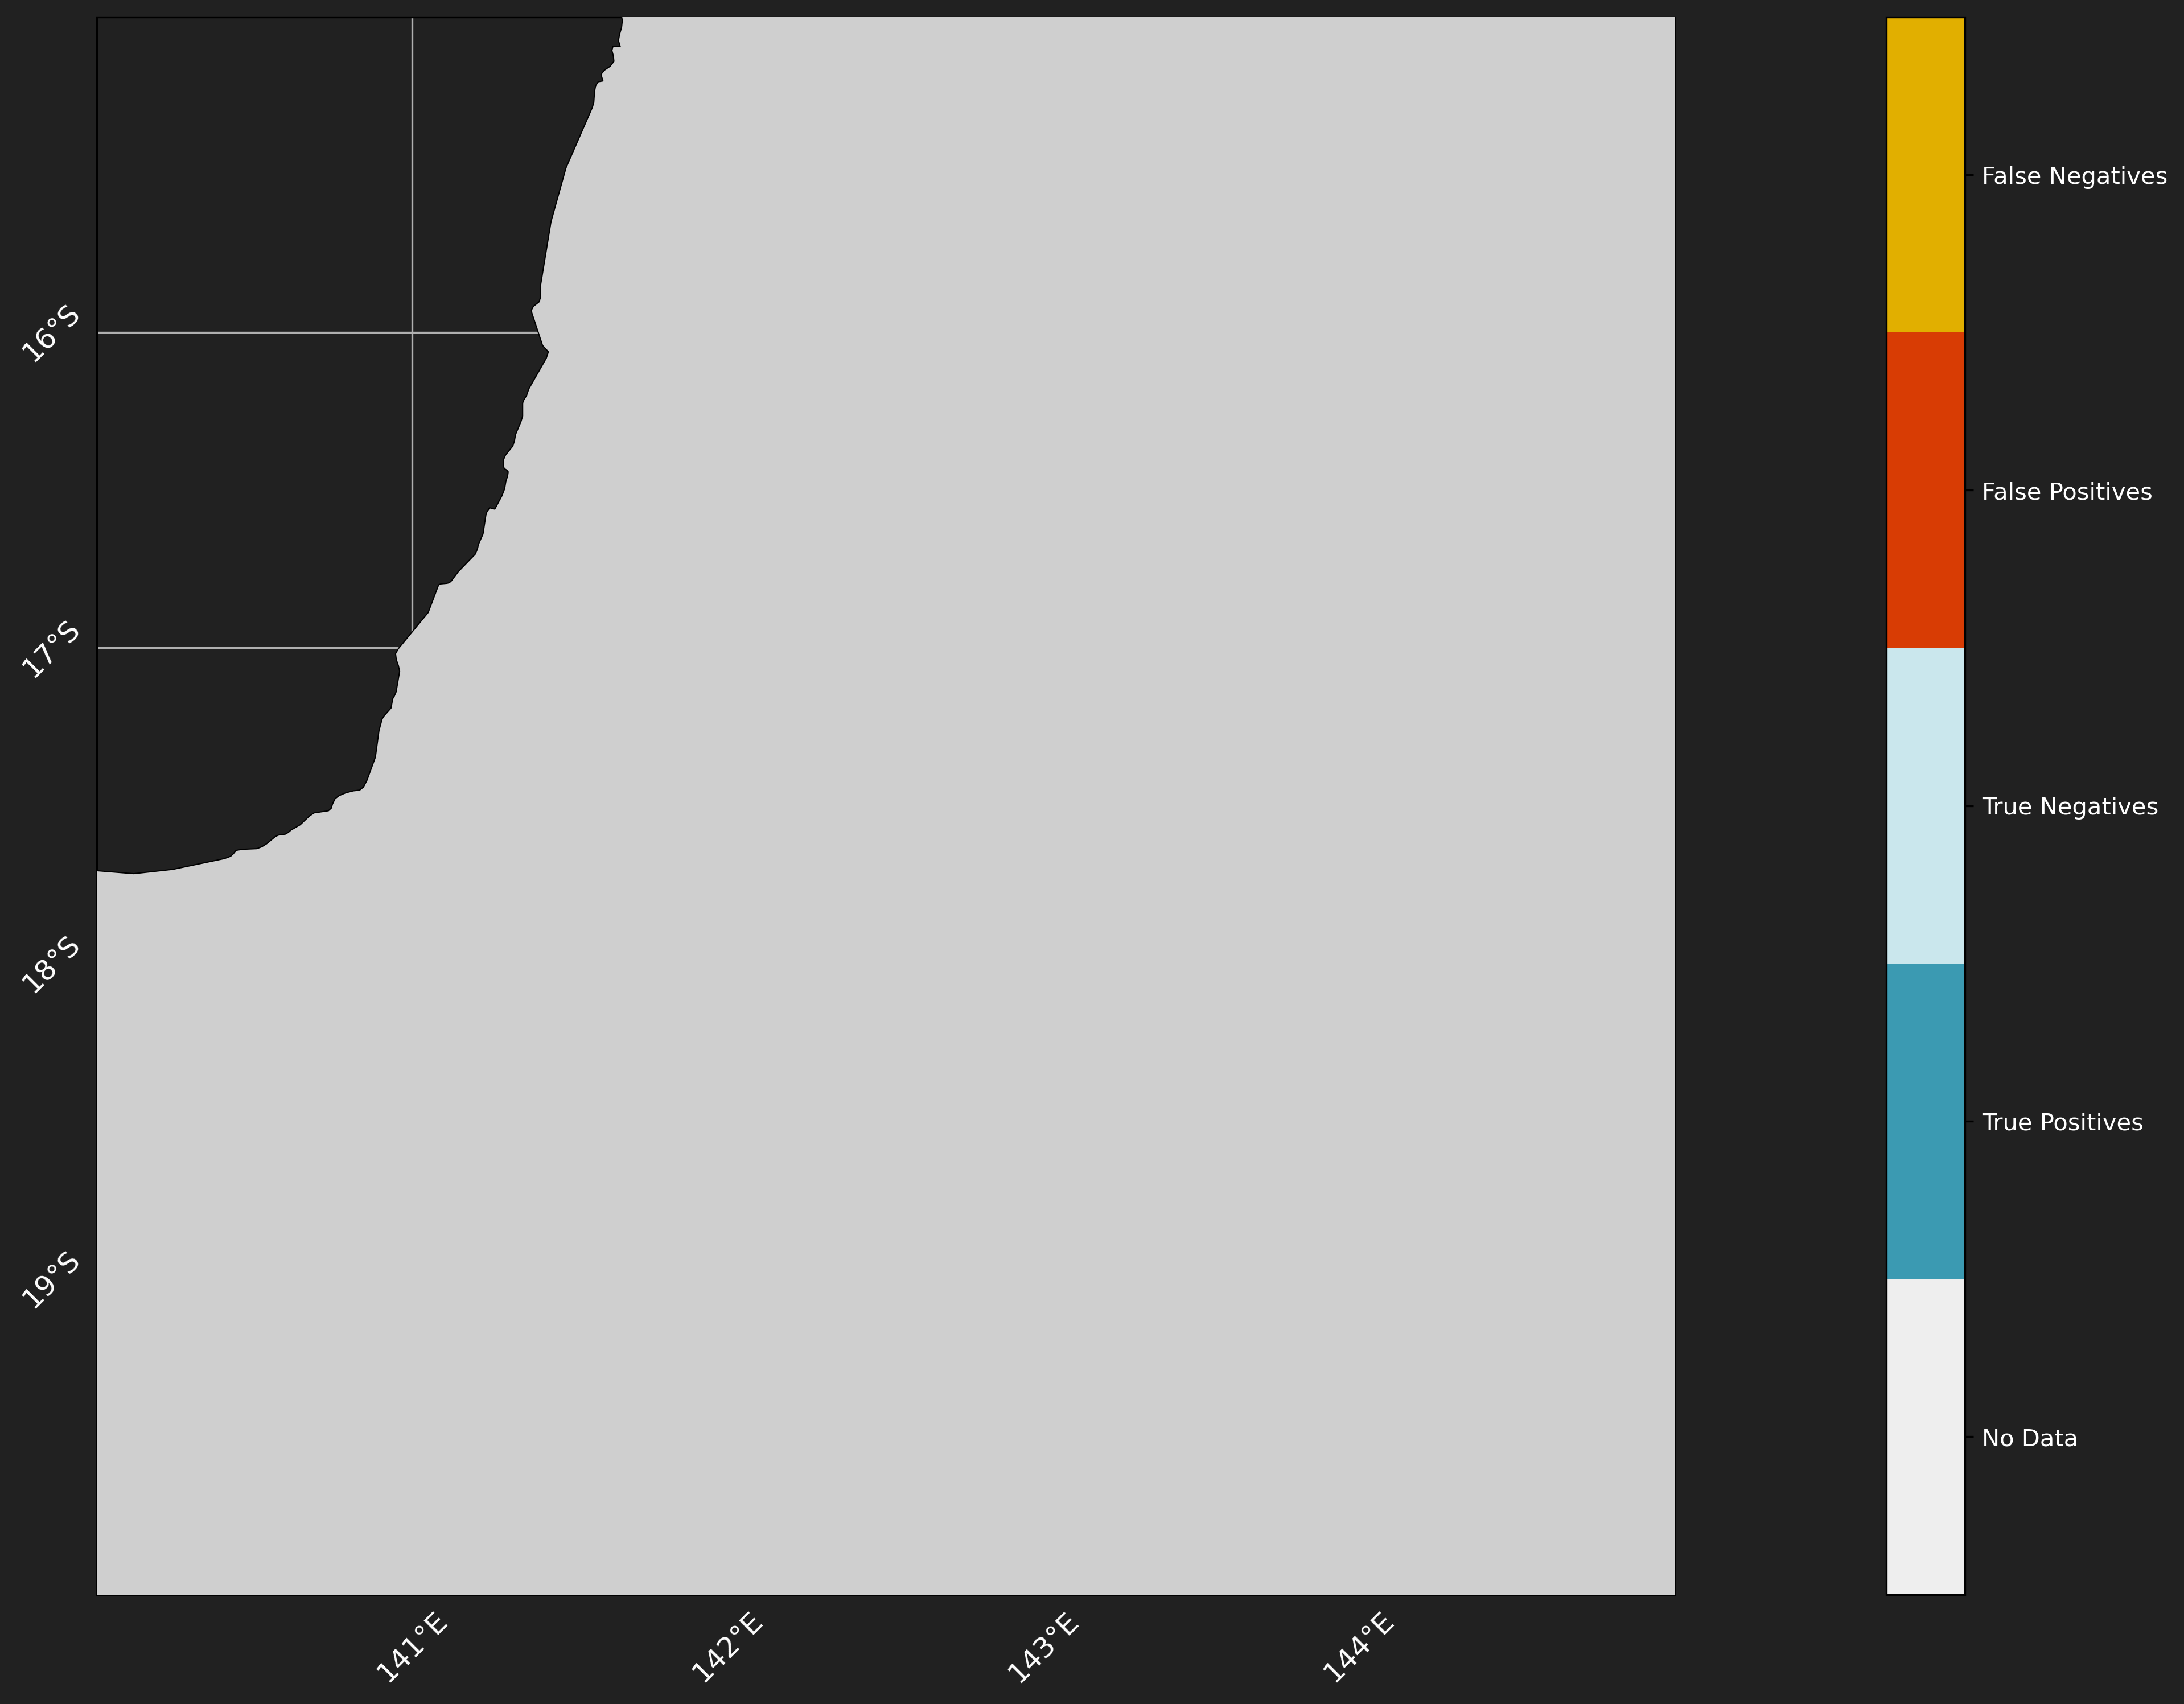

In [7]:
lons = [140, 145]
lats=[ -15, -10]



model = file_ops.read_pickle("/maps/rt582/coralshift/runs/0-01d/xgb_reg/ID021_cmip6_unep_gebco_slope/ID021_cmip6_unep_gebco_slope_MODEL.pickle")
config_info = file_ops.read_yaml("/maps/rt582/coralshift/runs/0-01d/xgb_reg/ID021_cmip6_unep_gebco_slope/ID021_cmip6_unep_gebco_slope_CONFIG.yaml")
# static_models.RunStaticML(config_info=config_info).
ml_results.AnalyseResults(model=model, model_code="xgb_reg",
    trains=trains, tests=tests, vals=vals, config_info=config_info, do_plot=True, presentation_format=True, save_graphs=False, extent=[*lons, *lats]).analyse_results()

In [ ]:
# config_info[""]
static_models.RunStaticML(model_code="rf_reg", config_info=config_info).run_model()   # TODO: fix this NoneType error


In [2]:
# run model
config_info = file_ops.read_yaml(config_fp)
static_models.run_models([
    # "lin_reg",
    # "log_reg",
    # "max_ent",
    # "rf_cf",
    # "gb_cf",
    # "rf_reg",
    # "gb_reg",
    # "xgb_cf",
    "xgb_reg",
    # # "mlp_cf",
    # "mlp_reg",
], config_fp=config_fp)

['python3 /maps-priv/maps/rt582/coralshift/coralshift/machine_learning/run_model.py --model_code xgb_reg --config_fp /maps/rt582/coralshift/runs/config_files/config_test.yaml > /maps-priv/maps/rt582/coralshift/logs/runs/0-01d/xgb_reg/ID020_cmip6_unep_gebco_slope.log 2>&1 &']


# Other

In [6]:
# remove nans
vals = xa_da.values.flatten()
vals = vals[~np.isnan(vals)]
kde = stats.gaussian_kde(vals)

NameError: name 'xa_da' is not defined

In [7]:
monthly_data.values.flatten()

NameError: name 'monthly_data' is not defined

In [ ]:
calculate_pdf(monthly_data.values.flatten(), vins)

In [ ]:
bin_edges

In [ ]:
calculate_pdf(flat_monthly_data, bins=bin_edges)

Text(0.5, 1.0, 'Cumulative Monthly PDFs')

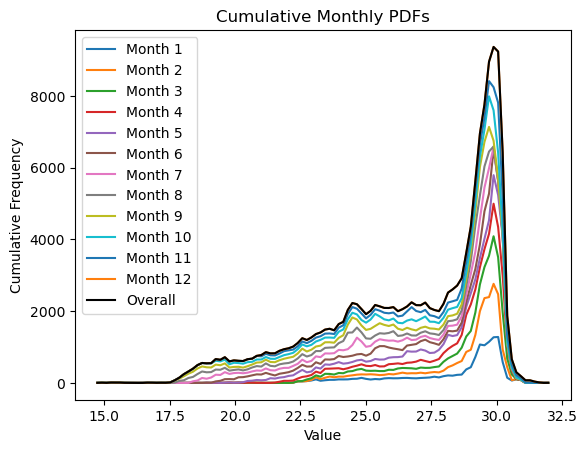

In [13]:
monthly_data = timeseries.groupby('time.month').mean(dim='time')["tos"]


# Define the bins using the overall data range
all_values = monthly_data.values.flatten()
all_values = all_values[~np.isnan(all_values)]
bin_edges = np.linspace(np.min(all_values), np.max(all_values), 101)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Function to calculate PDF with fixed bins
def calculate_pdf(array, bins):
    pdf, bins = np.histogram(array, bins=bins, density=False)
    return pdf, bins

# Prepare to plot PDFs
fig, ax = plt.subplots()

# Variable to store the cumulative PDF
cumulative_pdf = np.zeros_like(bin_centers)

stored = []
stored_cum = []

flat_monthly_data = monthly_data.values.flatten()
flat_monthly_data = flat_monthly_data[~np.isnan(flat_monthly_data)]


# Loop through each month and calculate the PDF
for month in range(1, 13):
    monthly_values = monthly_data.sel(month=month).values.flatten()
    monthly_values = monthly_values[~np.isnan(monthly_values)]
    pdf = calculate_pdf(monthly_values, bins=bin_edges)[0]
    
    cumulative_pdf += pdf
    
    stored.append(pdf)
    stored_cum.append(cumulative_pdf.copy())  # Copy to avoid reference issues
    ax.plot(bin_centers, cumulative_pdf, label=f'Month {month}')

ax.plot(bin_centers, calculate_pdf(flat_monthly_data, bins=bin_edges)[0], c="k", label='Overall')
# Add legend and labels
ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Cumulative Frequency')
ax.set_title('Cumulative Monthly PDFs')

Text(0.5, 1.0, 'Cumulative Monthly PDFs')

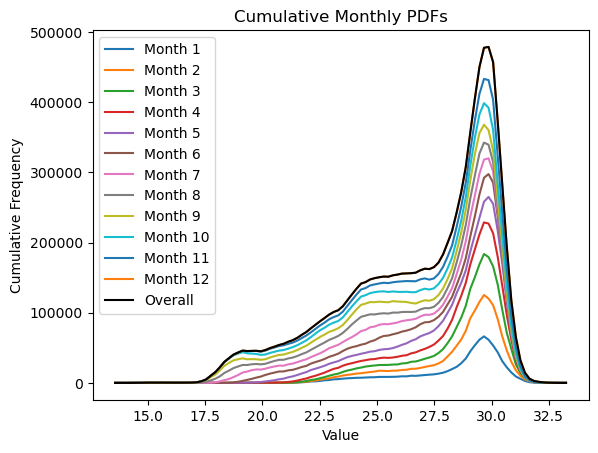

In [14]:
all_vals_spatial_av = timeseries["tos"]
monthly_data = all_vals_spatial_av.groupby('time.month')

# Define the bins using the overall data range
all_values = all_vals_spatial_av.values.flatten()
all_values = all_values[~np.isnan(all_values)]
bin_edges = np.linspace(np.min(all_values), np.max(all_values), 101)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Function to calculate PDF with fixed bins
def calculate_pdf(array, bins):
    pdf, bins = np.histogram(array, bins=bins, density=False)
    return pdf, bins

# Prepare to plot PDFs
fig, ax = plt.subplots()

# Variable to store the cumulative PDF
cumulative_pdf = np.zeros_like(bin_centers)

stored = []
stored_cum = []

flat_monthly_data = all_vals_spatial_av.values.flatten()
flat_monthly_data = flat_monthly_data[~np.isnan(flat_monthly_data)]


# Loop through each month and calculate the PDF
for month in range(1, 13):
    monthly_values = monthly_data[month].values.flatten()
    monthly_values = monthly_values[~np.isnan(monthly_values)]
    pdf = calculate_pdf(monthly_values, bins=bin_edges)[0]
    
    cumulative_pdf += pdf
    
    stored.append(pdf)
    stored_cum.append(cumulative_pdf.copy())  # Copy to avoid reference issues
    ax.plot(bin_centers, cumulative_pdf, label=f'Month {month}')

ax.plot(bin_centers, calculate_pdf(flat_monthly_data, bins=bin_edges)[0], c="k", label='Overall')
# Add legend and labels
ax.legend()
ax.set_xlabel('Value')
ax.set_ylabel('Cumulative Frequency')
ax.set_title('Cumulative Monthly PDFs')

In [ ]:
sns.kdeplot(flat_monthly_data, color="k", label="kde")

In [ ]:
stored_cum[3]

In [ ]:
stored_cum[0] < stored_cum[3]

In [ ]:
all_vals_spatial_av.groupby('time.month')[1]

NameError: name 'all_vals_temporal_av' is not defined

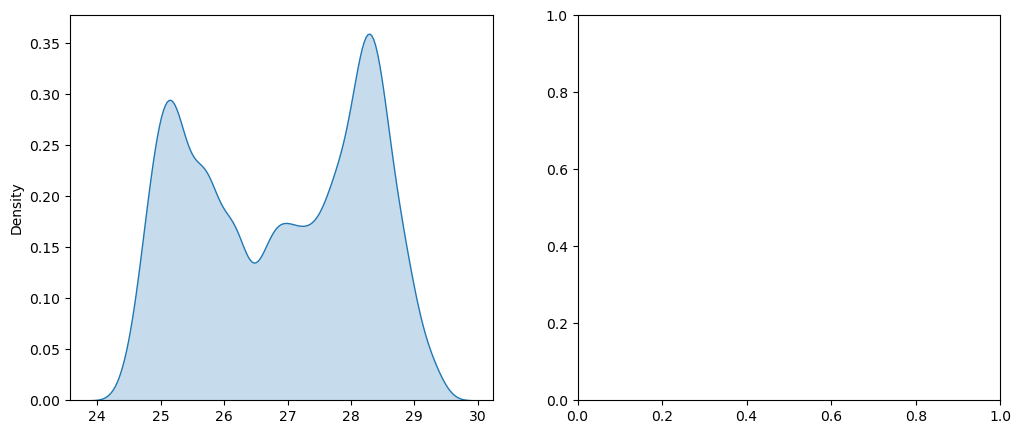

In [15]:
all_vals_spatial_av = timeseries.mean(dim=["latitude", "longitude"])["tos"]
all_vals_monthly_av = timeseries.groupby('time.month').mean(dim='time')["tos"]

fig, axes = plt.subplots(ncols=2, figsize=[12,5])
sns.kdeplot(all_vals_spatial_av, bw_adjust=0.5, fill=True, common_norm=False, ax=axes[0])
sns.kdeplot(all_vals_temporal_av, bw_adjust=0.5, fill=True, common_norm=False, ax=axes[1], legend=False)

In [ ]:
sns.kdeplot(monthly_values, bw_adjust=0.5, fill=True, common_norm=True)

range(0, 12)
range(0, 12)
range(0, 12)


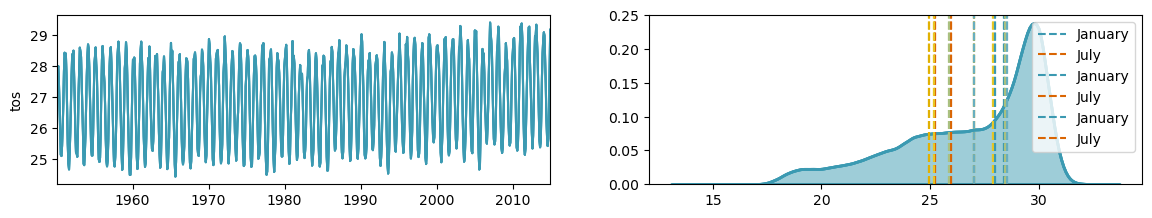

In [16]:
import calendar

def plot_month_marked_hist(ax, xa_d):
    sns.kdeplot(xa_d.values.flatten(), ax=ax, color="#3B9AB2", lw=2, fill=True, alpha=0.2)
    
    ax.set(xlabel=None, ylabel=None)
    
    # Set scientific notation for y-axis labels if values are below 0.01
    if xa_d.mean(dim=["latitude", "longitude"]).values.min() < 0.01:
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0), useMathText=True)

    # Plot vertical lines on histogram corresponding to means for each month
    monthly_xa_d = xa_d.groupby("time.month").mean(dim="time").mean(dim=["latitude", "longitude"])
    month_names = [calendar.month_name[i] for i in monthly_xa_d["month"].values]
    
    cmap = spatial_plots.ColourMapGenerator().get_cmap("cyc")
    colours = [cmap(value) for value in np.linspace(0, 1, len(monthly_xa_d.month))]
    print(range(len(monthly_xa_d.month)))
    for month_i in range(len(monthly_xa_d.month)):
        month_mean_val = monthly_xa_d.isel(month=month_i).values
        
        if month_i % len(monthly_xa_d.month) == 6 or month_i % len(monthly_xa_d.month) == 0:
            ax.axvline(month_mean_val, color=colours[month_i], linestyle="--", alpha=1, label=month_names[month_i])
        else:
            ax.axvline(month_mean_val, color=colours[month_i], linestyle="--", alpha=1)
    
    ax.legend(loc="upper right")


def plot_timeseries_hist(ax, xa_d):
    # Plot timeseries average over longitude, latitude
    xa_d.mean(dim=["latitude", "longitude"]).plot(ax=ax[0], color="#3B9AB2")
    ax[0].set(xlabel=None)
    ax[0].set_xlim([xa_d.time.values[0], xa_d.time.values[-1]])
    
    if xa_d.mean(dim=["latitude", "longitude"]).values.min() < 0.01:
        ax[0].ticklabel_format(axis="y", style="sci", scilimits=(-4,4), useMathText=True)

    plot_month_marked_hist(ax[1], xa_d)
    # Plot normal distribution of timeseries values using seaborn
    # sns.kdeplot(xa_d.mean(dim=["latitude", "longitude"]).values.flatten(), ax=ax[1], color="#3B9AB2", lw=2, fill=True, alpha=0.2)
    # sns.kdeplot(xa_d.mean(dim=["latitude", "longitude"]).values.flatten(), ax=ax[1], color="#3B9AB2", lw=2, fill=True, alpha=0.2)
 

def plot_timeseries_hists(timeseries_xa_d):

    if isinstance(timeseries_xa_d, xa.Dataset):
        variable_names = timeseries_xa_d.data_vars
        num_variables = len(variable_names)
    else:
        variable_names = timeseries_xa_d.name
        num_variables = 1
    
    f, axes = plt.subplots(nrows=num_variables, ncols=2, figsize=[14, 2.2*num_variables])
    for ax_i, var in enumerate(variable_names):
        if not isinstance(timeseries_xa_d, xa.DataArray):
            xa_d = timeseries_xa_d[var]
        else:
            xa_d = timeseries_xa_d
            plot_timeseries_hist(axes, xa_d)
            continue

        # plot_timeseries_hist(axes[i], xa_d)
            
        
        # # Plot vertical lines on histogram corresponding to means for each month
        # monthly_xa_d = xa_d.groupby("time.month").mean(dim="time").mean(dim=["latitude", "longitude"])
        # month_names = [calendar.month_name[i] for i in monthly_xa_d["month"].values]
        
        # cmap = spatial_plots.ColourMapGenerator().get_cmap("cyc")
        # colours = [cmap(value) for value in np.linspace(0, 1, len(monthly_xa_d.month))]
        
        # for month_i in range(len(monthly_xa_d.month)):
        #     month_mean_val = monthly_xa_d.isel(month=month_i).values
            
        #     if month_i % len(monthly_xa_d.month) == 6 or month_i % len(monthly_xa_d.month) == 0:
        #         axes[ax_i, 1].axvline(month_mean_val, color=colours[month_i], linestyle="--", alpha=1, label=month_names[month_i])
        #     else:
        #         axes[ax_i, 1].axvline(month_mean_val, color=colours[month_i], linestyle="--", alpha=1)
        
        # axes[ax_i, 1].legend(loc="upper right")

plot_timeseries_hists(timeseries["tos"])

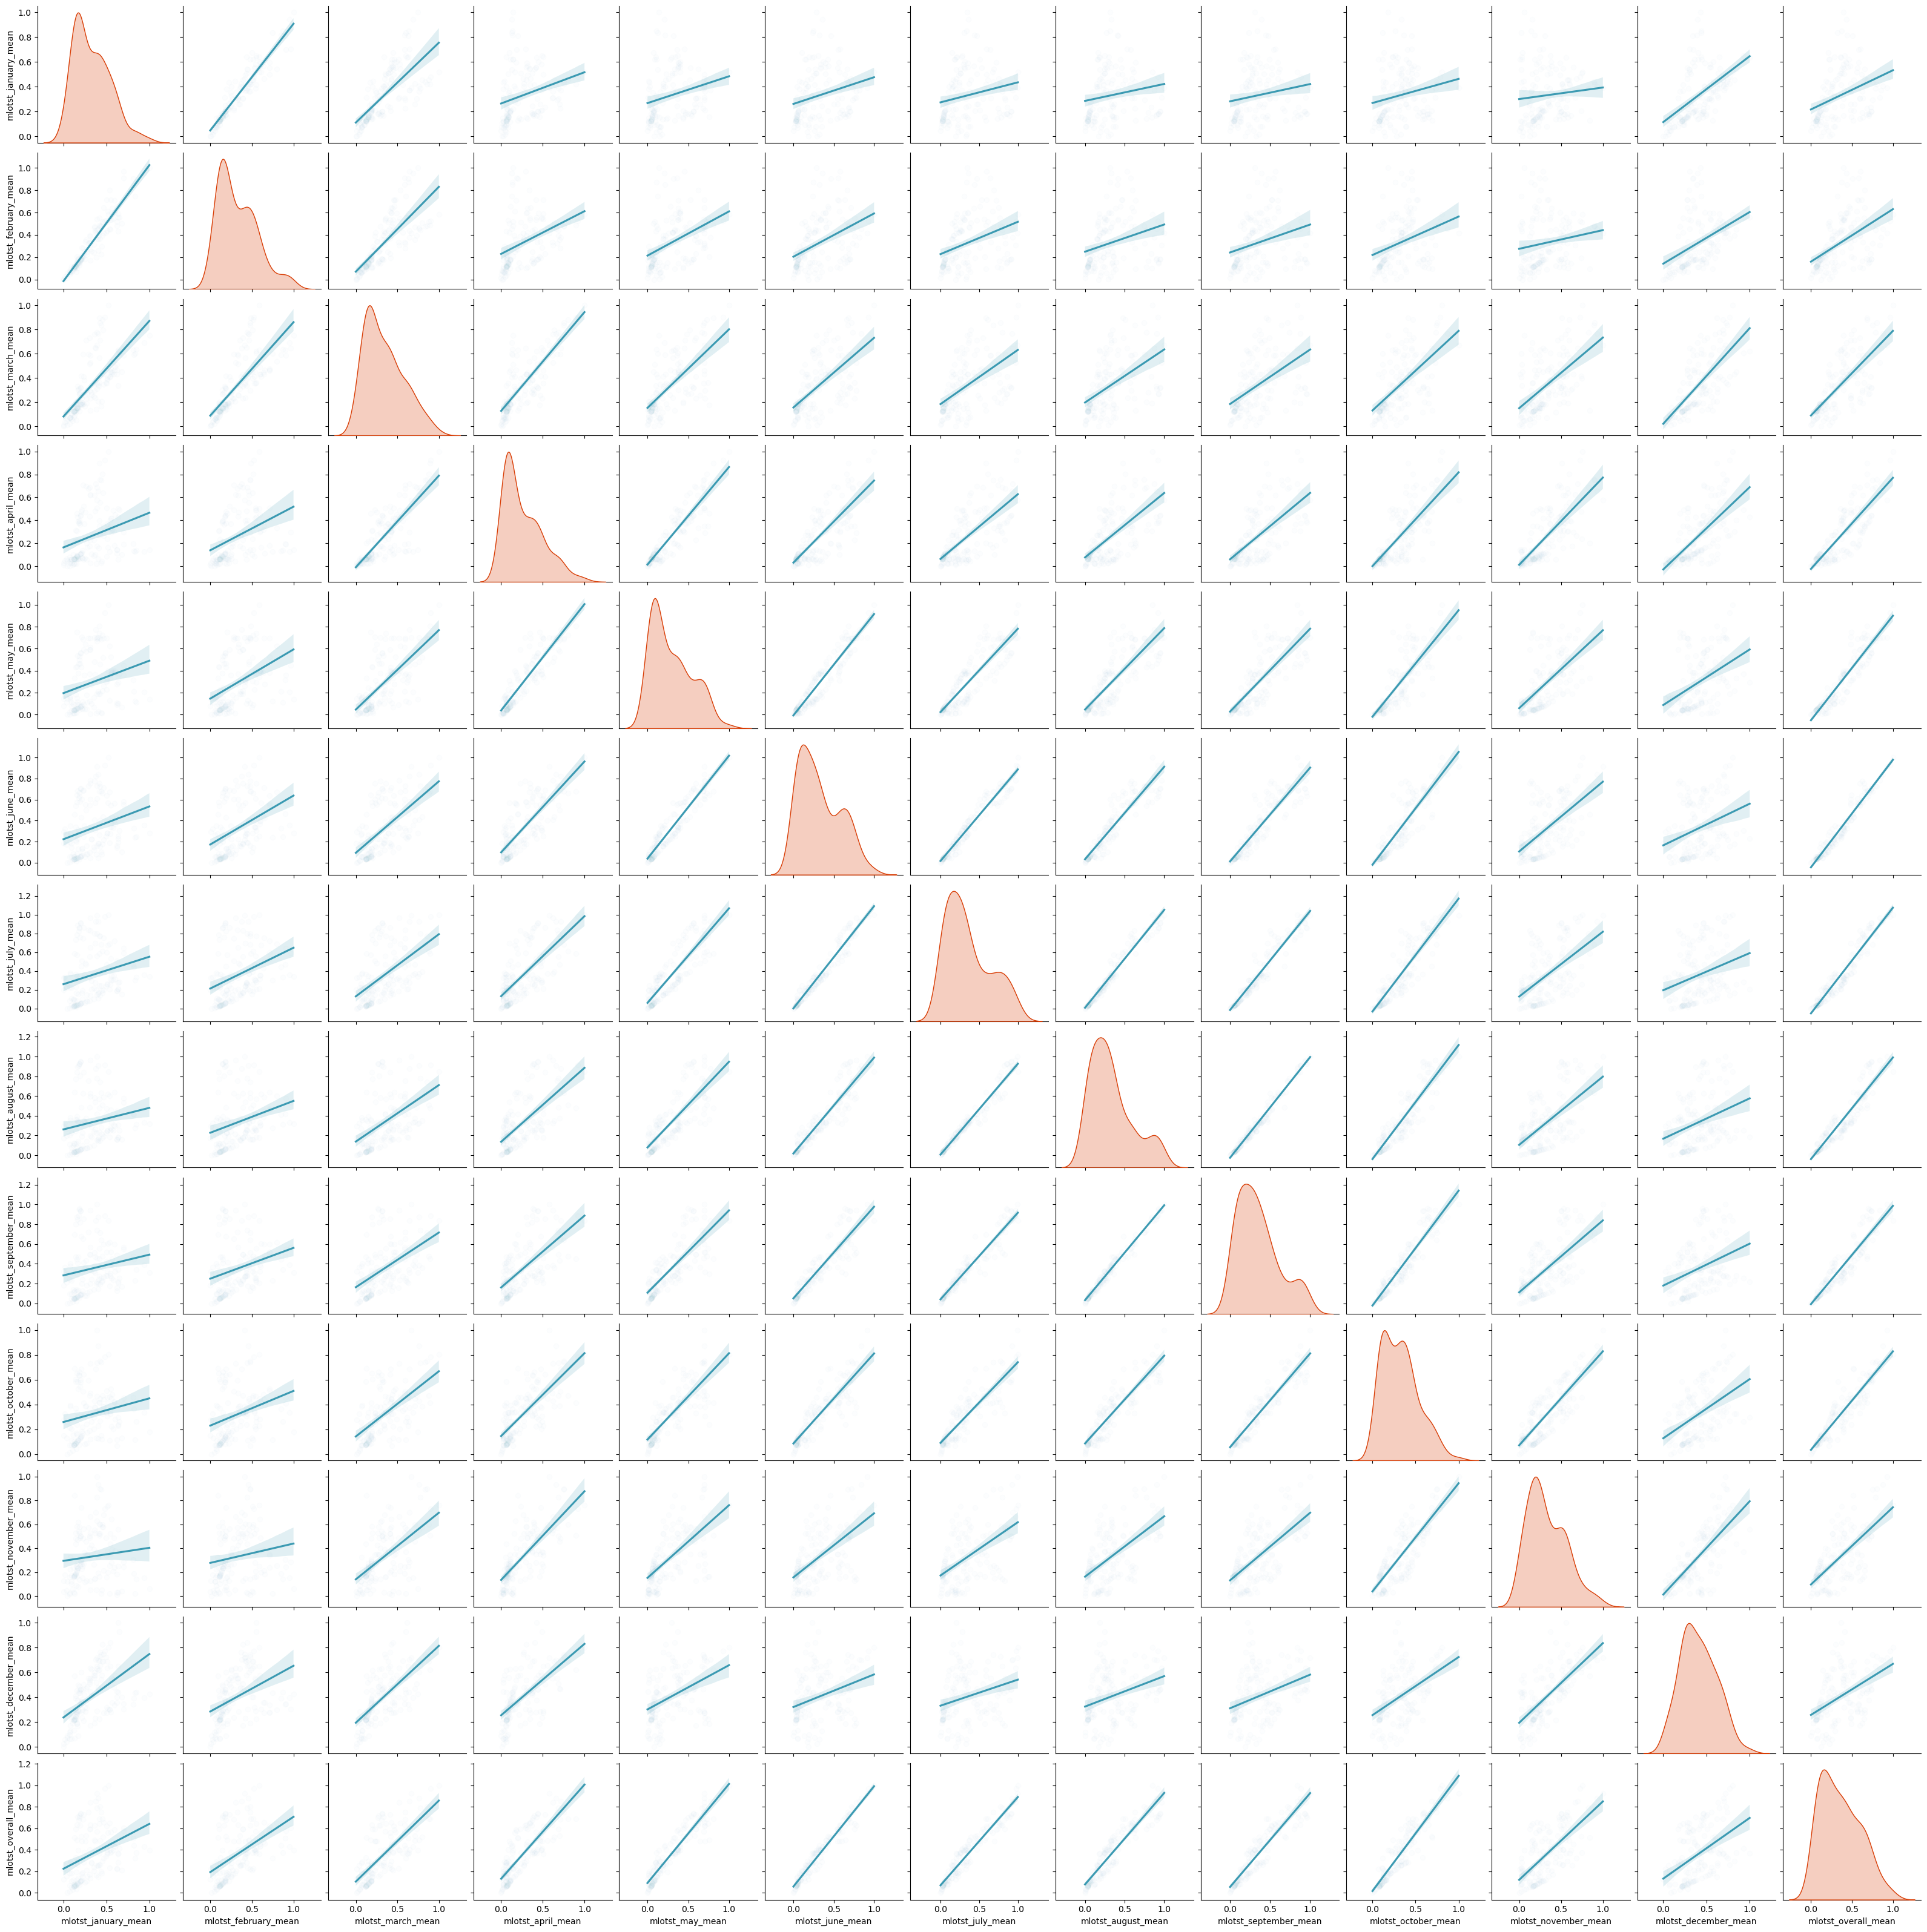

In [18]:
sns.pairplot(trains[0].filter(regex="^mlotst.*mean$")[::-1], kind="reg", diag_kind="kde", plot_kws={"color":"#3B9AB2", "scatter_kws": {"alpha": 0.01}}, diag_kws={"color":"#d83c04"})

In [19]:
trains[0].filter(regex=".*_january_mean$")

mlotst_january_mean  rsdo_january_mean  so_january_mean  \
latitude longitude                                                            
-8.5     132.5                 0.519250           0.013148         0.587966   
         150.5                 0.045310           0.047720         0.773394   
-6.5     137.5                 0.250031           0.583605         0.187778   
-18.5    147.5                 0.258804           0.198492         0.792861   
-22.5    153.5                 0.478842           0.085545         0.786784   
...                                 ...                ...              ...   
-9.5     132.5                 0.416109           0.013810         0.652135   
-22.5    167.5                 0.164765           0.086171         0.842517   
-10.5    135.5                 0.553061           0.076832         0.719043   
-2.5     150.5                 0.214854           0.017817         0.757001   
-10.5    150.5                 0.171547           0.278353         0.742240   

                    thetao_january_mean  tos_january_mean  uo_january_mean  \
latitude longitude                                                           
-8.5     132.5                 0.494967          0.636233         0.627366   
         150.5                 0.381744          0.783434         0.015566   
-6.5     137.5                 0.868228          0.786983         0.581752   
-18.5    147.5                 0.412077          0.537260         0.706557   
-22.5    153.5                 0.327044          0.350322         0.598088   
...                                 ...               ...              ...   
-9.5     132.5                 0.512761          0.665945         0.304027   
-22.5    167.5                 0.000000          0.111279         0.783798   
-10.5    135.5                 0.783357          0.730408         0.450158   
-2.5     150.5                 0.726408          0.814976         0.189648   
-10.5    150.5                 0.521318          0.707822         0.692238   

                    vo_january_mean  hfds_january_mean  vmo_january_mean  \
latitude longitude                                                         
-8.5     132.5             0.630317           0.306210          0.589793   
         150.5             0.759203           0.838768          0.733210   
-6.5     137.5             0.679463           0.111861          0.665352   
-18.5    147.5             0.658971           0.695428          0.622401   
-22.5    153.5             0.390962           0.422587          0.346125   
...                             ...                ...               ...   
-9.5     132.5             0.664309           0.331818          0.627580   
-22.5    167.5             0.755231           0.920948          0.723158   
-10.5    135.5             0.691834           0.215674          0.659035   
-2.5     150.5             0.690552           0.500504          0.656671   
-10.5    150.5             0.722164           0.786183          0.691925   

                    umo_january_mean  wfo_january_mean  
latitude longitude                                      
-8.5     132.5              0.641415          0.547835  
         150.5              0.008965          0.420431  
-6.5     137.5              0.597662          0.171050  
-18.5    147.5              0.718082          0.748946  
-22.5    153.5              0.613771          0.996453  
...                              ...               ...  
-9.5     132.5              0.318216          0.492402  
-22.5    167.5              0.782101          0.951225  
-10.5    135.5              0.502918          0.411465  
-2.5     150.5              0.213899          0.480594  
-10.5    150.5              0.688203          0.638202  

[148 rows x 11 columns]

In [ ]:
sns.pairplot(trains[0].filter(regex=".*_january_mean$")[::-1], kind="reg", diag_kind="kde", plot_kws={"color":"#3B9AB2", "scatter_kws": {"alpha": 0.01}}, diag_kws={"color":"#d83c04"})

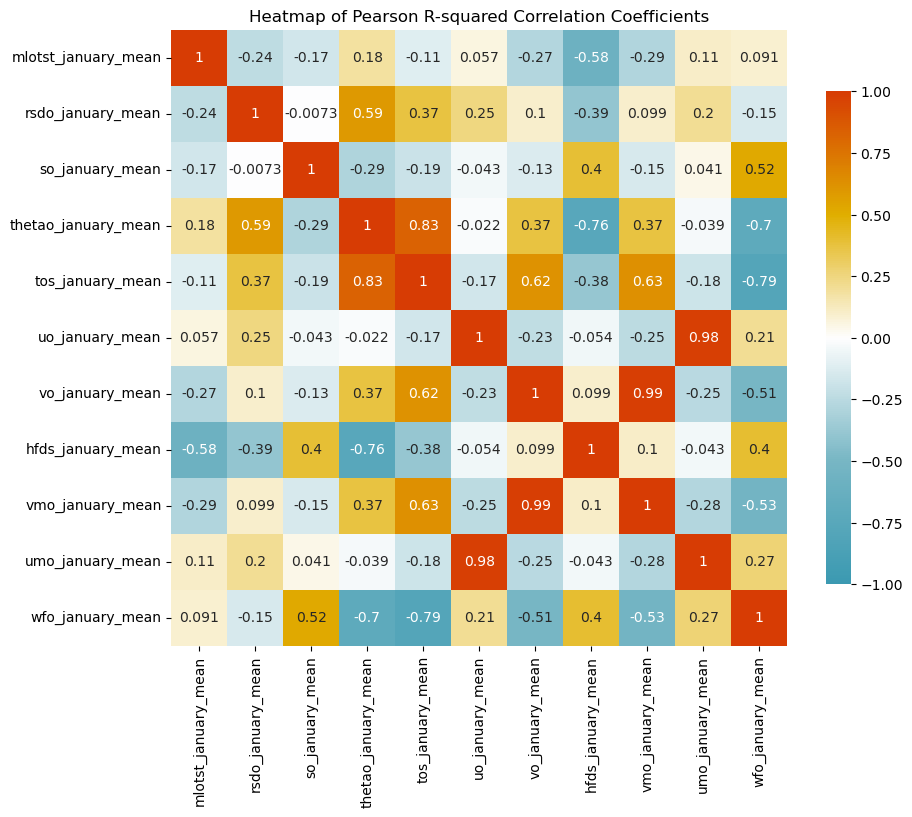

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate Pearson correlation matrix
correlation_matrix = trains[0].filter(regex=".*_january_mean$").corr() 

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=spatial_plots.ColourMapGenerator().get_cmap("div", vmin=-1, vmax=1)[0], square=True, cbar_kws={"shrink": .8}, vmin=-1, vmax=1)
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title('Heatmap of Pearson R-squared Correlation Coefficients')
plt.show()




## Ground truth

In [ ]:
unep_raster = get_data.ReturnRaster(config_info=config_info).get_raw_raster(dataset="unep").sel(latitude=slice(-15,-10), longitude=slice(142.5, 145))
unep_raster_resampled = get_data.ReturnRaster(resolution=0.01, config_info=config_info).get_resampled_raster(unep_raster)

In [ ]:
# normalise datarray
norm_unep = unep_raster_resampled["UNEP_GDCR"] / unep_raster_resampled["UNEP_GDCR"].max()

spatial_plots.plot_spatial(norm_unep.sel(latitude=slice(-15,-10), longitude=slice(142.5, 145)), cartopy_dict={"alpha":1, "facecolor": "lightgrey"}, labels=None)

In [ ]:
space_lim_norm_unep = norm_unep.sel(latitude=slice(-15,-10), longitude=slice(142.5, 145))

import cartopy.crs as ccrs
num_plots = 5
fig, axes = plt.subplots(dpi=300, nrows=1, ncols=num_plots, figsize=[20, 8*num_plots], subplot_kw={"projection": ccrs.PlateCarree()})
thresholds = np.linspace(0.1, 0.5, num_plots)
for threshold_i, threshold in enumerate(thresholds):
    spatial_plots.plot_spatial(space_lim_norm_unep.where(space_lim_norm_unep > threshold), fax=(fig, axes[threshold_i]), title=f"Threshold: {round(threshold,1)}", cbar_dict={"cbar": None}, val_lims=[0,1], labels=None, cartopy_dict={"facecolor": "lightgrey", "alpha": 1})

# tight layout
plt.tight_layout()

In [ ]:
# quantitative threshold effect
from tqdm.auto import tqdm

num_thresholds = 100
thresholds = np.linspace(0, 1, num_thresholds)
resolutions = [0.1, 0.25, 0.5, 0.75, 1]
sum_vals = np.zeros((num_thresholds, len(resolutions)))

unep_raster = get_data.ReturnRaster(lats=[-90,90], lons=[-180,180], config_info=config_info).get_raw_raster(dataset="unep")
# unep_raster = get_data.ReturnRaster(config_info=config_info).get_raw_raster(dataset="unep")

for resolution_i, resolution in enumerate(resolutions):
    unep_da = get_data.ReturnRaster(lats=[-90,90], lons=[-180,180], resolution=resolution, config_info=config_info).get_resampled_raster(unep_raster)
    # norm_unep_da = unep_da["UNEP_GDCR"] / unep_da["UNEP_GDCR"].max()
    norm_unep_da = unep_da["unep_coral_presence"] / unep_da["unep_coral_presence"].max()
    for threshold_i, threshold in tqdm(enumerate(thresholds), total=len(thresholds), desc="Calculating thresholded values"):
        sum_vals[threshold_i][resolution_i] = norm_unep_da.where(norm_unep_da > threshold).sum()


In [ ]:


cmap = spatial_plots.ColourMapGenerator().get_cmap("seq")
colours = [cmap(value) for value in np.linspace(0,1,len(resolutions))]
f = plt.figure(figsize=[10,5])

thresholds = np.linspace(0, 1, num_thresholds)

for resolution_i, resolution in enumerate(resolutions):
    plt.plot(thresholds, sum_vals[:, resolution_i], color=colours[resolution_i], label=f"Resolution: {resolution}º")

thresholds = np.linspace(0.1, 0.5, 5)

for threshold in thresholds:
    plt.vlines(threshold, 0, np.max(sum_vals), color="black", linestyle="--", alpha=0.5)

plt.xlabel("Presence-absence threshold")
plt.ylabel("Sum of values exceeding threshold")
plt.legend()
plt.ylim([0, np.max(sum_vals)])
plt.xlim([0, 1])
plt.xticks(np.linspace(0, 1, 11));

In [ ]:
from shapely.geometry import Polygon

global_unep_raster = get_data.ReturnRaster(lats=[-90,90],lons=[-180,180], config_info=config_info).get_raw_raster(dataset="unep")
resampled_global_unep_raster = get_data.ReturnRaster(lats=[-90,90],lons=[-180,180], resolution=1, config_info=config_info).get_resampled_raster(global_unep_raster)

f, ax, im = spatial_plots.plot_spatial(resampled_global_unep_raster["unep_coral_presence"], extent="global", title=None, labels=None, cbar_dict={"cbar": False})

# plot rectangle over area
lats = config_info["lats"]
lons = config_info["lons"]

rectangle = Polygon([(min(lons), min(lats)), (min(lons), max(lats)), (max(lons), max(lats)), (max(lons), min(lats))])

ax.add_geometries([rectangle], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', zorder=10)

In [ ]:
unep_raster_resampled_001 = get_data.ReturnRaster(resolution=0.1, config_info=config_info).get_resampled_raster(unep_raster)
spatial_plots.plot_spatial(unep_raster_resampled_001["unep_coral_presence"], title=None, labels=["h"], cbar_dict={"cbar": False})

In [ ]:
from shapely.geometry import Polygon

fig, axes = plt.subplots(ncols=2, figsize=[24,12], subplot_kw={"projection": ccrs.Robinson()})

spatial_plots.plot_spatial(resampled_global_unep_raster["unep_coral_presence"], fax=(fig, axes[0]), extent="global", title=None, labels=None, cbar_dict={"cbar": False})

# plot rectangle over area
lats = sorted(config_info["lats"])
lons = sorted(config_info["lons"])
rectangle = Polygon([(min(lons), min(lats)), (min(lons), max(lats)), (max(lons), max(lats)), (max(lons), min(lats))])

spatial_plots.plot_spatial(unep_raster_resampled_001["unep_coral_presence"].sel(latitude=slice(lats[0], lats[1]), longitude=slice(lons[0], lons[1])), fax=(fig, axes[1]), map_proj=ccrs.Robinson(), title=None, labels=["d"], cbar_dict={"cbar": False})
aspect_ratio = axes[0].get_aspect()
axes[1].set_aspect(aspect=aspect_ratio/1.5)

axes[0].add_geometries([rectangle], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', zorder=10)
axes[1].add_geometries([rectangle], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', zorder=10, lw=4)

# Resampling

In [ ]:
# get data
resolutions = [1, 
# 0.5, 
# 0.25, 0.1, 0.05, 0.01
]
depth_lims = [(-2000, 0), (-1500, 0),
(-1000, 0), (-500, 0), (-200, 0), (-100, 0), (-80, 0), (-60, 0), (-40, 0), (-20, 0)
]

vals = []
unep_val_sample = []
gebco_val_sample = []
num_points = 10000

lats = config_info["lats"]
lons = config_info["lons"]
# unep_fp = Path(config.gdcr_dir) / "01_Data/WCMC008_CoralReef2021_Py_v4_1.shp"
# unep_gdf = gpd.read_file(unep_fp)
gebco_xa = get_data.ReturnRaster(config_info=config_info).get_raw_raster(dataset="gebco")

for resolution in tqdm(resolutions, desc=f"iterating over {len(resolutions)} resolution(s)..."):
    # generate gt raster at correct resolution
    unep_raster = get_data.rasterize_geodf(
        unep_gdf, resolution=resolution,
    )
    # generate gt xarray at correct resolution
    unep_xa = spatial_data.process_xa_d(get_data.raster_to_xarray(
        unep_raster,
        x_y_limits=utils.lat_lon_vals_from_geo_df(unep_gdf)[:4],
        resolution=resolution,
        name="unep_coral_presence",
    )).sel(latitude=slice(min(lats), max(lats)), longitude=slice(min(lons), max(lons)))

    # ensure unep array normalised
    unep_xa = unep_xa / unep_xa.max()

    # scale gebco bathymetry to correct resolution
    gebco_xa_resampled = get_data.resample_to_other(gebco_xa, unep_xa).compute()
    
    if len(unep_xa.values.flatten()) < num_points:
        unep_val_sample.append(unep_xa.values.flatten())
        gebco_val_sample.append(gebco_xa_resampled["elevation"].values.flatten())
    else:
        unep_val_sample.append(unep_xa.values.flatten()[::int(len(unep_xa.values.flatten())/num_points)])
        gebco_val_sample.append(gebco_xa_resampled["elevation"].values.flatten()[::int(len(unep_xa.values.flatten())/num_points)])

    # get ratios of coral presence to bathymetry
    # TODO: getting a ratio greater than 1: fix
    vals.append(functions_creche.investigate_depth_mask(
        comp_var_xa=unep_xa, mask_var_xa=gebco_xa_resampled, var_limits=depth_lims))
    

In [ ]:
functions_creche.investigate_depth_mask(
        comp_var_xa=unep_xa, mask_var_xa=gebco_xa_resampled, var_limits=depth_lims)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), dpi=300)  # Creating side-by-side subplots

colours = spatial_plots.get_n_colors_from_hexes(len(resolutions))
x_labels = [str(depth_lim) for depth_lim in depth_lims]

# plotting
for j, resolution in enumerate(resolutions[::-1]):
    val_sums = vals[j][0]
    val_ratios = vals[j][1]
    ax1.scatter(x_labels, val_sums, label=f"resolution: {resolution}", c=colours[j], marker="o")
    ax2.scatter(x_labels, val_ratios, label=f"resolution: {resolution}", c=colours[j], marker="x")

# formatting
# spatial_plots.customize_plot_colors(fig, ax1)
# spatial_plots.customize_plot_colors(fig, ax2)

ax1.set_ylabel("Total coral presence")
ax2.set_ylabel("Coral presence-absence ratio")
ax1.set_xlabel("Depth mask limits (m)")
ax2.set_xlabel("Depth mask limits (m)")
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)

# Create legends for markers (resolutions)
legend_lines_1 = [
    Line2D([0], [0], color=colours[j], marker="o", linestyle='None', label=f"resolution: {resolutions[j]}")
    for j in range(len(resolutions))
]
ax1.legend(handles=legend_lines_1, loc='upper left', title="# grid cells containing coral")
ax1.set_yscale("log")
ax1.grid()

legend_lines_2 = [
    Line2D([0], [0], color=colours[j], marker="x", linestyle='None', label=f"resolution: {resolutions[j]}")
    for j in range(len(resolutions))
]
ax2.legend(handles=legend_lines_2, loc='upper right', title="coral presence-absence ratio")
ax2.axhline(0.5, c="b", ls="--")
plt.show()


In [ ]:
np.shape(vals)

In [ ]:
np.max(val_ratios)

In [ ]:
data

In [ ]:
N = len(resolutions)

data = {"resolution": [], "depth": [], "value": []}

for i in range(N):
    data["resolution"].extend([str(resolutions[i])] * len(gebco_val_sample[i]))
    data["depth"].extend(gebco_val_sample[i])
    data["value"].extend(unep_val_sample[i])
    
df_cat = pd.DataFrame(data)

# Separate the data based on 'value' for plotting
df_value_0 = df_cat[df_cat['value'] == 0]
df_value_1 = df_cat[df_cat['value'] != 0]

# Create an array with the colors you want to use
presence_palette = sns.color_palette(["#d83c04"])
absence_palette = sns.color_palette(["#3B9AB2"])

# Set your custom color palette
sns.set_palette(absence_palette)
fig, ax = plt.subplots(dpi=300)
# Create a scatter plot with Seaborn's stripplot for value '0' first
sns.stripplot(ax=ax, data=df_value_0, x="depth", y="resolution", hue="value", palette=absence_palette, legend=False, s=3, alpha=0.1)

sns.set_palette(presence_palette)

# Then plot value '1' on top with higher opacity
sns.stripplot(data=df_value_1, x="depth", y="resolution", hue="value", palette=presence_palette, legend=False, s=3, alpha=0.5, ax=ax)

        
plt.ylabel("Resolution (degrees)")
plt.xlabel("Depth")

# customize_plot_colors(fig, ax)

# Manipulate x-axis ticks and labels to show only every 100th value
new_ticks = ax.get_xticks()[::1]
ax.set_xticks(new_ticks)
ax.set_xticklabels([f'{int(val)}' for val in new_ticks])

plt.xlim([-6000, 2000])

# Create a legend with matching colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=["#3B9AB2", "#d83c04"][i], markersize=10, label=str(val)) for i, val in enumerate(["absence", "presence"])]
plt.legend(handles=legend_handles, title="Value", loc="lower left");
